# A test of our custom xgboost pipeline with feature explanation

In [63]:
# Import modules

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from matplotlib import markers
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, auc, classification_report, f1_score, log_loss, precision_recall_curve, roc_curve, roc_auc_score, precision_score, recall_score, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.feature_selection import mutual_info_classif, SelectFromModel, SelectKBest
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import LabelBinarizer
from xgboost.sklearn import XGBClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from random import uniform
from bayes_opt import BayesianOptimization
import lime
import shap

In [64]:
# Set plot style
plt.style.use('dark_background')

In [65]:
# Set pandas preferences:
pd.options.display.max_columns=500
pd.options.display.max_colwidth=1000

In [66]:
# Make some test data
from sklearn.datasets import make_classification

In [67]:
data, target = make_classification(n_samples=10000,
                                   n_features=50,
                                   n_informative=30,
                                   n_redundant=10)

In [68]:
# Split up the data as needed.
train_X, calibrate_X, train_y, calibrate_y = train_test_split(data, target, test_size=0.1)

In [69]:
train_X, test_X, train_y, test_y = train_test_split(train_X, train_y, test_size=0.2)

# Some useful functions

In [70]:
def make_roc_curves_array(true_vals, scores_vals, figsize=(10,10)):
    """Function for making nice-ish looking roc curves."""
    fpr, tpr, threshold = roc_curve(y_true=true_vals, y_score=scores_vals)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=figsize)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return fpr, tpr, threshold, roc_auc

In [71]:
def make_roc_curves_df(df, true_col, scores_col, figsize=(10,10)):
    """Function for making nice-ish looking roc curves."""
    fpr, tpr, threshold = roc_curve(y_true=df[true_col].values, y_score=df[scores_col].values)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=figsize)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc='lower right')
    plt.show()
    
    return fpr, tpr, threshold, roc_auc

In [72]:
def calibration_func_array(true_vals, probability_vals_list, legend_labels, title, n_bins=20, figsize=(10,10)):
    """Function for making reliability plots"""
    y_vals = []
    x_vals = []
    for vals in probability_vals_list:
        y_array, x_array = calibration_curve(true_vals, vals, n_bins=n_bins)
        y_vals.append(y_array)
        x_vals.append(x_array)
    
    fig, ax = plt.subplots(figsize=figsize)
    for i in range(0, len(legend_labels)):
        plt.plot(x_vals[i], y_vals[i], linewidth=1, label=legend_labels[i], marker=markers.MarkerStyle.filled_markers[i])
    
    # Reference line, legends, and axis labels
    line = mlines.line2D([0, 1], [0, 1], color='white')
    transform = ax.transAxes
    line.set_transform(transform)
    ax.add_line(line)
    fig.suptitle(title)
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('True probability in each bin')
    plt.legend()
    plt.show()

In [73]:
def make_score_distribution(df, proba_cols, true_col, true_label, title=None, figsize=(10,10)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.distplot(df[proba_cols[0]].loc[(df[true_col] == true_label)], kde=False, ax=ax)
    if title:
        sns.distplot(df[proba_cols[1]].loc[(df[true_col] == true_label)], kde=False, ax=ax).set_title(title)
    else:
        sns.distplot(df[proba_cols[1]].loc[(df[true_col] == true_label)], kde=False, ax=ax)
    ax.set(xlabel='score', ylabel='count')
    plt.show()

# Custom xgboost classifier class object

In [74]:
class EarlyStoppingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, classifier, evaluation_metric, num_rounds, feature_selector=None, validation_size=None):
        self.classifier = classifier
        self.evaluation_metric = evaluation_metric
        self.num_rounds = num_rounds
        self.feature_selector = feature_selector
        self.validation_size = validation_size
        self.classes_ = None
        self.classifier_ = None
        self.feature_selector_ = None
        
    def fit(self, X, y):
        """Function for fitting the base estimator.  Implements feature selection and 
        also auto generates a validation set for early stopping."""
        labelbin = LabelBinarizer()
        Y = labelbin.fit_transform(y)
        self.classes_ = labelbin.classes_
        
        # Do feature selection if desired
        if self.feature_selector:
            X_use = self.feature_select(X, y)
        else:
            X_use = X
        
        # Make the validation set:
        X_train, X_valid, y_train, y_valid = self.make_validation_set(X_use, y)

        # Fit the base estimator
        self.classifier_ = clone(self.classifier)
        self.classifier = self.classifier_.fit(X_train,
                                               y_train,
                                               eval_metric=self.evaluation_metric,
                                               eval_set=[[X_valid, y_valid]],
                                               early_stopping_rounds=self.num_rounds)
        
        return self
    
    def predict(self, X):
        """Makes predictions on input data from trained classifier.  
        If feature selection is used, it is applied automatically to the input data."""
        # The predict function changes in XGBoost when early stopping is performed.
        if self.feature_selector:
            X_select = self.feature_selector.transform(X)
        else:
            X_select = X
            
        # This method should only be called once the model is fit anyway, and since we are always using early stopping, 
        # we can set ntree_limit by default.
        return self.classifier.predict(X_select, ntree_limit=self.classifier.best_ntree_limit)
    
    def predict_proba(self, X):
        """Makes probability predictions on input data from trained classifier.  If feature selection is used,
        it is applied automatically to the input data.  Since this method should only be called after the 
        classifier is fit, and since we are always using early stopping, the best_ntree_limit should be defined by default."""
        if self.feature_selector:
            X_select = self.feature_selector.transform(X)
        else:
            X_select = X
        
        return self.classifier.predict_proba(X_select, ntree_limit=self.classifier.best_ntree_limit)

    def feature_select(self, X, y):
        """Implements feature selection if so desired."""
        # TODO: Get tree based feature selection working.
        self.feature_selector_ = clone(self.feature_selector)
        self.feature_selector = self.feature_selector_.fit(X, y)
        
        return self.feature_selector.transform(X)
        
    def make_validation_set(self, X, y):
        """Makes the validation set."""
        if self.validation_size:
            val_size = self.validation_size
        else:
            val_size = 0.1
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=val_size)
        return X_train, X_valid, y_train, y_valid
    
    def explain_shap(self, df_X):
        if self.feature_selector:
            df_transformed = df_X[df_X.columns[self.feature_selector.get_support(indices=True)]]
        else:
            df_transformed = df_X
        
        # Build the explainer
        explainer = shap.TreeExplainer(self.classifier)
        
        return explainer, df_transformed
        

In [75]:
# Define the number of cross validation folds to use.
cv = 5

In [76]:
# Define the alpha parameter for the gaussian process used in bayesian hyperparameter optimization.  We should try using different kernels.  They all make different 
# assumptions about the loss function, so it isn't clear that this is the best choice.
gp_params = {'alpha': 1e-5}

In [77]:
def custom_xgboost_for_opt(feature_selector__k, classifier__max_depth, classifier__min_child_weight, classifier__learning_rate, classifier__n_estimators, classifier__colsample_bytree, classifier__subsample, classifier__seed):
    params_bayes = {}
    params_bayes['feature_selector__k'] = int(feature_selector__k)
    params_bayes['classifier__max_depth'] = int(classifier__max_depth)
    params_bayes['classifier__min_child_weight'] = int(classifier__min_child_weight)
    params_bayes['classifier__learning_rate'] = max(classifier__learning_rate, 0)
    params_bayes['classifier__n_estimators'] = int(classifier__n_estimators)
    params_bayes['classifier__colsample_bytree'] = max(min(classifier__colsample_bytree, 1), 0)
    params_bayes['classifier__subsample'] = max(min(classifier__subsample, 1), 0)
    params_bayes['classifier__seed'] = int(classifier__seed)
    
    to_optimize = EarlyStoppingClassifier(classifier=XGBClassifier(objective='binary:logistic', booster='gbtree', slient=True),
                                          feature_selector=SelectKBest(score_func=mutual_info_classif),
                                          evaluation_metric='logloss',
                                          num_rounds=5)
    to_optimize.set_params(**params_bayes)
    # This is annoying.  The data and params dictionary is assumed to be global.  Weird way to do this...
    # We'll use recall as the scoring function to keep it even with the random search approach
    val = cross_val_score(to_optimize, X=train_X, y=train_y, scoring='recall', cv=5).mean()
    
    return val

In [78]:
# This defines the bounds on the hyperparameters to search.  Should I just input the unchanging values by hand?
param_bounds = {'feature_selector__k': (20, 45),
              'classifier__max_depth': (3, 15),
              'classifier__min_child_weight': (1, 5),
              'classifier__learning_rate': (0.01, 0.2),
              'classifier__n_estimators': (1000, 1000),
              'classifier__colsample_bytree': (0.7, 1),
              'classifier__subsample': (0.7, 1),
              'classifier__seed': (0, 0)}

In [79]:
xgboost_custom_BO = BayesianOptimization(custom_xgboost_for_opt, param_bounds)

In [80]:
xgboost_custom_BO.maximize(n_iter=10, **gp_params)

Initialization
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   classifier__colsample_bytree |   classifier__learning_rate |   classifier__max_depth |   classifier__min_child_weight |   classifier__n_estimators |   classifier__seed |   classifier__subsample |   feature_selector__k | 
[0]	validation_0-logloss:0.670522
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.649319
[2]	validation_0-logloss:0.628661
[3]	validation_0-logloss:0.610593
[4]	validation_0-logloss:0.595066
[5]	validation_0-logloss:0.579659
[6]	validation_0-logloss:0.564618
[7]	validation_0-logloss:0.549479
[8]	validation_0-logloss:0.535311
[9]	validation_0-logloss:0.523856
[10]	validation_0-logloss:0.513259
[11]	validation_0-logloss:0.501625
[12

[215]	validation_0-logloss:0.159968
[216]	validation_0-logloss:0.160008
[217]	validation_0-logloss:0.159762
[218]	validation_0-logloss:0.159429
[219]	validation_0-logloss:0.158675
[220]	validation_0-logloss:0.158252
[221]	validation_0-logloss:0.158309
[222]	validation_0-logloss:0.157893
[223]	validation_0-logloss:0.157748
[224]	validation_0-logloss:0.157325
[225]	validation_0-logloss:0.157436
[226]	validation_0-logloss:0.157354
[227]	validation_0-logloss:0.15696
[228]	validation_0-logloss:0.156601
[229]	validation_0-logloss:0.156652
[230]	validation_0-logloss:0.156227
[231]	validation_0-logloss:0.155866
[232]	validation_0-logloss:0.155884
[233]	validation_0-logloss:0.155448
[234]	validation_0-logloss:0.155247
[235]	validation_0-logloss:0.155222
[236]	validation_0-logloss:0.155142
[237]	validation_0-logloss:0.154851
[238]	validation_0-logloss:0.154575
[239]	validation_0-logloss:0.15447
[240]	validation_0-logloss:0.154384
[241]	validation_0-logloss:0.154509
[242]	validation_0-logloss:0.1

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.670744
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.652472
[2]	validation_0-logloss:0.631756
[3]	validation_0-logloss:0.61488
[4]	validation_0-logloss:0.598366
[5]	validation_0-logloss:0.584031
[6]	validation_0-logloss:0.570184
[7]	validation_0-logloss:0.55675
[8]	validation_0-logloss:0.544494
[9]	validation_0-logloss:0.532775
[10]	validation_0-logloss:0.523717
[11]	validation_0-logloss:0.513278
[12]	validation_0-logloss:0.501917
[13]	validation_0-logloss:0.491546
[14]	validation_0-logloss:0.482176
[15]	validation_0-logloss:0.473244
[16]	validation_0-logloss:0.463834
[17]	validation_0-logloss:0.455573
[18]	validation_0-logloss:0.448341
[19]	validation_0-logloss:0.440735
[20]	validation_0-logloss:0.434027
[21]	validation_0-logloss:0.427387
[22]	validation_0-logloss:0.420129
[23]	validation_0-logloss:0.413912
[24]	validation_0-logloss:0.407729
[25]	validation_0-logloss:0.402246
[26]	validation_0-logloss:0.397396


[230]	validation_0-logloss:0.184389
[231]	validation_0-logloss:0.184062
[232]	validation_0-logloss:0.183905
[233]	validation_0-logloss:0.183924
[234]	validation_0-logloss:0.184033
[235]	validation_0-logloss:0.183999
[236]	validation_0-logloss:0.183841
[237]	validation_0-logloss:0.183418
[238]	validation_0-logloss:0.183465
[239]	validation_0-logloss:0.183221
[240]	validation_0-logloss:0.183164
[241]	validation_0-logloss:0.183154
[242]	validation_0-logloss:0.182921
[243]	validation_0-logloss:0.182754
[244]	validation_0-logloss:0.182629
[245]	validation_0-logloss:0.182518
[246]	validation_0-logloss:0.182665
[247]	validation_0-logloss:0.182378
[248]	validation_0-logloss:0.182292
[249]	validation_0-logloss:0.181975
[250]	validation_0-logloss:0.181776
[251]	validation_0-logloss:0.181651
[252]	validation_0-logloss:0.181576
[253]	validation_0-logloss:0.181491
[254]	validation_0-logloss:0.181351
[255]	validation_0-logloss:0.181649
[256]	validation_0-logloss:0.1815
[257]	validation_0-logloss:0.1

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.67036
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.650882
[2]	validation_0-logloss:0.633495
[3]	validation_0-logloss:0.616517
[4]	validation_0-logloss:0.601741
[5]	validation_0-logloss:0.588117
[6]	validation_0-logloss:0.575235
[7]	validation_0-logloss:0.561762
[8]	validation_0-logloss:0.54902
[9]	validation_0-logloss:0.537253
[10]	validation_0-logloss:0.526103
[11]	validation_0-logloss:0.516783
[12]	validation_0-logloss:0.507754
[13]	validation_0-logloss:0.498607
[14]	validation_0-logloss:0.489407
[15]	validation_0-logloss:0.482366
[16]	validation_0-logloss:0.474721
[17]	validation_0-logloss:0.468613
[18]	validation_0-logloss:0.463557
[19]	validation_0-logloss:0.457991
[20]	validation_0-logloss:0.451205
[21]	validation_0-logloss:0.445076
[22]	validation_0-logloss:0.438452
[23]	validation_0-logloss:0.432771
[24]	validation_0-logloss:0.426867
[25]	validation_0-logloss:0.421032
[26]	validation_0-logloss:0.416811


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.672263
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.651386
[2]	validation_0-logloss:0.632259
[3]	validation_0-logloss:0.61503
[4]	validation_0-logloss:0.598203
[5]	validation_0-logloss:0.583443
[6]	validation_0-logloss:0.570021
[7]	validation_0-logloss:0.557505
[8]	validation_0-logloss:0.54427
[9]	validation_0-logloss:0.531951
[10]	validation_0-logloss:0.521511
[11]	validation_0-logloss:0.510433
[12]	validation_0-logloss:0.500445
[13]	validation_0-logloss:0.490339
[14]	validation_0-logloss:0.4808
[15]	validation_0-logloss:0.472662
[16]	validation_0-logloss:0.463964
[17]	validation_0-logloss:0.45724
[18]	validation_0-logloss:0.450659
[19]	validation_0-logloss:0.443993
[20]	validation_0-logloss:0.437262
[21]	validation_0-logloss:0.431429
[22]	validation_0-logloss:0.425097
[23]	validation_0-logloss:0.419568
[24]	validation_0-logloss:0.413832
[25]	validation_0-logloss:0.407641
[26]	validation_0-logloss:0.402228
[27

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.672997
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.654474
[2]	validation_0-logloss:0.636473
[3]	validation_0-logloss:0.621217
[4]	validation_0-logloss:0.60574
[5]	validation_0-logloss:0.591405
[6]	validation_0-logloss:0.578976
[7]	validation_0-logloss:0.567228
[8]	validation_0-logloss:0.554447
[9]	validation_0-logloss:0.542263
[10]	validation_0-logloss:0.53289
[11]	validation_0-logloss:0.522211
[12]	validation_0-logloss:0.512967
[13]	validation_0-logloss:0.503186
[14]	validation_0-logloss:0.494624
[15]	validation_0-logloss:0.485397
[16]	validation_0-logloss:0.476791
[17]	validation_0-logloss:0.469831
[18]	validation_0-logloss:0.46205
[19]	validation_0-logloss:0.455964
[20]	validation_0-logloss:0.449679
[21]	validation_0-logloss:0.443111
[22]	validation_0-logloss:0.437468
[23]	validation_0-logloss:0.432674
[24]	validation_0-logloss:0.427899
[25]	validation_0-logloss:0.422256
[26]	validation_0-logloss:0.417533
[

[230]	validation_0-logloss:0.202104
[231]	validation_0-logloss:0.201907
[232]	validation_0-logloss:0.201993
[233]	validation_0-logloss:0.201942
[234]	validation_0-logloss:0.201805
[235]	validation_0-logloss:0.201814
[236]	validation_0-logloss:0.201957
[237]	validation_0-logloss:0.201688
[238]	validation_0-logloss:0.201846
[239]	validation_0-logloss:0.201903
[240]	validation_0-logloss:0.201651
[241]	validation_0-logloss:0.201589
[242]	validation_0-logloss:0.201423
[243]	validation_0-logloss:0.20135
[244]	validation_0-logloss:0.201006
[245]	validation_0-logloss:0.201063
[246]	validation_0-logloss:0.200819
[247]	validation_0-logloss:0.200705
[248]	validation_0-logloss:0.200505
[249]	validation_0-logloss:0.200691
[250]	validation_0-logloss:0.200397
[251]	validation_0-logloss:0.200101
[252]	validation_0-logloss:0.200169
[253]	validation_0-logloss:0.199876
[254]	validation_0-logloss:0.19976
[255]	validation_0-logloss:0.1996
[256]	validation_0-logloss:0.199375
[257]	validation_0-logloss:0.199

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.655226
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.623852
[2]	validation_0-logloss:0.597692
[3]	validation_0-logloss:0.575853
[4]	validation_0-logloss:0.558025
[5]	validation_0-logloss:0.541139
[6]	validation_0-logloss:0.526267
[7]	validation_0-logloss:0.511005
[8]	validation_0-logloss:0.501095
[9]	validation_0-logloss:0.489611
[10]	validation_0-logloss:0.478138
[11]	validation_0-logloss:0.467531
[12]	validation_0-logloss:0.459148
[13]	validation_0-logloss:0.445778
[14]	validation_0-logloss:0.438823
[15]	validation_0-logloss:0.43316
[16]	validation_0-logloss:0.427003
[17]	validation_0-logloss:0.4222
[18]	validation_0-logloss:0.415628
[19]	validation_0-logloss:0.408611
[20]	validation_0-logloss:0.405449
[21]	validation_0-logloss:0.403036
[22]	validation_0-logloss:0.394766
[23]	validation_0-logloss:0.388299
[24]	validation_0-logloss:0.383332
[25]	validation_0-logloss:0.378602
[26]	validation_0-logloss:0.374135
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.657722
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.623305
[2]	validation_0-logloss:0.59433
[3]	validation_0-logloss:0.569318
[4]	validation_0-logloss:0.552467
[5]	validation_0-logloss:0.537003
[6]	validation_0-logloss:0.520542
[7]	validation_0-logloss:0.505359
[8]	validation_0-logloss:0.491661
[9]	validation_0-logloss:0.480523
[10]	validation_0-logloss:0.470549
[11]	validation_0-logloss:0.461485
[12]	validation_0-logloss:0.450972
[13]	validation_0-logloss:0.443615
[14]	validation_0-logloss:0.433931
[15]	validation_0-logloss:0.429317
[16]	validation_0-logloss:0.42347
[17]	validation_0-logloss:0.417407
[18]	validation_0-logloss:0.410412
[19]	validation_0-logloss:0.404571
[20]	validation_0-logloss:0.398902
[21]	validation_0-logloss:0.392393
[22]	validation_0-logloss:0.388615
[23]	validation_0-logloss:0.383731
[24]	validation_0-logloss:0.380352
[25]	validation_0-logloss:0.375525
[26]	validation_0-logloss:0.372643


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.658277
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.621861
[2]	validation_0-logloss:0.596082
[3]	validation_0-logloss:0.566698
[4]	validation_0-logloss:0.542034
[5]	validation_0-logloss:0.525605
[6]	validation_0-logloss:0.508814
[7]	validation_0-logloss:0.494343
[8]	validation_0-logloss:0.484132
[9]	validation_0-logloss:0.473193
[10]	validation_0-logloss:0.462477
[11]	validation_0-logloss:0.450464
[12]	validation_0-logloss:0.440321
[13]	validation_0-logloss:0.431084
[14]	validation_0-logloss:0.422183
[15]	validation_0-logloss:0.415815
[16]	validation_0-logloss:0.410818
[17]	validation_0-logloss:0.404482
[18]	validation_0-logloss:0.399172
[19]	validation_0-logloss:0.394245
[20]	validation_0-logloss:0.390131
[21]	validation_0-logloss:0.385702
[22]	validation_0-logloss:0.381377
[23]	validation_0-logloss:0.378372
[24]	validation_0-logloss:0.372252
[25]	validation_0-logloss:0.369335
[26]	validation_0-logloss:0.36658

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.662661
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.631217
[2]	validation_0-logloss:0.606806
[3]	validation_0-logloss:0.581594
[4]	validation_0-logloss:0.561162
[5]	validation_0-logloss:0.546941
[6]	validation_0-logloss:0.534513
[7]	validation_0-logloss:0.518842
[8]	validation_0-logloss:0.505805
[9]	validation_0-logloss:0.493803
[10]	validation_0-logloss:0.483905
[11]	validation_0-logloss:0.476395
[12]	validation_0-logloss:0.466626
[13]	validation_0-logloss:0.459702
[14]	validation_0-logloss:0.451322
[15]	validation_0-logloss:0.443541
[16]	validation_0-logloss:0.436163
[17]	validation_0-logloss:0.430386
[18]	validation_0-logloss:0.423757
[19]	validation_0-logloss:0.419094
[20]	validation_0-logloss:0.415029
[21]	validation_0-logloss:0.412598
[22]	validation_0-logloss:0.410396
[23]	validation_0-logloss:0.408454
[24]	validation_0-logloss:0.403519
[25]	validation_0-logloss:0.399412
[26]	validation_0-logloss:0.39567

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.65517
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.622327
[2]	validation_0-logloss:0.595693
[3]	validation_0-logloss:0.571915
[4]	validation_0-logloss:0.548526
[5]	validation_0-logloss:0.529026
[6]	validation_0-logloss:0.513359
[7]	validation_0-logloss:0.496162
[8]	validation_0-logloss:0.482639
[9]	validation_0-logloss:0.471061
[10]	validation_0-logloss:0.458888
[11]	validation_0-logloss:0.447841
[12]	validation_0-logloss:0.437205
[13]	validation_0-logloss:0.428898
[14]	validation_0-logloss:0.418872
[15]	validation_0-logloss:0.410914
[16]	validation_0-logloss:0.403648
[17]	validation_0-logloss:0.395182
[18]	validation_0-logloss:0.387389
[19]	validation_0-logloss:0.382403
[20]	validation_0-logloss:0.373373
[21]	validation_0-logloss:0.366399
[22]	validation_0-logloss:0.361042
[23]	validation_0-logloss:0.356565
[24]	validation_0-logloss:0.349733
[25]	validation_0-logloss:0.345641
[26]	validation_0-logloss:0.343278

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.685066
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.677977
[2]	validation_0-logloss:0.671194
[3]	validation_0-logloss:0.663729
[4]	validation_0-logloss:0.657439
[5]	validation_0-logloss:0.650981
[6]	validation_0-logloss:0.645111
[7]	validation_0-logloss:0.640098
[8]	validation_0-logloss:0.633474
[9]	validation_0-logloss:0.628511
[10]	validation_0-logloss:0.622548
[11]	validation_0-logloss:0.617495
[12]	validation_0-logloss:0.611746
[13]	validation_0-logloss:0.606249
[14]	validation_0-logloss:0.600677
[15]	validation_0-logloss:0.5966
[16]	validation_0-logloss:0.59157
[17]	validation_0-logloss:0.586402
[18]	validation_0-logloss:0.582
[19]	validation_0-logloss:0.576715
[20]	validation_0-logloss:0.571688
[21]	validation_0-logloss:0.567204
[22]	validation_0-logloss:0.563094
[23]	validation_0-logloss:0.558079
[24]	validation_0-logloss:0.554318
[25]	validation_0-logloss:0.549895
[26]	validation_0-logloss:0.545772
[27]

[230]	validation_0-logloss:0.257645
[231]	validation_0-logloss:0.257065
[232]	validation_0-logloss:0.256873
[233]	validation_0-logloss:0.256676
[234]	validation_0-logloss:0.256424
[235]	validation_0-logloss:0.255896
[236]	validation_0-logloss:0.255263
[237]	validation_0-logloss:0.254967
[238]	validation_0-logloss:0.254815
[239]	validation_0-logloss:0.254405
[240]	validation_0-logloss:0.253821
[241]	validation_0-logloss:0.253434
[242]	validation_0-logloss:0.253174
[243]	validation_0-logloss:0.253094
[244]	validation_0-logloss:0.252474
[245]	validation_0-logloss:0.251655
[246]	validation_0-logloss:0.251526
[247]	validation_0-logloss:0.250996
[248]	validation_0-logloss:0.250446
[249]	validation_0-logloss:0.250136
[250]	validation_0-logloss:0.249707
[251]	validation_0-logloss:0.249434
[252]	validation_0-logloss:0.248731
[253]	validation_0-logloss:0.248367
[254]	validation_0-logloss:0.248022
[255]	validation_0-logloss:0.247616
[256]	validation_0-logloss:0.24733
[257]	validation_0-logloss:0.

[459]	validation_0-logloss:0.196308
[460]	validation_0-logloss:0.196239
[461]	validation_0-logloss:0.196204
[462]	validation_0-logloss:0.195967
[463]	validation_0-logloss:0.195652
[464]	validation_0-logloss:0.195288
[465]	validation_0-logloss:0.195201
[466]	validation_0-logloss:0.195131
[467]	validation_0-logloss:0.194676
[468]	validation_0-logloss:0.194617
[469]	validation_0-logloss:0.194446
[470]	validation_0-logloss:0.19445
[471]	validation_0-logloss:0.194432
[472]	validation_0-logloss:0.194212
[473]	validation_0-logloss:0.194075
[474]	validation_0-logloss:0.193699
[475]	validation_0-logloss:0.193597
[476]	validation_0-logloss:0.193519
[477]	validation_0-logloss:0.193376
[478]	validation_0-logloss:0.193065
[479]	validation_0-logloss:0.19288
[480]	validation_0-logloss:0.192571
[481]	validation_0-logloss:0.192477
[482]	validation_0-logloss:0.192478
[483]	validation_0-logloss:0.19246
[484]	validation_0-logloss:0.192253
[485]	validation_0-logloss:0.19233
[486]	validation_0-logloss:0.192

[688]	validation_0-logloss:0.166605
[689]	validation_0-logloss:0.166637
[690]	validation_0-logloss:0.166616
[691]	validation_0-logloss:0.16646
[692]	validation_0-logloss:0.166449
[693]	validation_0-logloss:0.166416
[694]	validation_0-logloss:0.166389
[695]	validation_0-logloss:0.166362
[696]	validation_0-logloss:0.166271
[697]	validation_0-logloss:0.166286
[698]	validation_0-logloss:0.166159
[699]	validation_0-logloss:0.166094
[700]	validation_0-logloss:0.165887
[701]	validation_0-logloss:0.165865
[702]	validation_0-logloss:0.165689
[703]	validation_0-logloss:0.165628
[704]	validation_0-logloss:0.165417
[705]	validation_0-logloss:0.165315
[706]	validation_0-logloss:0.165293
[707]	validation_0-logloss:0.165213
[708]	validation_0-logloss:0.165156
[709]	validation_0-logloss:0.165048
[710]	validation_0-logloss:0.164884
[711]	validation_0-logloss:0.164739
[712]	validation_0-logloss:0.16477
[713]	validation_0-logloss:0.16465
[714]	validation_0-logloss:0.164676
[715]	validation_0-logloss:0.16

[917]	validation_0-logloss:0.148751
[918]	validation_0-logloss:0.148704
[919]	validation_0-logloss:0.148737
[920]	validation_0-logloss:0.148742
[921]	validation_0-logloss:0.148736
[922]	validation_0-logloss:0.148769
[923]	validation_0-logloss:0.148811
Stopping. Best iteration:
[918]	validation_0-logloss:0.148704



/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.685129
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.67865
[2]	validation_0-logloss:0.672267
[3]	validation_0-logloss:0.666521
[4]	validation_0-logloss:0.660457
[5]	validation_0-logloss:0.654196
[6]	validation_0-logloss:0.646681
[7]	validation_0-logloss:0.640134
[8]	validation_0-logloss:0.633647
[9]	validation_0-logloss:0.627889
[10]	validation_0-logloss:0.621836
[11]	validation_0-logloss:0.615355
[12]	validation_0-logloss:0.609946
[13]	validation_0-logloss:0.60484
[14]	validation_0-logloss:0.599123
[15]	validation_0-logloss:0.594269
[16]	validation_0-logloss:0.589079
[17]	validation_0-logloss:0.584081
[18]	validation_0-logloss:0.579443
[19]	validation_0-logloss:0.574514
[20]	validation_0-logloss:0.569624
[21]	validation_0-logloss:0.565006
[22]	validation_0-logloss:0.560509
[23]	validation_0-logloss:0.556121
[24]	validation_0-logloss:0.551829
[25]	validation_0-logloss:0.547459
[26]	validation_0-logloss:0.542735


[230]	validation_0-logloss:0.254605
[231]	validation_0-logloss:0.253642
[232]	validation_0-logloss:0.253051
[233]	validation_0-logloss:0.252795
[234]	validation_0-logloss:0.252487
[235]	validation_0-logloss:0.252133
[236]	validation_0-logloss:0.251824
[237]	validation_0-logloss:0.251343
[238]	validation_0-logloss:0.250868
[239]	validation_0-logloss:0.250355
[240]	validation_0-logloss:0.249811
[241]	validation_0-logloss:0.249202
[242]	validation_0-logloss:0.248858
[243]	validation_0-logloss:0.248416
[244]	validation_0-logloss:0.248157
[245]	validation_0-logloss:0.247941
[246]	validation_0-logloss:0.247631
[247]	validation_0-logloss:0.247567
[248]	validation_0-logloss:0.247243
[249]	validation_0-logloss:0.247029
[250]	validation_0-logloss:0.246772
[251]	validation_0-logloss:0.246186
[252]	validation_0-logloss:0.245661
[253]	validation_0-logloss:0.245607
[254]	validation_0-logloss:0.245401
[255]	validation_0-logloss:0.245178
[256]	validation_0-logloss:0.24456
[257]	validation_0-logloss:0.

[459]	validation_0-logloss:0.191682
[460]	validation_0-logloss:0.191355
[461]	validation_0-logloss:0.191118
[462]	validation_0-logloss:0.190962
[463]	validation_0-logloss:0.190605
[464]	validation_0-logloss:0.190293
[465]	validation_0-logloss:0.190229
[466]	validation_0-logloss:0.190212
[467]	validation_0-logloss:0.190082
[468]	validation_0-logloss:0.189832
[469]	validation_0-logloss:0.189542
[470]	validation_0-logloss:0.189151
[471]	validation_0-logloss:0.188817
[472]	validation_0-logloss:0.188517
[473]	validation_0-logloss:0.188064
[474]	validation_0-logloss:0.188079
[475]	validation_0-logloss:0.187905
[476]	validation_0-logloss:0.187728
[477]	validation_0-logloss:0.187453
[478]	validation_0-logloss:0.187445
[479]	validation_0-logloss:0.187401
[480]	validation_0-logloss:0.187277
[481]	validation_0-logloss:0.187107
[482]	validation_0-logloss:0.186922
[483]	validation_0-logloss:0.186869
[484]	validation_0-logloss:0.186777
[485]	validation_0-logloss:0.186455
[486]	validation_0-logloss:0

[688]	validation_0-logloss:0.1619
[689]	validation_0-logloss:0.161833
[690]	validation_0-logloss:0.161709
[691]	validation_0-logloss:0.161554
[692]	validation_0-logloss:0.161475
[693]	validation_0-logloss:0.161347
[694]	validation_0-logloss:0.161311
[695]	validation_0-logloss:0.161264
[696]	validation_0-logloss:0.161047
[697]	validation_0-logloss:0.16097
[698]	validation_0-logloss:0.160866
[699]	validation_0-logloss:0.16076
[700]	validation_0-logloss:0.160609
[701]	validation_0-logloss:0.160273
[702]	validation_0-logloss:0.160106
[703]	validation_0-logloss:0.15977
[704]	validation_0-logloss:0.159642
[705]	validation_0-logloss:0.159678
[706]	validation_0-logloss:0.159646
[707]	validation_0-logloss:0.159602
[708]	validation_0-logloss:0.159433
[709]	validation_0-logloss:0.15937
[710]	validation_0-logloss:0.159038
[711]	validation_0-logloss:0.158933
[712]	validation_0-logloss:0.158893
[713]	validation_0-logloss:0.158906
[714]	validation_0-logloss:0.158844
[715]	validation_0-logloss:0.15875

[917]	validation_0-logloss:0.142879
[918]	validation_0-logloss:0.142798
[919]	validation_0-logloss:0.14268
[920]	validation_0-logloss:0.14259
[921]	validation_0-logloss:0.142532
[922]	validation_0-logloss:0.142416
[923]	validation_0-logloss:0.142368
[924]	validation_0-logloss:0.142356
[925]	validation_0-logloss:0.142264
[926]	validation_0-logloss:0.142206
[927]	validation_0-logloss:0.142167
[928]	validation_0-logloss:0.142193
[929]	validation_0-logloss:0.142181
[930]	validation_0-logloss:0.14215
[931]	validation_0-logloss:0.142196
[932]	validation_0-logloss:0.142147
[933]	validation_0-logloss:0.142056
[934]	validation_0-logloss:0.142049
[935]	validation_0-logloss:0.141948
[936]	validation_0-logloss:0.141881
[937]	validation_0-logloss:0.141859
[938]	validation_0-logloss:0.141763
[939]	validation_0-logloss:0.141702
[940]	validation_0-logloss:0.14173
[941]	validation_0-logloss:0.14164
[942]	validation_0-logloss:0.141599
[943]	validation_0-logloss:0.14155
[944]	validation_0-logloss:0.14136

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.684476
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.677883
[2]	validation_0-logloss:0.67147
[3]	validation_0-logloss:0.664556
[4]	validation_0-logloss:0.658944
[5]	validation_0-logloss:0.651904
[6]	validation_0-logloss:0.644848
[7]	validation_0-logloss:0.637213
[8]	validation_0-logloss:0.629822
[9]	validation_0-logloss:0.623654
[10]	validation_0-logloss:0.61703
[11]	validation_0-logloss:0.611521
[12]	validation_0-logloss:0.604713
[13]	validation_0-logloss:0.599173
[14]	validation_0-logloss:0.594621
[15]	validation_0-logloss:0.589626
[16]	validation_0-logloss:0.584832
[17]	validation_0-logloss:0.57863
[18]	validation_0-logloss:0.573626
[19]	validation_0-logloss:0.568031
[20]	validation_0-logloss:0.562767
[21]	validation_0-logloss:0.557753
[22]	validation_0-logloss:0.553115
[23]	validation_0-logloss:0.54777
[24]	validation_0-logloss:0.54274
[25]	validation_0-logloss:0.537585
[26]	validation_0-logloss:0.533718
[27

[230]	validation_0-logloss:0.250969
[231]	validation_0-logloss:0.250376
[232]	validation_0-logloss:0.250003
[233]	validation_0-logloss:0.249715
[234]	validation_0-logloss:0.249308
[235]	validation_0-logloss:0.248979
[236]	validation_0-logloss:0.248143
[237]	validation_0-logloss:0.247704
[238]	validation_0-logloss:0.247017
[239]	validation_0-logloss:0.246598
[240]	validation_0-logloss:0.246023
[241]	validation_0-logloss:0.245636
[242]	validation_0-logloss:0.245345
[243]	validation_0-logloss:0.245085
[244]	validation_0-logloss:0.244692
[245]	validation_0-logloss:0.244542
[246]	validation_0-logloss:0.243961
[247]	validation_0-logloss:0.24363
[248]	validation_0-logloss:0.24318
[249]	validation_0-logloss:0.242751
[250]	validation_0-logloss:0.242314
[251]	validation_0-logloss:0.24209
[252]	validation_0-logloss:0.241501
[253]	validation_0-logloss:0.241039
[254]	validation_0-logloss:0.240846
[255]	validation_0-logloss:0.240445
[256]	validation_0-logloss:0.240187
[257]	validation_0-logloss:0.23

[459]	validation_0-logloss:0.188527
[460]	validation_0-logloss:0.188262
[461]	validation_0-logloss:0.1882
[462]	validation_0-logloss:0.188098
[463]	validation_0-logloss:0.18779
[464]	validation_0-logloss:0.1876
[465]	validation_0-logloss:0.187487
[466]	validation_0-logloss:0.187271
[467]	validation_0-logloss:0.187018
[468]	validation_0-logloss:0.18682
[469]	validation_0-logloss:0.186793
[470]	validation_0-logloss:0.18679
[471]	validation_0-logloss:0.186733
[472]	validation_0-logloss:0.186548
[473]	validation_0-logloss:0.186419
[474]	validation_0-logloss:0.186255
[475]	validation_0-logloss:0.185934
[476]	validation_0-logloss:0.185943
[477]	validation_0-logloss:0.185861
[478]	validation_0-logloss:0.185872
[479]	validation_0-logloss:0.185803
[480]	validation_0-logloss:0.18568
[481]	validation_0-logloss:0.18552
[482]	validation_0-logloss:0.185446
[483]	validation_0-logloss:0.18508
[484]	validation_0-logloss:0.184976
[485]	validation_0-logloss:0.184772
[486]	validation_0-logloss:0.184441
[4

[688]	validation_0-logloss:0.161385
[689]	validation_0-logloss:0.161351
[690]	validation_0-logloss:0.16135
[691]	validation_0-logloss:0.161183
[692]	validation_0-logloss:0.161073
[693]	validation_0-logloss:0.160949
[694]	validation_0-logloss:0.160867
[695]	validation_0-logloss:0.160757
[696]	validation_0-logloss:0.160681
[697]	validation_0-logloss:0.160529
[698]	validation_0-logloss:0.160453
[699]	validation_0-logloss:0.160486
[700]	validation_0-logloss:0.160219
[701]	validation_0-logloss:0.160229
[702]	validation_0-logloss:0.160087
[703]	validation_0-logloss:0.159923
[704]	validation_0-logloss:0.159826
[705]	validation_0-logloss:0.15967
[706]	validation_0-logloss:0.159624
[707]	validation_0-logloss:0.159535
[708]	validation_0-logloss:0.159399
[709]	validation_0-logloss:0.159349
[710]	validation_0-logloss:0.159201
[711]	validation_0-logloss:0.159085
[712]	validation_0-logloss:0.159137
[713]	validation_0-logloss:0.159076
[714]	validation_0-logloss:0.158914
[715]	validation_0-logloss:0.1

Stopping. Best iteration:
[911]	validation_0-logloss:0.146053



/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.684856
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.676172
[2]	validation_0-logloss:0.669144
[3]	validation_0-logloss:0.661636
[4]	validation_0-logloss:0.653724
[5]	validation_0-logloss:0.646787
[6]	validation_0-logloss:0.641037
[7]	validation_0-logloss:0.633889
[8]	validation_0-logloss:0.628066
[9]	validation_0-logloss:0.622807
[10]	validation_0-logloss:0.61677
[11]	validation_0-logloss:0.611119
[12]	validation_0-logloss:0.605424
[13]	validation_0-logloss:0.599302
[14]	validation_0-logloss:0.594232
[15]	validation_0-logloss:0.589144
[16]	validation_0-logloss:0.583723
[17]	validation_0-logloss:0.578726
[18]	validation_0-logloss:0.574313
[19]	validation_0-logloss:0.569435
[20]	validation_0-logloss:0.563578
[21]	validation_0-logloss:0.559584
[22]	validation_0-logloss:0.555508
[23]	validation_0-logloss:0.551145
[24]	validation_0-logloss:0.547377
[25]	validation_0-logloss:0.543236
[26]	validation_0-logloss:0.538192

[230]	validation_0-logloss:0.254041
[231]	validation_0-logloss:0.25389
[232]	validation_0-logloss:0.253688
[233]	validation_0-logloss:0.25363
[234]	validation_0-logloss:0.253039
[235]	validation_0-logloss:0.252917
[236]	validation_0-logloss:0.252579
[237]	validation_0-logloss:0.252334
[238]	validation_0-logloss:0.252059
[239]	validation_0-logloss:0.251529
[240]	validation_0-logloss:0.251179
[241]	validation_0-logloss:0.250961
[242]	validation_0-logloss:0.250705
[243]	validation_0-logloss:0.250485
[244]	validation_0-logloss:0.250014
[245]	validation_0-logloss:0.249726
[246]	validation_0-logloss:0.249258
[247]	validation_0-logloss:0.248964
[248]	validation_0-logloss:0.248497
[249]	validation_0-logloss:0.247809
[250]	validation_0-logloss:0.247487
[251]	validation_0-logloss:0.247139
[252]	validation_0-logloss:0.246756
[253]	validation_0-logloss:0.246513
[254]	validation_0-logloss:0.24605
[255]	validation_0-logloss:0.245808
[256]	validation_0-logloss:0.245349
[257]	validation_0-logloss:0.24

[459]	validation_0-logloss:0.202672
[460]	validation_0-logloss:0.202498
[461]	validation_0-logloss:0.202432
[462]	validation_0-logloss:0.202177
[463]	validation_0-logloss:0.20194
[464]	validation_0-logloss:0.201852
[465]	validation_0-logloss:0.201767
[466]	validation_0-logloss:0.201422
[467]	validation_0-logloss:0.20143
[468]	validation_0-logloss:0.201219
[469]	validation_0-logloss:0.200984
[470]	validation_0-logloss:0.200993
[471]	validation_0-logloss:0.200895
[472]	validation_0-logloss:0.200902
[473]	validation_0-logloss:0.200595
[474]	validation_0-logloss:0.200516
[475]	validation_0-logloss:0.200262
[476]	validation_0-logloss:0.200148
[477]	validation_0-logloss:0.199988
[478]	validation_0-logloss:0.199837
[479]	validation_0-logloss:0.199551
[480]	validation_0-logloss:0.199562
[481]	validation_0-logloss:0.199516
[482]	validation_0-logloss:0.199277
[483]	validation_0-logloss:0.199249
[484]	validation_0-logloss:0.199151
[485]	validation_0-logloss:0.1989
[486]	validation_0-logloss:0.198

[688]	validation_0-logloss:0.180207
[689]	validation_0-logloss:0.180045
[690]	validation_0-logloss:0.180047
[691]	validation_0-logloss:0.18001
[692]	validation_0-logloss:0.180004
[693]	validation_0-logloss:0.17977
[694]	validation_0-logloss:0.179731
[695]	validation_0-logloss:0.179736
[696]	validation_0-logloss:0.179676
[697]	validation_0-logloss:0.179648
[698]	validation_0-logloss:0.179646
[699]	validation_0-logloss:0.179541
[700]	validation_0-logloss:0.179412
[701]	validation_0-logloss:0.179362
[702]	validation_0-logloss:0.179332
[703]	validation_0-logloss:0.179298
[704]	validation_0-logloss:0.179299
[705]	validation_0-logloss:0.179003
[706]	validation_0-logloss:0.178802
[707]	validation_0-logloss:0.178671
[708]	validation_0-logloss:0.178528
[709]	validation_0-logloss:0.178472
[710]	validation_0-logloss:0.17852
[711]	validation_0-logloss:0.178378
[712]	validation_0-logloss:0.178345
[713]	validation_0-logloss:0.178166
[714]	validation_0-logloss:0.178077
[715]	validation_0-logloss:0.17

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.685559
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.678751
[2]	validation_0-logloss:0.671211
[3]	validation_0-logloss:0.66419
[4]	validation_0-logloss:0.658254
[5]	validation_0-logloss:0.652163
[6]	validation_0-logloss:0.646524
[7]	validation_0-logloss:0.640586
[8]	validation_0-logloss:0.633677
[9]	validation_0-logloss:0.628542
[10]	validation_0-logloss:0.623453
[11]	validation_0-logloss:0.617342
[12]	validation_0-logloss:0.611368
[13]	validation_0-logloss:0.605839
[14]	validation_0-logloss:0.600598
[15]	validation_0-logloss:0.59492
[16]	validation_0-logloss:0.590527
[17]	validation_0-logloss:0.58547
[18]	validation_0-logloss:0.580524
[19]	validation_0-logloss:0.575315
[20]	validation_0-logloss:0.570145
[21]	validation_0-logloss:0.565548
[22]	validation_0-logloss:0.561745
[23]	validation_0-logloss:0.556766
[24]	validation_0-logloss:0.553052
[25]	validation_0-logloss:0.548983
[26]	validation_0-logloss:0.544387
[

[230]	validation_0-logloss:0.266184
[231]	validation_0-logloss:0.265686
[232]	validation_0-logloss:0.265459
[233]	validation_0-logloss:0.265033
[234]	validation_0-logloss:0.264564
[235]	validation_0-logloss:0.26417
[236]	validation_0-logloss:0.263976
[237]	validation_0-logloss:0.263501
[238]	validation_0-logloss:0.263096
[239]	validation_0-logloss:0.26251
[240]	validation_0-logloss:0.261859
[241]	validation_0-logloss:0.261636
[242]	validation_0-logloss:0.261449
[243]	validation_0-logloss:0.260869
[244]	validation_0-logloss:0.260523
[245]	validation_0-logloss:0.260045
[246]	validation_0-logloss:0.259672
[247]	validation_0-logloss:0.259226
[248]	validation_0-logloss:0.259022
[249]	validation_0-logloss:0.258427
[250]	validation_0-logloss:0.257798
[251]	validation_0-logloss:0.257223
[252]	validation_0-logloss:0.256787
[253]	validation_0-logloss:0.256526
[254]	validation_0-logloss:0.255942
[255]	validation_0-logloss:0.255627
[256]	validation_0-logloss:0.255177
[257]	validation_0-logloss:0.2

[459]	validation_0-logloss:0.21177
[460]	validation_0-logloss:0.21149
[461]	validation_0-logloss:0.211228
[462]	validation_0-logloss:0.211158
[463]	validation_0-logloss:0.210931
[464]	validation_0-logloss:0.210763
[465]	validation_0-logloss:0.210388
[466]	validation_0-logloss:0.210209
[467]	validation_0-logloss:0.209982
[468]	validation_0-logloss:0.209892
[469]	validation_0-logloss:0.209362
[470]	validation_0-logloss:0.209183
[471]	validation_0-logloss:0.209139
[472]	validation_0-logloss:0.208714
[473]	validation_0-logloss:0.208587
[474]	validation_0-logloss:0.20839
[475]	validation_0-logloss:0.208288
[476]	validation_0-logloss:0.208256
[477]	validation_0-logloss:0.208181
[478]	validation_0-logloss:0.208059
[479]	validation_0-logloss:0.207959
[480]	validation_0-logloss:0.207862
[481]	validation_0-logloss:0.207613
[482]	validation_0-logloss:0.207476
[483]	validation_0-logloss:0.207203
[484]	validation_0-logloss:0.207268
[485]	validation_0-logloss:0.207014
[486]	validation_0-logloss:0.20

[688]	validation_0-logloss:0.184566
[689]	validation_0-logloss:0.184526
[690]	validation_0-logloss:0.184391
[691]	validation_0-logloss:0.184394
[692]	validation_0-logloss:0.184253
[693]	validation_0-logloss:0.184205
[694]	validation_0-logloss:0.184001
[695]	validation_0-logloss:0.183931
[696]	validation_0-logloss:0.183665
[697]	validation_0-logloss:0.183515
[698]	validation_0-logloss:0.183438
[699]	validation_0-logloss:0.183509
[700]	validation_0-logloss:0.183427
[701]	validation_0-logloss:0.183256
[702]	validation_0-logloss:0.183203
[703]	validation_0-logloss:0.183044
[704]	validation_0-logloss:0.182817
[705]	validation_0-logloss:0.182542
[706]	validation_0-logloss:0.182412
[707]	validation_0-logloss:0.182219
[708]	validation_0-logloss:0.182046
[709]	validation_0-logloss:0.182135
[710]	validation_0-logloss:0.181959
[711]	validation_0-logloss:0.181905
[712]	validation_0-logloss:0.181889
[713]	validation_0-logloss:0.181759
[714]	validation_0-logloss:0.181636
[715]	validation_0-logloss:0

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.682604
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.67236
[2]	validation_0-logloss:0.661871
[3]	validation_0-logloss:0.653174
[4]	validation_0-logloss:0.643355
[5]	validation_0-logloss:0.634644
[6]	validation_0-logloss:0.624748
[7]	validation_0-logloss:0.616311
[8]	validation_0-logloss:0.607465
[9]	validation_0-logloss:0.599293
[10]	validation_0-logloss:0.591505
[11]	validation_0-logloss:0.584385
[12]	validation_0-logloss:0.577543
[13]	validation_0-logloss:0.571377
[14]	validation_0-logloss:0.564066
[15]	validation_0-logloss:0.557445
[16]	validation_0-logloss:0.551785
[17]	validation_0-logloss:0.54475
[18]	validation_0-logloss:0.539588
[19]	validation_0-logloss:0.533246
[20]	validation_0-logloss:0.527042
[21]	validation_0-logloss:0.520402
[22]	validation_0-logloss:0.514677
[23]	validation_0-logloss:0.509069
[24]	validation_0-logloss:0.503651
[25]	validation_0-logloss:0.498627
[26]	validation_0-logloss:0.492563


[230]	validation_0-logloss:0.18733
[231]	validation_0-logloss:0.187064
[232]	validation_0-logloss:0.186675
[233]	validation_0-logloss:0.186352
[234]	validation_0-logloss:0.18612
[235]	validation_0-logloss:0.1856
[236]	validation_0-logloss:0.185371
[237]	validation_0-logloss:0.184955
[238]	validation_0-logloss:0.184505
[239]	validation_0-logloss:0.184142
[240]	validation_0-logloss:0.184001
[241]	validation_0-logloss:0.183666
[242]	validation_0-logloss:0.183155
[243]	validation_0-logloss:0.182821
[244]	validation_0-logloss:0.182606
[245]	validation_0-logloss:0.182308
[246]	validation_0-logloss:0.182102
[247]	validation_0-logloss:0.18181
[248]	validation_0-logloss:0.181334
[249]	validation_0-logloss:0.181084
[250]	validation_0-logloss:0.180738
[251]	validation_0-logloss:0.180533
[252]	validation_0-logloss:0.180136
[253]	validation_0-logloss:0.179706
[254]	validation_0-logloss:0.179201
[255]	validation_0-logloss:0.17913
[256]	validation_0-logloss:0.178759
[257]	validation_0-logloss:0.17861

[459]	validation_0-logloss:0.14329
[460]	validation_0-logloss:0.143262
[461]	validation_0-logloss:0.143229
[462]	validation_0-logloss:0.143194
[463]	validation_0-logloss:0.143057
[464]	validation_0-logloss:0.142844
[465]	validation_0-logloss:0.142552
[466]	validation_0-logloss:0.142531
[467]	validation_0-logloss:0.142604
[468]	validation_0-logloss:0.142491
[469]	validation_0-logloss:0.142531
[470]	validation_0-logloss:0.142503
[471]	validation_0-logloss:0.142409
[472]	validation_0-logloss:0.14213
[473]	validation_0-logloss:0.142034
[474]	validation_0-logloss:0.141918
[475]	validation_0-logloss:0.141941
[476]	validation_0-logloss:0.141856
[477]	validation_0-logloss:0.141789
[478]	validation_0-logloss:0.141736
[479]	validation_0-logloss:0.141534
[480]	validation_0-logloss:0.14131
[481]	validation_0-logloss:0.141316
[482]	validation_0-logloss:0.141154
[483]	validation_0-logloss:0.141025
[484]	validation_0-logloss:0.140868
[485]	validation_0-logloss:0.140645
[486]	validation_0-logloss:0.14

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.683121
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.672689
[2]	validation_0-logloss:0.661957
[3]	validation_0-logloss:0.652759
[4]	validation_0-logloss:0.643779
[5]	validation_0-logloss:0.635085
[6]	validation_0-logloss:0.625902
[7]	validation_0-logloss:0.618234
[8]	validation_0-logloss:0.61017
[9]	validation_0-logloss:0.602936
[10]	validation_0-logloss:0.596118
[11]	validation_0-logloss:0.589534
[12]	validation_0-logloss:0.582403
[13]	validation_0-logloss:0.575185
[14]	validation_0-logloss:0.568474
[15]	validation_0-logloss:0.562168
[16]	validation_0-logloss:0.554646
[17]	validation_0-logloss:0.547984
[18]	validation_0-logloss:0.542618
[19]	validation_0-logloss:0.536469
[20]	validation_0-logloss:0.52956
[21]	validation_0-logloss:0.524677
[22]	validation_0-logloss:0.519259
[23]	validation_0-logloss:0.514521
[24]	validation_0-logloss:0.508912
[25]	validation_0-logloss:0.503678
[26]	validation_0-logloss:0.498201


[230]	validation_0-logloss:0.19974
[231]	validation_0-logloss:0.199305
[232]	validation_0-logloss:0.198915
[233]	validation_0-logloss:0.198513
[234]	validation_0-logloss:0.198203
[235]	validation_0-logloss:0.197812
[236]	validation_0-logloss:0.197515
[237]	validation_0-logloss:0.197098
[238]	validation_0-logloss:0.196712
[239]	validation_0-logloss:0.19637
[240]	validation_0-logloss:0.195802
[241]	validation_0-logloss:0.195313
[242]	validation_0-logloss:0.19502
[243]	validation_0-logloss:0.194552
[244]	validation_0-logloss:0.194315
[245]	validation_0-logloss:0.194094
[246]	validation_0-logloss:0.19379
[247]	validation_0-logloss:0.193481
[248]	validation_0-logloss:0.193186
[249]	validation_0-logloss:0.192799
[250]	validation_0-logloss:0.192408
[251]	validation_0-logloss:0.192299
[252]	validation_0-logloss:0.191783
[253]	validation_0-logloss:0.191273
[254]	validation_0-logloss:0.190828
[255]	validation_0-logloss:0.190603
[256]	validation_0-logloss:0.190321
[257]	validation_0-logloss:0.19


[459]	validation_0-logloss:0.15235
[460]	validation_0-logloss:0.152181
[461]	validation_0-logloss:0.152184
[462]	validation_0-logloss:0.152214
[463]	validation_0-logloss:0.152098
[464]	validation_0-logloss:0.151939
[465]	validation_0-logloss:0.151802
[466]	validation_0-logloss:0.151593
[467]	validation_0-logloss:0.151528
[468]	validation_0-logloss:0.151358
[469]	validation_0-logloss:0.151115
[470]	validation_0-logloss:0.151051
[471]	validation_0-logloss:0.150851
[472]	validation_0-logloss:0.150804
[473]	validation_0-logloss:0.150795
[474]	validation_0-logloss:0.150778
[475]	validation_0-logloss:0.150605
[476]	validation_0-logloss:0.150539
[477]	validation_0-logloss:0.150338
[478]	validation_0-logloss:0.150127
[479]	validation_0-logloss:0.150019
[480]	validation_0-logloss:0.149894
[481]	validation_0-logloss:0.149867
[482]	validation_0-logloss:0.14967
[483]	validation_0-logloss:0.149596
[484]	validation_0-logloss:0.14954
[485]	validation_0-logloss:0.149441
[486]	validation_0-logloss:0.14

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.683045
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.673467
[2]	validation_0-logloss:0.664073
[3]	validation_0-logloss:0.653806
[4]	validation_0-logloss:0.644493
[5]	validation_0-logloss:0.635845
[6]	validation_0-logloss:0.627783
[7]	validation_0-logloss:0.619527
[8]	validation_0-logloss:0.611414
[9]	validation_0-logloss:0.603885
[10]	validation_0-logloss:0.595065
[11]	validation_0-logloss:0.587528
[12]	validation_0-logloss:0.581054
[13]	validation_0-logloss:0.573662
[14]	validation_0-logloss:0.567353
[15]	validation_0-logloss:0.560717
[16]	validation_0-logloss:0.555222
[17]	validation_0-logloss:0.549674
[18]	validation_0-logloss:0.543972
[19]	validation_0-logloss:0.537707
[20]	validation_0-logloss:0.531203
[21]	validation_0-logloss:0.525603
[22]	validation_0-logloss:0.520318
[23]	validation_0-logloss:0.51476
[24]	validation_0-logloss:0.510484
[25]	validation_0-logloss:0.50483
[26]	validation_0-logloss:0.499809


[230]	validation_0-logloss:0.214538
[231]	validation_0-logloss:0.214093
[232]	validation_0-logloss:0.213665
[233]	validation_0-logloss:0.2135
[234]	validation_0-logloss:0.213317
[235]	validation_0-logloss:0.213118
[236]	validation_0-logloss:0.212618
[237]	validation_0-logloss:0.212176
[238]	validation_0-logloss:0.211866
[239]	validation_0-logloss:0.211617
[240]	validation_0-logloss:0.211089
[241]	validation_0-logloss:0.210857
[242]	validation_0-logloss:0.210635
[243]	validation_0-logloss:0.210423
[244]	validation_0-logloss:0.210049
[245]	validation_0-logloss:0.209541
[246]	validation_0-logloss:0.209134
[247]	validation_0-logloss:0.208705
[248]	validation_0-logloss:0.208309
[249]	validation_0-logloss:0.208149
[250]	validation_0-logloss:0.207602
[251]	validation_0-logloss:0.207425
[252]	validation_0-logloss:0.206927
[253]	validation_0-logloss:0.206558
[254]	validation_0-logloss:0.206226
[255]	validation_0-logloss:0.206
[256]	validation_0-logloss:0.205851
[257]	validation_0-logloss:0.2055

[459]	validation_0-logloss:0.168592
[460]	validation_0-logloss:0.168501
[461]	validation_0-logloss:0.168339
[462]	validation_0-logloss:0.168251
[463]	validation_0-logloss:0.168073
[464]	validation_0-logloss:0.168026
[465]	validation_0-logloss:0.167938
[466]	validation_0-logloss:0.167825
[467]	validation_0-logloss:0.167551
[468]	validation_0-logloss:0.16756
[469]	validation_0-logloss:0.167458
[470]	validation_0-logloss:0.167175
[471]	validation_0-logloss:0.167125
[472]	validation_0-logloss:0.167062
[473]	validation_0-logloss:0.166861
[474]	validation_0-logloss:0.166801
[475]	validation_0-logloss:0.166747
[476]	validation_0-logloss:0.166741
[477]	validation_0-logloss:0.166566
[478]	validation_0-logloss:0.166404
[479]	validation_0-logloss:0.166573
[480]	validation_0-logloss:0.166551
[481]	validation_0-logloss:0.166512
[482]	validation_0-logloss:0.166307
[483]	validation_0-logloss:0.166236
[484]	validation_0-logloss:0.166159
[485]	validation_0-logloss:0.16616
[486]	validation_0-logloss:0.1

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.681586
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.670854
[2]	validation_0-logloss:0.660345
[3]	validation_0-logloss:0.651103
[4]	validation_0-logloss:0.641606
[5]	validation_0-logloss:0.631748
[6]	validation_0-logloss:0.622884
[7]	validation_0-logloss:0.614499
[8]	validation_0-logloss:0.606669
[9]	validation_0-logloss:0.59838
[10]	validation_0-logloss:0.590703
[11]	validation_0-logloss:0.582595
[12]	validation_0-logloss:0.574663
[13]	validation_0-logloss:0.567418
[14]	validation_0-logloss:0.560006
[15]	validation_0-logloss:0.55267
[16]	validation_0-logloss:0.545581
[17]	validation_0-logloss:0.539008
[18]	validation_0-logloss:0.533021
[19]	validation_0-logloss:0.526362
[20]	validation_0-logloss:0.520107
[21]	validation_0-logloss:0.513213
[22]	validation_0-logloss:0.506946
[23]	validation_0-logloss:0.501241
[24]	validation_0-logloss:0.495932
[25]	validation_0-logloss:0.490904
[26]	validation_0-logloss:0.486619


[230]	validation_0-logloss:0.184819
[231]	validation_0-logloss:0.184415
[232]	validation_0-logloss:0.184094
[233]	validation_0-logloss:0.183955
[234]	validation_0-logloss:0.183585
[235]	validation_0-logloss:0.183297
[236]	validation_0-logloss:0.182885
[237]	validation_0-logloss:0.18265
[238]	validation_0-logloss:0.182204
[239]	validation_0-logloss:0.181935
[240]	validation_0-logloss:0.181549
[241]	validation_0-logloss:0.181303
[242]	validation_0-logloss:0.181027
[243]	validation_0-logloss:0.180729
[244]	validation_0-logloss:0.180485
[245]	validation_0-logloss:0.179911
[246]	validation_0-logloss:0.17956
[247]	validation_0-logloss:0.179287
[248]	validation_0-logloss:0.1789
[249]	validation_0-logloss:0.17863
[250]	validation_0-logloss:0.178174
[251]	validation_0-logloss:0.177737
[252]	validation_0-logloss:0.177298
[253]	validation_0-logloss:0.177127
[254]	validation_0-logloss:0.176884
[255]	validation_0-logloss:0.176629
[256]	validation_0-logloss:0.176426
[257]	validation_0-logloss:0.1761

[459]	validation_0-logloss:0.137989
[460]	validation_0-logloss:0.137805
[461]	validation_0-logloss:0.137641
[462]	validation_0-logloss:0.137495
[463]	validation_0-logloss:0.137331
[464]	validation_0-logloss:0.137174
[465]	validation_0-logloss:0.137023
[466]	validation_0-logloss:0.136838
[467]	validation_0-logloss:0.136695
[468]	validation_0-logloss:0.136655
[469]	validation_0-logloss:0.136392
[470]	validation_0-logloss:0.136157
[471]	validation_0-logloss:0.136001
[472]	validation_0-logloss:0.135884
[473]	validation_0-logloss:0.135822
[474]	validation_0-logloss:0.135773
[475]	validation_0-logloss:0.135786
[476]	validation_0-logloss:0.135629
[477]	validation_0-logloss:0.13548
[478]	validation_0-logloss:0.135331
[479]	validation_0-logloss:0.13531
[480]	validation_0-logloss:0.13528
[481]	validation_0-logloss:0.135217
[482]	validation_0-logloss:0.135256
[483]	validation_0-logloss:0.135135
[484]	validation_0-logloss:0.134985
[485]	validation_0-logloss:0.134811
[486]	validation_0-logloss:0.13

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.682931
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.672711
[2]	validation_0-logloss:0.663032
[3]	validation_0-logloss:0.654047
[4]	validation_0-logloss:0.645971
[5]	validation_0-logloss:0.637797
[6]	validation_0-logloss:0.629831
[7]	validation_0-logloss:0.620559
[8]	validation_0-logloss:0.614145
[9]	validation_0-logloss:0.606711
[10]	validation_0-logloss:0.598574
[11]	validation_0-logloss:0.591628
[12]	validation_0-logloss:0.584604
[13]	validation_0-logloss:0.578095
[14]	validation_0-logloss:0.571714
[15]	validation_0-logloss:0.565188
[16]	validation_0-logloss:0.558936
[17]	validation_0-logloss:0.553233
[18]	validation_0-logloss:0.547138
[19]	validation_0-logloss:0.540329
[20]	validation_0-logloss:0.535306
[21]	validation_0-logloss:0.529718
[22]	validation_0-logloss:0.523756
[23]	validation_0-logloss:0.518638
[24]	validation_0-logloss:0.51332
[25]	validation_0-logloss:0.508324
[26]	validation_0-logloss:0.503243

[230]	validation_0-logloss:0.2159
[231]	validation_0-logloss:0.215269
[232]	validation_0-logloss:0.214872
[233]	validation_0-logloss:0.21479
[234]	validation_0-logloss:0.214546
[235]	validation_0-logloss:0.214
[236]	validation_0-logloss:0.213383
[237]	validation_0-logloss:0.212869
[238]	validation_0-logloss:0.212378
[239]	validation_0-logloss:0.211861
[240]	validation_0-logloss:0.211409
[241]	validation_0-logloss:0.211063
[242]	validation_0-logloss:0.210518
[243]	validation_0-logloss:0.210358
[244]	validation_0-logloss:0.209836
[245]	validation_0-logloss:0.20947
[246]	validation_0-logloss:0.209159
[247]	validation_0-logloss:0.208873
[248]	validation_0-logloss:0.208499
[249]	validation_0-logloss:0.208303
[250]	validation_0-logloss:0.207982
[251]	validation_0-logloss:0.207659
[252]	validation_0-logloss:0.207304
[253]	validation_0-logloss:0.206989
[254]	validation_0-logloss:0.206653
[255]	validation_0-logloss:0.206368
[256]	validation_0-logloss:0.206007
[257]	validation_0-logloss:0.205704

[459]	validation_0-logloss:0.169531
[460]	validation_0-logloss:0.169433
[461]	validation_0-logloss:0.169102
[462]	validation_0-logloss:0.169059
[463]	validation_0-logloss:0.169005
[464]	validation_0-logloss:0.168828
[465]	validation_0-logloss:0.168668
[466]	validation_0-logloss:0.168507
[467]	validation_0-logloss:0.168385
[468]	validation_0-logloss:0.168149
[469]	validation_0-logloss:0.168064
[470]	validation_0-logloss:0.168074
[471]	validation_0-logloss:0.167925
[472]	validation_0-logloss:0.167732
[473]	validation_0-logloss:0.167691
[474]	validation_0-logloss:0.167703
[475]	validation_0-logloss:0.167663
[476]	validation_0-logloss:0.167551
[477]	validation_0-logloss:0.167471
[478]	validation_0-logloss:0.167573
[479]	validation_0-logloss:0.167348
[480]	validation_0-logloss:0.167304
[481]	validation_0-logloss:0.167214
[482]	validation_0-logloss:0.167072
[483]	validation_0-logloss:0.16691
[484]	validation_0-logloss:0.166804
[485]	validation_0-logloss:0.166559
[486]	validation_0-logloss:0.

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.652487
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.619093
[2]	validation_0-logloss:0.591177
[3]	validation_0-logloss:0.566968
[4]	validation_0-logloss:0.545319
[5]	validation_0-logloss:0.526399
[6]	validation_0-logloss:0.510346
[7]	validation_0-logloss:0.492831
[8]	validation_0-logloss:0.475216
[9]	validation_0-logloss:0.462926
[10]	validation_0-logloss:0.44896
[11]	validation_0-logloss:0.439155
[12]	validation_0-logloss:0.427984
[13]	validation_0-logloss:0.413516
[14]	validation_0-logloss:0.402629
[15]	validation_0-logloss:0.392541
[16]	validation_0-logloss:0.382716
[17]	validation_0-logloss:0.374761
[18]	validation_0-logloss:0.366746
[19]	validation_0-logloss:0.358144
[20]	validation_0-logloss:0.351487
[21]	validation_0-logloss:0.345867
[22]	validation_0-logloss:0.339173
[23]	validation_0-logloss:0.335471
[24]	validation_0-logloss:0.329181
[25]	validation_0-logloss:0.323752
[26]	validation_0-logloss:0.31709


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.659702
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.630004
[2]	validation_0-logloss:0.601575
[3]	validation_0-logloss:0.574342
[4]	validation_0-logloss:0.549651
[5]	validation_0-logloss:0.527657
[6]	validation_0-logloss:0.507743
[7]	validation_0-logloss:0.493655
[8]	validation_0-logloss:0.477087
[9]	validation_0-logloss:0.463118
[10]	validation_0-logloss:0.448637
[11]	validation_0-logloss:0.434694
[12]	validation_0-logloss:0.423908
[13]	validation_0-logloss:0.412712
[14]	validation_0-logloss:0.4027
[15]	validation_0-logloss:0.394227
[16]	validation_0-logloss:0.384623
[17]	validation_0-logloss:0.375899
[18]	validation_0-logloss:0.366927
[19]	validation_0-logloss:0.362136
[20]	validation_0-logloss:0.354473
[21]	validation_0-logloss:0.347594
[22]	validation_0-logloss:0.339412
[23]	validation_0-logloss:0.33398
[24]	validation_0-logloss:0.328712
[25]	validation_0-logloss:0.323786
[26]	validation_0-logloss:0.318252
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.657033
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.630696
[2]	validation_0-logloss:0.601449
[3]	validation_0-logloss:0.574356
[4]	validation_0-logloss:0.551442
[5]	validation_0-logloss:0.529547
[6]	validation_0-logloss:0.509478
[7]	validation_0-logloss:0.488491
[8]	validation_0-logloss:0.472165
[9]	validation_0-logloss:0.457556
[10]	validation_0-logloss:0.444208
[11]	validation_0-logloss:0.432259
[12]	validation_0-logloss:0.419306
[13]	validation_0-logloss:0.409301
[14]	validation_0-logloss:0.398259
[15]	validation_0-logloss:0.387468
[16]	validation_0-logloss:0.378789
[17]	validation_0-logloss:0.368301
[18]	validation_0-logloss:0.35912
[19]	validation_0-logloss:0.350497
[20]	validation_0-logloss:0.344675
[21]	validation_0-logloss:0.33592
[22]	validation_0-logloss:0.330551
[23]	validation_0-logloss:0.324087
[24]	validation_0-logloss:0.318454
[25]	validation_0-logloss:0.311041
[26]	validation_0-logloss:0.305679


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.657734
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.627225
[2]	validation_0-logloss:0.601023
[3]	validation_0-logloss:0.575764
[4]	validation_0-logloss:0.55611
[5]	validation_0-logloss:0.535674
[6]	validation_0-logloss:0.518752
[7]	validation_0-logloss:0.502834
[8]	validation_0-logloss:0.486849
[9]	validation_0-logloss:0.473612
[10]	validation_0-logloss:0.459941
[11]	validation_0-logloss:0.449428
[12]	validation_0-logloss:0.438649
[13]	validation_0-logloss:0.42941
[14]	validation_0-logloss:0.420446
[15]	validation_0-logloss:0.411879
[16]	validation_0-logloss:0.403271
[17]	validation_0-logloss:0.394621
[18]	validation_0-logloss:0.385729
[19]	validation_0-logloss:0.379203
[20]	validation_0-logloss:0.372157
[21]	validation_0-logloss:0.366241
[22]	validation_0-logloss:0.361158
[23]	validation_0-logloss:0.35549
[24]	validation_0-logloss:0.35089
[25]	validation_0-logloss:0.345347
[26]	validation_0-logloss:0.340112
[2

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.65636
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.628519
[2]	validation_0-logloss:0.600251
[3]	validation_0-logloss:0.575922
[4]	validation_0-logloss:0.551502
[5]	validation_0-logloss:0.533825
[6]	validation_0-logloss:0.514714
[7]	validation_0-logloss:0.500832
[8]	validation_0-logloss:0.487213
[9]	validation_0-logloss:0.472407
[10]	validation_0-logloss:0.456143
[11]	validation_0-logloss:0.443767
[12]	validation_0-logloss:0.431489
[13]	validation_0-logloss:0.419268
[14]	validation_0-logloss:0.407384
[15]	validation_0-logloss:0.396546
[16]	validation_0-logloss:0.38773
[17]	validation_0-logloss:0.379451
[18]	validation_0-logloss:0.371225
[19]	validation_0-logloss:0.364794
[20]	validation_0-logloss:0.357676
[21]	validation_0-logloss:0.351717
[22]	validation_0-logloss:0.345946
[23]	validation_0-logloss:0.338698
[24]	validation_0-logloss:0.332451
[25]	validation_0-logloss:0.327378
[26]	validation_0-logloss:0.32103
[

[230]	validation_0-logloss:0.148871
Stopping. Best iteration:
[225]	validation_0-logloss:0.148113

    5 | 00m40s |    0.94186 |                         0.8470 |                      0.0918 |                 10.2375 |                         3.1956 |                  1000.0000 |             0.0000 |                  0.7236 |               40.2408 | 


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Bayesian Optimization
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   classifier__colsample_bytree |   classifier__learning_rate |   classifier__max_depth |   classifier__min_child_weight |   classifier__n_estimators |   classifier__seed |   classifier__subsample |   feature_selector__k | 
[0]	validation_0-logloss:0.689729
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.685647
[2]	validation_0-logloss:0.680686
[3]	validation_0-logloss:0.676686
[4]	validation_0-logloss:0.672347
[5]	validation_0-logloss:0.668596
[6]	validation_0-logloss:0.665233
[7]	validation_0-logloss:0.661219
[8]	validation_0-logloss:0.657048
[9]	validation_0-logloss:0.653474
[10]	validation_0-logloss:0.650183
[11]	validation_0-logloss:0.646

[215]	validation_0-logloss:0.305162
[216]	validation_0-logloss:0.30436
[217]	validation_0-logloss:0.303564
[218]	validation_0-logloss:0.302869
[219]	validation_0-logloss:0.302245
[220]	validation_0-logloss:0.301569
[221]	validation_0-logloss:0.300885
[222]	validation_0-logloss:0.299971
[223]	validation_0-logloss:0.299311
[224]	validation_0-logloss:0.298602
[225]	validation_0-logloss:0.298011
[226]	validation_0-logloss:0.297244
[227]	validation_0-logloss:0.296561
[228]	validation_0-logloss:0.295965
[229]	validation_0-logloss:0.295272
[230]	validation_0-logloss:0.294618
[231]	validation_0-logloss:0.294012
[232]	validation_0-logloss:0.293524
[233]	validation_0-logloss:0.292772
[234]	validation_0-logloss:0.29211
[235]	validation_0-logloss:0.291421
[236]	validation_0-logloss:0.290915
[237]	validation_0-logloss:0.290351
[238]	validation_0-logloss:0.289609
[239]	validation_0-logloss:0.289036
[240]	validation_0-logloss:0.288477
[241]	validation_0-logloss:0.287856
[242]	validation_0-logloss:0.2

[444]	validation_0-logloss:0.205225
[445]	validation_0-logloss:0.204964
[446]	validation_0-logloss:0.204687
[447]	validation_0-logloss:0.204412
[448]	validation_0-logloss:0.204154
[449]	validation_0-logloss:0.203828
[450]	validation_0-logloss:0.203639
[451]	validation_0-logloss:0.203456
[452]	validation_0-logloss:0.20317
[453]	validation_0-logloss:0.202862
[454]	validation_0-logloss:0.202502
[455]	validation_0-logloss:0.202238
[456]	validation_0-logloss:0.201926
[457]	validation_0-logloss:0.201721
[458]	validation_0-logloss:0.201482
[459]	validation_0-logloss:0.201304
[460]	validation_0-logloss:0.201072
[461]	validation_0-logloss:0.200829
[462]	validation_0-logloss:0.200683
[463]	validation_0-logloss:0.200481
[464]	validation_0-logloss:0.200267
[465]	validation_0-logloss:0.2
[466]	validation_0-logloss:0.199792
[467]	validation_0-logloss:0.199493
[468]	validation_0-logloss:0.1992
[469]	validation_0-logloss:0.198971
[470]	validation_0-logloss:0.198707
[471]	validation_0-logloss:0.198443


[673]	validation_0-logloss:0.164712
[674]	validation_0-logloss:0.164615
[675]	validation_0-logloss:0.164524
[676]	validation_0-logloss:0.164449
[677]	validation_0-logloss:0.164358
[678]	validation_0-logloss:0.164219
[679]	validation_0-logloss:0.164106
[680]	validation_0-logloss:0.164016
[681]	validation_0-logloss:0.163897
[682]	validation_0-logloss:0.163704
[683]	validation_0-logloss:0.163639
[684]	validation_0-logloss:0.163474
[685]	validation_0-logloss:0.163323
[686]	validation_0-logloss:0.163208
[687]	validation_0-logloss:0.163083
[688]	validation_0-logloss:0.163036
[689]	validation_0-logloss:0.162882
[690]	validation_0-logloss:0.162799
[691]	validation_0-logloss:0.162679
[692]	validation_0-logloss:0.162587
[693]	validation_0-logloss:0.162408
[694]	validation_0-logloss:0.162309
[695]	validation_0-logloss:0.162178
[696]	validation_0-logloss:0.162105
[697]	validation_0-logloss:0.16197
[698]	validation_0-logloss:0.161789
[699]	validation_0-logloss:0.161675
[700]	validation_0-logloss:0.

[902]	validation_0-logloss:0.143645
[903]	validation_0-logloss:0.143566
[904]	validation_0-logloss:0.14351
[905]	validation_0-logloss:0.143454
[906]	validation_0-logloss:0.143431
[907]	validation_0-logloss:0.143361
[908]	validation_0-logloss:0.143296
[909]	validation_0-logloss:0.143251
[910]	validation_0-logloss:0.143171
[911]	validation_0-logloss:0.143105
[912]	validation_0-logloss:0.143066
[913]	validation_0-logloss:0.14299
[914]	validation_0-logloss:0.142932
[915]	validation_0-logloss:0.142846
[916]	validation_0-logloss:0.142803
[917]	validation_0-logloss:0.142755
[918]	validation_0-logloss:0.142661
[919]	validation_0-logloss:0.142592
[920]	validation_0-logloss:0.142533
[921]	validation_0-logloss:0.142431
[922]	validation_0-logloss:0.142423
[923]	validation_0-logloss:0.142347
[924]	validation_0-logloss:0.14227
[925]	validation_0-logloss:0.142206
[926]	validation_0-logloss:0.142124
[927]	validation_0-logloss:0.142034
[928]	validation_0-logloss:0.141985
[929]	validation_0-logloss:0.14

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.689721
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.685785
[2]	validation_0-logloss:0.681475
[3]	validation_0-logloss:0.677601
[4]	validation_0-logloss:0.673899
[5]	validation_0-logloss:0.670002
[6]	validation_0-logloss:0.666651
[7]	validation_0-logloss:0.662991
[8]	validation_0-logloss:0.659097
[9]	validation_0-logloss:0.655452
[10]	validation_0-logloss:0.652175
[11]	validation_0-logloss:0.648723
[12]	validation_0-logloss:0.64574
[13]	validation_0-logloss:0.642449
[14]	validation_0-logloss:0.63868
[15]	validation_0-logloss:0.635471
[16]	validation_0-logloss:0.632343
[17]	validation_0-logloss:0.629358
[18]	validation_0-logloss:0.626378
[19]	validation_0-logloss:0.62334
[20]	validation_0-logloss:0.620269
[21]	validation_0-logloss:0.616901
[22]	validation_0-logloss:0.613832
[23]	validation_0-logloss:0.611266
[24]	validation_0-logloss:0.608156
[25]	validation_0-logloss:0.604839
[26]	validation_0-logloss:0.601878
[

[230]	validation_0-logloss:0.305936
[231]	validation_0-logloss:0.30535
[232]	validation_0-logloss:0.304776
[233]	validation_0-logloss:0.30435
[234]	validation_0-logloss:0.30364
[235]	validation_0-logloss:0.302984
[236]	validation_0-logloss:0.302343
[237]	validation_0-logloss:0.301709
[238]	validation_0-logloss:0.301055
[239]	validation_0-logloss:0.30041
[240]	validation_0-logloss:0.299742
[241]	validation_0-logloss:0.2992
[242]	validation_0-logloss:0.29859
[243]	validation_0-logloss:0.297816
[244]	validation_0-logloss:0.297078
[245]	validation_0-logloss:0.296514
[246]	validation_0-logloss:0.296038
[247]	validation_0-logloss:0.295374
[248]	validation_0-logloss:0.294781
[249]	validation_0-logloss:0.294142
[250]	validation_0-logloss:0.293397
[251]	validation_0-logloss:0.292732
[252]	validation_0-logloss:0.292144
[253]	validation_0-logloss:0.291674
[254]	validation_0-logloss:0.291119
[255]	validation_0-logloss:0.290573
[256]	validation_0-logloss:0.290195
[257]	validation_0-logloss:0.289631

[459]	validation_0-logloss:0.210952
[460]	validation_0-logloss:0.210806
[461]	validation_0-logloss:0.21063
[462]	validation_0-logloss:0.210345
[463]	validation_0-logloss:0.210072
[464]	validation_0-logloss:0.209842
[465]	validation_0-logloss:0.209576
[466]	validation_0-logloss:0.209382
[467]	validation_0-logloss:0.209101
[468]	validation_0-logloss:0.208948
[469]	validation_0-logloss:0.208749
[470]	validation_0-logloss:0.208416
[471]	validation_0-logloss:0.2081
[472]	validation_0-logloss:0.207978
[473]	validation_0-logloss:0.20775
[474]	validation_0-logloss:0.207456
[475]	validation_0-logloss:0.207231
[476]	validation_0-logloss:0.206941
[477]	validation_0-logloss:0.206715
[478]	validation_0-logloss:0.206428
[479]	validation_0-logloss:0.206305
[480]	validation_0-logloss:0.206158
[481]	validation_0-logloss:0.205904
[482]	validation_0-logloss:0.205633
[483]	validation_0-logloss:0.205358
[484]	validation_0-logloss:0.205171
[485]	validation_0-logloss:0.20484
[486]	validation_0-logloss:0.2046

[688]	validation_0-logloss:0.169486
[689]	validation_0-logloss:0.169368
[690]	validation_0-logloss:0.169216
[691]	validation_0-logloss:0.16904
[692]	validation_0-logloss:0.168924
[693]	validation_0-logloss:0.168865
[694]	validation_0-logloss:0.168802
[695]	validation_0-logloss:0.168664
[696]	validation_0-logloss:0.168485
[697]	validation_0-logloss:0.168331
[698]	validation_0-logloss:0.168232
[699]	validation_0-logloss:0.168148
[700]	validation_0-logloss:0.167945
[701]	validation_0-logloss:0.167737
[702]	validation_0-logloss:0.167679
[703]	validation_0-logloss:0.167545
[704]	validation_0-logloss:0.167369
[705]	validation_0-logloss:0.167203
[706]	validation_0-logloss:0.167125
[707]	validation_0-logloss:0.166973
[708]	validation_0-logloss:0.166917
[709]	validation_0-logloss:0.166766
[710]	validation_0-logloss:0.166714
[711]	validation_0-logloss:0.166626
[712]	validation_0-logloss:0.166513
[713]	validation_0-logloss:0.166462
[714]	validation_0-logloss:0.166309
[715]	validation_0-logloss:0.

[917]	validation_0-logloss:0.148289
[918]	validation_0-logloss:0.148134
[919]	validation_0-logloss:0.148065
[920]	validation_0-logloss:0.147919
[921]	validation_0-logloss:0.147787
[922]	validation_0-logloss:0.147711
[923]	validation_0-logloss:0.147725
[924]	validation_0-logloss:0.147689
[925]	validation_0-logloss:0.147648
[926]	validation_0-logloss:0.147597
[927]	validation_0-logloss:0.147602
[928]	validation_0-logloss:0.147583
[929]	validation_0-logloss:0.147454
[930]	validation_0-logloss:0.147432
[931]	validation_0-logloss:0.14738
[932]	validation_0-logloss:0.147299
[933]	validation_0-logloss:0.147322
[934]	validation_0-logloss:0.14722
[935]	validation_0-logloss:0.147127
[936]	validation_0-logloss:0.147075
[937]	validation_0-logloss:0.147015
[938]	validation_0-logloss:0.146892
[939]	validation_0-logloss:0.146885
[940]	validation_0-logloss:0.146829
[941]	validation_0-logloss:0.146733
[942]	validation_0-logloss:0.146677
[943]	validation_0-logloss:0.146584
[944]	validation_0-logloss:0.1

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.689033
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.684638
[2]	validation_0-logloss:0.681296
[3]	validation_0-logloss:0.677563
[4]	validation_0-logloss:0.67331
[5]	validation_0-logloss:0.670138
[6]	validation_0-logloss:0.666678
[7]	validation_0-logloss:0.662756
[8]	validation_0-logloss:0.659024
[9]	validation_0-logloss:0.655257
[10]	validation_0-logloss:0.651741
[11]	validation_0-logloss:0.648357
[12]	validation_0-logloss:0.644508
[13]	validation_0-logloss:0.641024
[14]	validation_0-logloss:0.638052
[15]	validation_0-logloss:0.635355
[16]	validation_0-logloss:0.631894
[17]	validation_0-logloss:0.628399
[18]	validation_0-logloss:0.624935
[19]	validation_0-logloss:0.621373
[20]	validation_0-logloss:0.61814
[21]	validation_0-logloss:0.614439
[22]	validation_0-logloss:0.611577
[23]	validation_0-logloss:0.608652
[24]	validation_0-logloss:0.605889
[25]	validation_0-logloss:0.60294
[26]	validation_0-logloss:0.599873
[

[230]	validation_0-logloss:0.317652
[231]	validation_0-logloss:0.317033
[232]	validation_0-logloss:0.316339
[233]	validation_0-logloss:0.315754
[234]	validation_0-logloss:0.315102
[235]	validation_0-logloss:0.314381
[236]	validation_0-logloss:0.313852
[237]	validation_0-logloss:0.313199
[238]	validation_0-logloss:0.312554
[239]	validation_0-logloss:0.31189
[240]	validation_0-logloss:0.311362
[241]	validation_0-logloss:0.310942
[242]	validation_0-logloss:0.31032
[243]	validation_0-logloss:0.309729
[244]	validation_0-logloss:0.309227
[245]	validation_0-logloss:0.308662
[246]	validation_0-logloss:0.308006
[247]	validation_0-logloss:0.307471
[248]	validation_0-logloss:0.307036
[249]	validation_0-logloss:0.30657
[250]	validation_0-logloss:0.305875
[251]	validation_0-logloss:0.305296
[252]	validation_0-logloss:0.304799
[253]	validation_0-logloss:0.304128
[254]	validation_0-logloss:0.30378
[255]	validation_0-logloss:0.303285
[256]	validation_0-logloss:0.302572
[257]	validation_0-logloss:0.302

[459]	validation_0-logloss:0.230888
[460]	validation_0-logloss:0.230634
[461]	validation_0-logloss:0.230413
[462]	validation_0-logloss:0.229991
[463]	validation_0-logloss:0.229742
[464]	validation_0-logloss:0.229435
[465]	validation_0-logloss:0.229166
[466]	validation_0-logloss:0.228926
[467]	validation_0-logloss:0.228671
[468]	validation_0-logloss:0.228398
[469]	validation_0-logloss:0.228178
[470]	validation_0-logloss:0.227995
[471]	validation_0-logloss:0.22781
[472]	validation_0-logloss:0.227602
[473]	validation_0-logloss:0.22734
[474]	validation_0-logloss:0.227198
[475]	validation_0-logloss:0.226972
[476]	validation_0-logloss:0.226772
[477]	validation_0-logloss:0.226472
[478]	validation_0-logloss:0.226282
[479]	validation_0-logloss:0.225986
[480]	validation_0-logloss:0.225766
[481]	validation_0-logloss:0.225456
[482]	validation_0-logloss:0.225243
[483]	validation_0-logloss:0.225132
[484]	validation_0-logloss:0.224871
[485]	validation_0-logloss:0.224666
[486]	validation_0-logloss:0.2

[688]	validation_0-logloss:0.196415
[689]	validation_0-logloss:0.196345
[690]	validation_0-logloss:0.1962
[691]	validation_0-logloss:0.196046
[692]	validation_0-logloss:0.196045
[693]	validation_0-logloss:0.195871
[694]	validation_0-logloss:0.19575
[695]	validation_0-logloss:0.19565
[696]	validation_0-logloss:0.195468
[697]	validation_0-logloss:0.19537
[698]	validation_0-logloss:0.195234
[699]	validation_0-logloss:0.195102
[700]	validation_0-logloss:0.194923
[701]	validation_0-logloss:0.194912
[702]	validation_0-logloss:0.194812
[703]	validation_0-logloss:0.194742
[704]	validation_0-logloss:0.194575
[705]	validation_0-logloss:0.19444
[706]	validation_0-logloss:0.194329
[707]	validation_0-logloss:0.194264
[708]	validation_0-logloss:0.194113
[709]	validation_0-logloss:0.193944
[710]	validation_0-logloss:0.193836
[711]	validation_0-logloss:0.19376
[712]	validation_0-logloss:0.193633
[713]	validation_0-logloss:0.193495
[714]	validation_0-logloss:0.193368
[715]	validation_0-logloss:0.193279

[917]	validation_0-logloss:0.176861
[918]	validation_0-logloss:0.176833
[919]	validation_0-logloss:0.176807
[920]	validation_0-logloss:0.17669
[921]	validation_0-logloss:0.17663
[922]	validation_0-logloss:0.17652
[923]	validation_0-logloss:0.176442
[924]	validation_0-logloss:0.176374
[925]	validation_0-logloss:0.17631
[926]	validation_0-logloss:0.176223
[927]	validation_0-logloss:0.176167
[928]	validation_0-logloss:0.176145
[929]	validation_0-logloss:0.176113
[930]	validation_0-logloss:0.176022
[931]	validation_0-logloss:0.175991
[932]	validation_0-logloss:0.175977
[933]	validation_0-logloss:0.175959
[934]	validation_0-logloss:0.175903
[935]	validation_0-logloss:0.175756
[936]	validation_0-logloss:0.175712
[937]	validation_0-logloss:0.175629
[938]	validation_0-logloss:0.175602
[939]	validation_0-logloss:0.175542
[940]	validation_0-logloss:0.175499
[941]	validation_0-logloss:0.175372
[942]	validation_0-logloss:0.175316
[943]	validation_0-logloss:0.175245
[944]	validation_0-logloss:0.175

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.689166
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.684725
[2]	validation_0-logloss:0.68157
[3]	validation_0-logloss:0.677243
[4]	validation_0-logloss:0.673656
[5]	validation_0-logloss:0.669657
[6]	validation_0-logloss:0.66578
[7]	validation_0-logloss:0.661704
[8]	validation_0-logloss:0.657923
[9]	validation_0-logloss:0.653585
[10]	validation_0-logloss:0.650496
[11]	validation_0-logloss:0.647251
[12]	validation_0-logloss:0.643485
[13]	validation_0-logloss:0.639716
[14]	validation_0-logloss:0.636268
[15]	validation_0-logloss:0.633075
[16]	validation_0-logloss:0.629787
[17]	validation_0-logloss:0.626648
[18]	validation_0-logloss:0.622705
[19]	validation_0-logloss:0.618683
[20]	validation_0-logloss:0.616124
[21]	validation_0-logloss:0.613122
[22]	validation_0-logloss:0.610435
[23]	validation_0-logloss:0.607316
[24]	validation_0-logloss:0.604346
[25]	validation_0-logloss:0.601059
[26]	validation_0-logloss:0.598209


[230]	validation_0-logloss:0.2998
[231]	validation_0-logloss:0.299282
[232]	validation_0-logloss:0.298564
[233]	validation_0-logloss:0.297986
[234]	validation_0-logloss:0.297355
[235]	validation_0-logloss:0.296569
[236]	validation_0-logloss:0.296064
[237]	validation_0-logloss:0.295428
[238]	validation_0-logloss:0.294794
[239]	validation_0-logloss:0.29436
[240]	validation_0-logloss:0.293819
[241]	validation_0-logloss:0.293257
[242]	validation_0-logloss:0.292706
[243]	validation_0-logloss:0.292131
[244]	validation_0-logloss:0.291601
[245]	validation_0-logloss:0.291031
[246]	validation_0-logloss:0.290284
[247]	validation_0-logloss:0.289656
[248]	validation_0-logloss:0.288999
[249]	validation_0-logloss:0.288381
[250]	validation_0-logloss:0.287699
[251]	validation_0-logloss:0.287264
[252]	validation_0-logloss:0.2867
[253]	validation_0-logloss:0.28622
[254]	validation_0-logloss:0.285798
[255]	validation_0-logloss:0.285431
[256]	validation_0-logloss:0.284875
[257]	validation_0-logloss:0.28431

[458]	validation_0-logloss:0.216537
[459]	validation_0-logloss:0.216369
[460]	validation_0-logloss:0.216168
[461]	validation_0-logloss:0.215909
[462]	validation_0-logloss:0.215711
[463]	validation_0-logloss:0.21563
[464]	validation_0-logloss:0.215381
[465]	validation_0-logloss:0.21512
[466]	validation_0-logloss:0.214919
[467]	validation_0-logloss:0.214643
[468]	validation_0-logloss:0.21443
[469]	validation_0-logloss:0.214271
[470]	validation_0-logloss:0.214039
[471]	validation_0-logloss:0.213791
[472]	validation_0-logloss:0.213563
[473]	validation_0-logloss:0.213363
[474]	validation_0-logloss:0.213207
[475]	validation_0-logloss:0.213047
[476]	validation_0-logloss:0.212894
[477]	validation_0-logloss:0.212725
[478]	validation_0-logloss:0.212554
[479]	validation_0-logloss:0.212294
[480]	validation_0-logloss:0.212156
[481]	validation_0-logloss:0.212036
[482]	validation_0-logloss:0.211844
[483]	validation_0-logloss:0.21159
[484]	validation_0-logloss:0.211353
[485]	validation_0-logloss:0.211

[687]	validation_0-logloss:0.184987
[688]	validation_0-logloss:0.18496
[689]	validation_0-logloss:0.184901
[690]	validation_0-logloss:0.184801
[691]	validation_0-logloss:0.184709
[692]	validation_0-logloss:0.184661
[693]	validation_0-logloss:0.184549
[694]	validation_0-logloss:0.184522
[695]	validation_0-logloss:0.184457
[696]	validation_0-logloss:0.184379
[697]	validation_0-logloss:0.184274
[698]	validation_0-logloss:0.184128
[699]	validation_0-logloss:0.184081
[700]	validation_0-logloss:0.183961
[701]	validation_0-logloss:0.1839
[702]	validation_0-logloss:0.183813
[703]	validation_0-logloss:0.183722
[704]	validation_0-logloss:0.183666
[705]	validation_0-logloss:0.183537
[706]	validation_0-logloss:0.183442
[707]	validation_0-logloss:0.183372
[708]	validation_0-logloss:0.183289
[709]	validation_0-logloss:0.183092
[710]	validation_0-logloss:0.182984
[711]	validation_0-logloss:0.182945
[712]	validation_0-logloss:0.182788
[713]	validation_0-logloss:0.182697
[714]	validation_0-logloss:0.18

[916]	validation_0-logloss:0.169754
[917]	validation_0-logloss:0.169723
[918]	validation_0-logloss:0.169726
[919]	validation_0-logloss:0.169654
[920]	validation_0-logloss:0.169631
[921]	validation_0-logloss:0.169593
[922]	validation_0-logloss:0.169512
[923]	validation_0-logloss:0.169486
[924]	validation_0-logloss:0.169368
[925]	validation_0-logloss:0.169322
[926]	validation_0-logloss:0.169278
[927]	validation_0-logloss:0.169272
[928]	validation_0-logloss:0.169224
[929]	validation_0-logloss:0.169202
[930]	validation_0-logloss:0.169136
[931]	validation_0-logloss:0.169096
[932]	validation_0-logloss:0.169011
[933]	validation_0-logloss:0.16901
[934]	validation_0-logloss:0.168947
[935]	validation_0-logloss:0.168897
[936]	validation_0-logloss:0.168845
[937]	validation_0-logloss:0.168805
[938]	validation_0-logloss:0.168754
[939]	validation_0-logloss:0.16872
[940]	validation_0-logloss:0.168685
[941]	validation_0-logloss:0.16862
[942]	validation_0-logloss:0.16852
[943]	validation_0-logloss:0.168

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.688851
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.684815
[2]	validation_0-logloss:0.681337
[3]	validation_0-logloss:0.677674
[4]	validation_0-logloss:0.674356
[5]	validation_0-logloss:0.67111
[6]	validation_0-logloss:0.667429
[7]	validation_0-logloss:0.663499
[8]	validation_0-logloss:0.660138
[9]	validation_0-logloss:0.656186
[10]	validation_0-logloss:0.652286
[11]	validation_0-logloss:0.648792
[12]	validation_0-logloss:0.645292
[13]	validation_0-logloss:0.641475
[14]	validation_0-logloss:0.637899
[15]	validation_0-logloss:0.634757
[16]	validation_0-logloss:0.631238
[17]	validation_0-logloss:0.628246
[18]	validation_0-logloss:0.624345
[19]	validation_0-logloss:0.621087
[20]	validation_0-logloss:0.618087
[21]	validation_0-logloss:0.61468
[22]	validation_0-logloss:0.611781
[23]	validation_0-logloss:0.608426
[24]	validation_0-logloss:0.605737
[25]	validation_0-logloss:0.60297
[26]	validation_0-logloss:0.599601
[

[230]	validation_0-logloss:0.301509
[231]	validation_0-logloss:0.300865
[232]	validation_0-logloss:0.30026
[233]	validation_0-logloss:0.299478
[234]	validation_0-logloss:0.298799
[235]	validation_0-logloss:0.298094
[236]	validation_0-logloss:0.297543
[237]	validation_0-logloss:0.296897
[238]	validation_0-logloss:0.296183
[239]	validation_0-logloss:0.295589
[240]	validation_0-logloss:0.294995
[241]	validation_0-logloss:0.294537
[242]	validation_0-logloss:0.293921
[243]	validation_0-logloss:0.293248
[244]	validation_0-logloss:0.292686
[245]	validation_0-logloss:0.292222
[246]	validation_0-logloss:0.291531
[247]	validation_0-logloss:0.290918
[248]	validation_0-logloss:0.290268
[249]	validation_0-logloss:0.289751
[250]	validation_0-logloss:0.28909
[251]	validation_0-logloss:0.288613
[252]	validation_0-logloss:0.288075
[253]	validation_0-logloss:0.287532
[254]	validation_0-logloss:0.286952
[255]	validation_0-logloss:0.286282
[256]	validation_0-logloss:0.28559
[257]	validation_0-logloss:0.28

[459]	validation_0-logloss:0.210013
[460]	validation_0-logloss:0.209867
[461]	validation_0-logloss:0.209738
[462]	validation_0-logloss:0.209553
[463]	validation_0-logloss:0.209372
[464]	validation_0-logloss:0.209081
[465]	validation_0-logloss:0.20875
[466]	validation_0-logloss:0.208536
[467]	validation_0-logloss:0.208284
[468]	validation_0-logloss:0.208007
[469]	validation_0-logloss:0.207785
[470]	validation_0-logloss:0.207573
[471]	validation_0-logloss:0.207387
[472]	validation_0-logloss:0.207222
[473]	validation_0-logloss:0.206973
[474]	validation_0-logloss:0.206703
[475]	validation_0-logloss:0.206486
[476]	validation_0-logloss:0.206258
[477]	validation_0-logloss:0.206059
[478]	validation_0-logloss:0.205791
[479]	validation_0-logloss:0.205528
[480]	validation_0-logloss:0.205325
[481]	validation_0-logloss:0.205086
[482]	validation_0-logloss:0.204872
[483]	validation_0-logloss:0.204695
[484]	validation_0-logloss:0.20454
[485]	validation_0-logloss:0.204356
[486]	validation_0-logloss:0.2

[688]	validation_0-logloss:0.172597
[689]	validation_0-logloss:0.172451
[690]	validation_0-logloss:0.17241
[691]	validation_0-logloss:0.172307
[692]	validation_0-logloss:0.172307
[693]	validation_0-logloss:0.172194
[694]	validation_0-logloss:0.172112
[695]	validation_0-logloss:0.172041
[696]	validation_0-logloss:0.171947
[697]	validation_0-logloss:0.171794
[698]	validation_0-logloss:0.171714
[699]	validation_0-logloss:0.171575
[700]	validation_0-logloss:0.171379
[701]	validation_0-logloss:0.171295
[702]	validation_0-logloss:0.171236
[703]	validation_0-logloss:0.171204
[704]	validation_0-logloss:0.171105
[705]	validation_0-logloss:0.171058
[706]	validation_0-logloss:0.170955
[707]	validation_0-logloss:0.170827
[708]	validation_0-logloss:0.170762
[709]	validation_0-logloss:0.170722
[710]	validation_0-logloss:0.170536
[711]	validation_0-logloss:0.170397
[712]	validation_0-logloss:0.17026
[713]	validation_0-logloss:0.17009
[714]	validation_0-logloss:0.169988
[715]	validation_0-logloss:0.16

[917]	validation_0-logloss:0.154077
[918]	validation_0-logloss:0.154011
[919]	validation_0-logloss:0.15395
[920]	validation_0-logloss:0.153876
[921]	validation_0-logloss:0.153806
[922]	validation_0-logloss:0.153812
[923]	validation_0-logloss:0.153705
[924]	validation_0-logloss:0.153665
[925]	validation_0-logloss:0.153595
[926]	validation_0-logloss:0.15354
[927]	validation_0-logloss:0.153489
[928]	validation_0-logloss:0.153349
[929]	validation_0-logloss:0.1533
[930]	validation_0-logloss:0.153255
[931]	validation_0-logloss:0.153249
[932]	validation_0-logloss:0.153175
[933]	validation_0-logloss:0.153125
[934]	validation_0-logloss:0.153079
[935]	validation_0-logloss:0.152998
[936]	validation_0-logloss:0.152937
[937]	validation_0-logloss:0.152829
[938]	validation_0-logloss:0.152766
[939]	validation_0-logloss:0.152696
[940]	validation_0-logloss:0.152665
[941]	validation_0-logloss:0.152647
[942]	validation_0-logloss:0.152596
[943]	validation_0-logloss:0.152591
[944]	validation_0-logloss:0.152

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


    6 | 03m31s |    0.94774 |                         0.7000 |                      0.0100 |                 15.0000 |                         1.0000 |                  1000.0000 |             0.0000 |                  0.7000 |               45.0000 | 
[0]	validation_0-logloss:0.676585
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.660679
[2]	validation_0-logloss:0.645303
[3]	validation_0-logloss:0.634104
[4]	validation_0-logloss:0.624636
[5]	validation_0-logloss:0.614282
[6]	validation_0-logloss:0.606557
[7]	validation_0-logloss:0.597181
[8]	validation_0-logloss:0.589842
[9]	validation_0-logloss:0.582795
[10]	validation_0-logloss:0.574657
[11]	validation_0-logloss:0.565985
[12]	validation_0-logloss:0.559939
[13]	validation_0-logloss:0.554494
[14]	validation_0-logloss:0.548187
[15]	validation_0-logloss:0.542393
[16]	validation_0-logloss:0.538495
[17]	validation_0-logloss:0.532777
[18]	validation_0-logloss:0.528163
[19]	validation_0-logloss

[221]	validation_0-logloss:0.288679
[222]	validation_0-logloss:0.288136
[223]	validation_0-logloss:0.287757
[224]	validation_0-logloss:0.287844
[225]	validation_0-logloss:0.287288
[226]	validation_0-logloss:0.287135
[227]	validation_0-logloss:0.285838
[228]	validation_0-logloss:0.285492
[229]	validation_0-logloss:0.285205
[230]	validation_0-logloss:0.284488
[231]	validation_0-logloss:0.283902
[232]	validation_0-logloss:0.28338
[233]	validation_0-logloss:0.283284
[234]	validation_0-logloss:0.28314
[235]	validation_0-logloss:0.282879
[236]	validation_0-logloss:0.282893
[237]	validation_0-logloss:0.282516
[238]	validation_0-logloss:0.281209
[239]	validation_0-logloss:0.28095
[240]	validation_0-logloss:0.279734
[241]	validation_0-logloss:0.279137
[242]	validation_0-logloss:0.279135
[243]	validation_0-logloss:0.277904
[244]	validation_0-logloss:0.277696
[245]	validation_0-logloss:0.277584
[246]	validation_0-logloss:0.276808
[247]	validation_0-logloss:0.276541
[248]	validation_0-logloss:0.27

[450]	validation_0-logloss:0.219521
[451]	validation_0-logloss:0.219313
[452]	validation_0-logloss:0.218618
[453]	validation_0-logloss:0.218721
[454]	validation_0-logloss:0.218729
[455]	validation_0-logloss:0.218669
[456]	validation_0-logloss:0.218282
[457]	validation_0-logloss:0.217592
[458]	validation_0-logloss:0.217436
[459]	validation_0-logloss:0.217323
[460]	validation_0-logloss:0.216704
[461]	validation_0-logloss:0.21665
[462]	validation_0-logloss:0.216725
[463]	validation_0-logloss:0.216802
[464]	validation_0-logloss:0.216179
[465]	validation_0-logloss:0.215922
[466]	validation_0-logloss:0.215386
[467]	validation_0-logloss:0.215436
[468]	validation_0-logloss:0.215276
[469]	validation_0-logloss:0.215101
[470]	validation_0-logloss:0.21508
[471]	validation_0-logloss:0.214895
[472]	validation_0-logloss:0.214641
[473]	validation_0-logloss:0.214654
[474]	validation_0-logloss:0.214284
[475]	validation_0-logloss:0.214363
[476]	validation_0-logloss:0.214494
[477]	validation_0-logloss:0.2

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.677547
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.662537
[2]	validation_0-logloss:0.648726
[3]	validation_0-logloss:0.635809
[4]	validation_0-logloss:0.62508
[5]	validation_0-logloss:0.615327
[6]	validation_0-logloss:0.605619
[7]	validation_0-logloss:0.596478
[8]	validation_0-logloss:0.587603
[9]	validation_0-logloss:0.580134
[10]	validation_0-logloss:0.572569
[11]	validation_0-logloss:0.564711
[12]	validation_0-logloss:0.558298
[13]	validation_0-logloss:0.550866
[14]	validation_0-logloss:0.545443
[15]	validation_0-logloss:0.537689
[16]	validation_0-logloss:0.532196
[17]	validation_0-logloss:0.525753
[18]	validation_0-logloss:0.52018
[19]	validation_0-logloss:0.514735
[20]	validation_0-logloss:0.510425
[21]	validation_0-logloss:0.506177
[22]	validation_0-logloss:0.500819
[23]	validation_0-logloss:0.496751
[24]	validation_0-logloss:0.491329
[25]	validation_0-logloss:0.487535
[26]	validation_0-logloss:0.48441
[

[230]	validation_0-logloss:0.25707
[231]	validation_0-logloss:0.256639
[232]	validation_0-logloss:0.25651
[233]	validation_0-logloss:0.256052
[234]	validation_0-logloss:0.255662
[235]	validation_0-logloss:0.254515
[236]	validation_0-logloss:0.254237
[237]	validation_0-logloss:0.254147
[238]	validation_0-logloss:0.254065
[239]	validation_0-logloss:0.253515
[240]	validation_0-logloss:0.253579
[241]	validation_0-logloss:0.252794
[242]	validation_0-logloss:0.25154
[243]	validation_0-logloss:0.250602
[244]	validation_0-logloss:0.250353
[245]	validation_0-logloss:0.250236
[246]	validation_0-logloss:0.250005
[247]	validation_0-logloss:0.249333
[248]	validation_0-logloss:0.248639
[249]	validation_0-logloss:0.248693
[250]	validation_0-logloss:0.248143
[251]	validation_0-logloss:0.247836
[252]	validation_0-logloss:0.247744
[253]	validation_0-logloss:0.247623
[254]	validation_0-logloss:0.247263
[255]	validation_0-logloss:0.247117
[256]	validation_0-logloss:0.247346
[257]	validation_0-logloss:0.24

[459]	validation_0-logloss:0.194834
[460]	validation_0-logloss:0.19479
[461]	validation_0-logloss:0.194609
[462]	validation_0-logloss:0.194475
[463]	validation_0-logloss:0.194477
[464]	validation_0-logloss:0.193602
[465]	validation_0-logloss:0.193351
[466]	validation_0-logloss:0.193439
[467]	validation_0-logloss:0.193128
[468]	validation_0-logloss:0.192765
[469]	validation_0-logloss:0.192143
[470]	validation_0-logloss:0.192017
[471]	validation_0-logloss:0.191937
[472]	validation_0-logloss:0.19163
[473]	validation_0-logloss:0.191586
[474]	validation_0-logloss:0.191084
[475]	validation_0-logloss:0.191005
[476]	validation_0-logloss:0.190474
[477]	validation_0-logloss:0.190423
[478]	validation_0-logloss:0.190514
[479]	validation_0-logloss:0.190091
[480]	validation_0-logloss:0.189572
[481]	validation_0-logloss:0.189569
[482]	validation_0-logloss:0.18935
[483]	validation_0-logloss:0.189337
[484]	validation_0-logloss:0.18906
[485]	validation_0-logloss:0.18899
[486]	validation_0-logloss:0.1888

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.678376
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.663291
[2]	validation_0-logloss:0.649408
[3]	validation_0-logloss:0.636865
[4]	validation_0-logloss:0.626305
[5]	validation_0-logloss:0.616094
[6]	validation_0-logloss:0.608454
[7]	validation_0-logloss:0.598175
[8]	validation_0-logloss:0.590133
[9]	validation_0-logloss:0.584963
[10]	validation_0-logloss:0.577218
[11]	validation_0-logloss:0.570529
[12]	validation_0-logloss:0.566022
[13]	validation_0-logloss:0.559258
[14]	validation_0-logloss:0.551895
[15]	validation_0-logloss:0.54748
[16]	validation_0-logloss:0.54146
[17]	validation_0-logloss:0.535585
[18]	validation_0-logloss:0.529452
[19]	validation_0-logloss:0.524945
[20]	validation_0-logloss:0.518931
[21]	validation_0-logloss:0.514547
[22]	validation_0-logloss:0.510247
[23]	validation_0-logloss:0.505303
[24]	validation_0-logloss:0.501448
[25]	validation_0-logloss:0.49758
[26]	validation_0-logloss:0.494757
[

[230]	validation_0-logloss:0.292878
[231]	validation_0-logloss:0.292221
[232]	validation_0-logloss:0.292451
[233]	validation_0-logloss:0.291771
[234]	validation_0-logloss:0.291173
[235]	validation_0-logloss:0.291149
[236]	validation_0-logloss:0.291022
[237]	validation_0-logloss:0.290629
[238]	validation_0-logloss:0.29059
[239]	validation_0-logloss:0.290431
[240]	validation_0-logloss:0.290368
[241]	validation_0-logloss:0.290404
[242]	validation_0-logloss:0.290257
[243]	validation_0-logloss:0.289467
[244]	validation_0-logloss:0.289091
[245]	validation_0-logloss:0.288811
[246]	validation_0-logloss:0.28875
[247]	validation_0-logloss:0.287699
[248]	validation_0-logloss:0.287341
[249]	validation_0-logloss:0.286169
[250]	validation_0-logloss:0.285809
[251]	validation_0-logloss:0.285648
[252]	validation_0-logloss:0.285558
[253]	validation_0-logloss:0.284899
[254]	validation_0-logloss:0.28486
[255]	validation_0-logloss:0.284823
[256]	validation_0-logloss:0.284274
[257]	validation_0-logloss:0.28

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.680251
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.667091
[2]	validation_0-logloss:0.655516
[3]	validation_0-logloss:0.645638
[4]	validation_0-logloss:0.635183
[5]	validation_0-logloss:0.62703
[6]	validation_0-logloss:0.617623
[7]	validation_0-logloss:0.610025
[8]	validation_0-logloss:0.601323
[9]	validation_0-logloss:0.594085
[10]	validation_0-logloss:0.587064
[11]	validation_0-logloss:0.581684
[12]	validation_0-logloss:0.576026
[13]	validation_0-logloss:0.568383
[14]	validation_0-logloss:0.56311
[15]	validation_0-logloss:0.556911
[16]	validation_0-logloss:0.550893
[17]	validation_0-logloss:0.545939
[18]	validation_0-logloss:0.541569
[19]	validation_0-logloss:0.535673
[20]	validation_0-logloss:0.530754
[21]	validation_0-logloss:0.526891
[22]	validation_0-logloss:0.523714
[23]	validation_0-logloss:0.519579
[24]	validation_0-logloss:0.514464
[25]	validation_0-logloss:0.511409
[26]	validation_0-logloss:0.507114


[230]	validation_0-logloss:0.289373
[231]	validation_0-logloss:0.288942
[232]	validation_0-logloss:0.288628
[233]	validation_0-logloss:0.287894
[234]	validation_0-logloss:0.287908
[235]	validation_0-logloss:0.287502
[236]	validation_0-logloss:0.286559
[237]	validation_0-logloss:0.286437
[238]	validation_0-logloss:0.28627
[239]	validation_0-logloss:0.285937
[240]	validation_0-logloss:0.285504
[241]	validation_0-logloss:0.285493
[242]	validation_0-logloss:0.285251
[243]	validation_0-logloss:0.284429
[244]	validation_0-logloss:0.283143
[245]	validation_0-logloss:0.283023
[246]	validation_0-logloss:0.282591
[247]	validation_0-logloss:0.282219
[248]	validation_0-logloss:0.281607
[249]	validation_0-logloss:0.28137
[250]	validation_0-logloss:0.281377
[251]	validation_0-logloss:0.281348
[252]	validation_0-logloss:0.280886
[253]	validation_0-logloss:0.280285
[254]	validation_0-logloss:0.280239
[255]	validation_0-logloss:0.279954
[256]	validation_0-logloss:0.278543
[257]	validation_0-logloss:0.2

[459]	validation_0-logloss:0.219444
[460]	validation_0-logloss:0.219299
[461]	validation_0-logloss:0.219327
[462]	validation_0-logloss:0.219051
[463]	validation_0-logloss:0.218412
[464]	validation_0-logloss:0.218226
[465]	validation_0-logloss:0.218073
[466]	validation_0-logloss:0.217807
[467]	validation_0-logloss:0.217948
[468]	validation_0-logloss:0.217526
[469]	validation_0-logloss:0.217688
[470]	validation_0-logloss:0.217598
[471]	validation_0-logloss:0.21681
[472]	validation_0-logloss:0.216449
[473]	validation_0-logloss:0.21625
[474]	validation_0-logloss:0.21599
[475]	validation_0-logloss:0.214944
[476]	validation_0-logloss:0.214855
[477]	validation_0-logloss:0.214542
[478]	validation_0-logloss:0.214467
[479]	validation_0-logloss:0.214027
[480]	validation_0-logloss:0.213814
[481]	validation_0-logloss:0.213712
[482]	validation_0-logloss:0.213688
[483]	validation_0-logloss:0.213736
[484]	validation_0-logloss:0.213871
[485]	validation_0-logloss:0.213388
[486]	validation_0-logloss:0.21

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.679418
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.66477
[2]	validation_0-logloss:0.650448
[3]	validation_0-logloss:0.638107
[4]	validation_0-logloss:0.62867
[5]	validation_0-logloss:0.61798
[6]	validation_0-logloss:0.608921
[7]	validation_0-logloss:0.600625
[8]	validation_0-logloss:0.591667
[9]	validation_0-logloss:0.584713
[10]	validation_0-logloss:0.577478
[11]	validation_0-logloss:0.570122
[12]	validation_0-logloss:0.562762
[13]	validation_0-logloss:0.556764
[14]	validation_0-logloss:0.550934
[15]	validation_0-logloss:0.544364
[16]	validation_0-logloss:0.537449
[17]	validation_0-logloss:0.532336
[18]	validation_0-logloss:0.527868
[19]	validation_0-logloss:0.521647
[20]	validation_0-logloss:0.517514
[21]	validation_0-logloss:0.511979
[22]	validation_0-logloss:0.507611
[23]	validation_0-logloss:0.50298
[24]	validation_0-logloss:0.498745
[25]	validation_0-logloss:0.493378
[26]	validation_0-logloss:0.489986
[2

[230]	validation_0-logloss:0.264905
[231]	validation_0-logloss:0.264667
[232]	validation_0-logloss:0.263891
[233]	validation_0-logloss:0.263555
[234]	validation_0-logloss:0.263297
[235]	validation_0-logloss:0.262309
[236]	validation_0-logloss:0.262402
[237]	validation_0-logloss:0.26139
[238]	validation_0-logloss:0.260866
[239]	validation_0-logloss:0.261063
[240]	validation_0-logloss:0.260859
[241]	validation_0-logloss:0.26078
[242]	validation_0-logloss:0.260593
[243]	validation_0-logloss:0.260647
[244]	validation_0-logloss:0.259992
[245]	validation_0-logloss:0.259878
[246]	validation_0-logloss:0.259971
[247]	validation_0-logloss:0.260316
[248]	validation_0-logloss:0.260162
[249]	validation_0-logloss:0.259941
[250]	validation_0-logloss:0.259726
[251]	validation_0-logloss:0.259916
[252]	validation_0-logloss:0.259383
[253]	validation_0-logloss:0.258865
[254]	validation_0-logloss:0.258584
[255]	validation_0-logloss:0.258213
[256]	validation_0-logloss:0.257926
[257]	validation_0-logloss:0.2

[459]	validation_0-logloss:0.210426
[460]	validation_0-logloss:0.210051
[461]	validation_0-logloss:0.209668
[462]	validation_0-logloss:0.209688
[463]	validation_0-logloss:0.209718
[464]	validation_0-logloss:0.209842
[465]	validation_0-logloss:0.209846
[466]	validation_0-logloss:0.20941
[467]	validation_0-logloss:0.209271
[468]	validation_0-logloss:0.20916
[469]	validation_0-logloss:0.209005
[470]	validation_0-logloss:0.209092
[471]	validation_0-logloss:0.208707
[472]	validation_0-logloss:0.208367
[473]	validation_0-logloss:0.207586
[474]	validation_0-logloss:0.207652
[475]	validation_0-logloss:0.207581
[476]	validation_0-logloss:0.207713
[477]	validation_0-logloss:0.20719
[478]	validation_0-logloss:0.206768
[479]	validation_0-logloss:0.206878
[480]	validation_0-logloss:0.207172
[481]	validation_0-logloss:0.207232
[482]	validation_0-logloss:0.207352
[483]	validation_0-logloss:0.207002
Stopping. Best iteration:
[478]	validation_0-logloss:0.206768

    7 | 01m11s |    0.92370 |           

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-2.12019909e-05]), 'nit': 6, 'funcalls': 49}
  " state: %s" % convergence_dict)
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:457: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([-1.42441083e-05]), 'nit': 6, 'funcalls': 51}
  " state: %s" % convergence_dict)


[0]	validation_0-logloss:0.625268
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.569121
[2]	validation_0-logloss:0.524034
[3]	validation_0-logloss:0.482469
[4]	validation_0-logloss:0.451275
[5]	validation_0-logloss:0.424877
[6]	validation_0-logloss:0.403602
[7]	validation_0-logloss:0.381276
[8]	validation_0-logloss:0.36355
[9]	validation_0-logloss:0.348389
[10]	validation_0-logloss:0.331703
[11]	validation_0-logloss:0.316829
[12]	validation_0-logloss:0.302014
[13]	validation_0-logloss:0.289819
[14]	validation_0-logloss:0.278628
[15]	validation_0-logloss:0.271372
[16]	validation_0-logloss:0.264743
[17]	validation_0-logloss:0.262088
[18]	validation_0-logloss:0.257255
[19]	validation_0-logloss:0.252729
[20]	validation_0-logloss:0.246916
[21]	validation_0-logloss:0.24401
[22]	validation_0-logloss:0.238282
[23]	validation_0-logloss:0.234237
[24]	validation_0-logloss:0.229759
[25]	validation_0-logloss:0.226583
[26]	validation_0-logloss:0.224148


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.625012
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.562749
[2]	validation_0-logloss:0.520586
[3]	validation_0-logloss:0.489224
[4]	validation_0-logloss:0.464907
[5]	validation_0-logloss:0.446125
[6]	validation_0-logloss:0.425772
[7]	validation_0-logloss:0.404962
[8]	validation_0-logloss:0.388274
[9]	validation_0-logloss:0.373127
[10]	validation_0-logloss:0.362175
[11]	validation_0-logloss:0.34719
[12]	validation_0-logloss:0.333793
[13]	validation_0-logloss:0.325237
[14]	validation_0-logloss:0.315151
[15]	validation_0-logloss:0.310194
[16]	validation_0-logloss:0.303822
[17]	validation_0-logloss:0.295287
[18]	validation_0-logloss:0.288301
[19]	validation_0-logloss:0.281822
[20]	validation_0-logloss:0.275883
[21]	validation_0-logloss:0.269954
[22]	validation_0-logloss:0.266245
[23]	validation_0-logloss:0.26379
[24]	validation_0-logloss:0.258077
[25]	validation_0-logloss:0.254258
[26]	validation_0-logloss:0.252716


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.622662
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.560212
[2]	validation_0-logloss:0.515365
[3]	validation_0-logloss:0.478881
[4]	validation_0-logloss:0.450013
[5]	validation_0-logloss:0.430126
[6]	validation_0-logloss:0.408777
[7]	validation_0-logloss:0.391465
[8]	validation_0-logloss:0.37426
[9]	validation_0-logloss:0.359076
[10]	validation_0-logloss:0.347591
[11]	validation_0-logloss:0.337962
[12]	validation_0-logloss:0.324814
[13]	validation_0-logloss:0.315297
[14]	validation_0-logloss:0.30676
[15]	validation_0-logloss:0.298479
[16]	validation_0-logloss:0.289148
[17]	validation_0-logloss:0.28274
[18]	validation_0-logloss:0.276733
[19]	validation_0-logloss:0.272454
[20]	validation_0-logloss:0.267777
[21]	validation_0-logloss:0.263524
[22]	validation_0-logloss:0.258113
[23]	validation_0-logloss:0.251524
[24]	validation_0-logloss:0.248868
[25]	validation_0-logloss:0.245602
[26]	validation_0-logloss:0.242543
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.618327
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.550683
[2]	validation_0-logloss:0.507131
[3]	validation_0-logloss:0.474306
[4]	validation_0-logloss:0.442118
[5]	validation_0-logloss:0.418933
[6]	validation_0-logloss:0.394679
[7]	validation_0-logloss:0.373221
[8]	validation_0-logloss:0.351648
[9]	validation_0-logloss:0.335847
[10]	validation_0-logloss:0.323147
[11]	validation_0-logloss:0.313033
[12]	validation_0-logloss:0.300803
[13]	validation_0-logloss:0.290537
[14]	validation_0-logloss:0.281681
[15]	validation_0-logloss:0.27353
[16]	validation_0-logloss:0.263641
[17]	validation_0-logloss:0.25652
[18]	validation_0-logloss:0.249592
[19]	validation_0-logloss:0.244143
[20]	validation_0-logloss:0.238914
[21]	validation_0-logloss:0.232907
[22]	validation_0-logloss:0.227656
[23]	validation_0-logloss:0.225607
[24]	validation_0-logloss:0.223516
[25]	validation_0-logloss:0.21966
[26]	validation_0-logloss:0.2148
[27

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.630288
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.572454
[2]	validation_0-logloss:0.533098
[3]	validation_0-logloss:0.499653
[4]	validation_0-logloss:0.46557
[5]	validation_0-logloss:0.442676
[6]	validation_0-logloss:0.42143
[7]	validation_0-logloss:0.403262
[8]	validation_0-logloss:0.387093
[9]	validation_0-logloss:0.370816
[10]	validation_0-logloss:0.358
[11]	validation_0-logloss:0.344705
[12]	validation_0-logloss:0.333483
[13]	validation_0-logloss:0.325009
[14]	validation_0-logloss:0.317896
[15]	validation_0-logloss:0.309608
[16]	validation_0-logloss:0.300448
[17]	validation_0-logloss:0.291746
[18]	validation_0-logloss:0.283814
[19]	validation_0-logloss:0.276765
[20]	validation_0-logloss:0.26932
[21]	validation_0-logloss:0.264032
[22]	validation_0-logloss:0.256654
[23]	validation_0-logloss:0.249717
[24]	validation_0-logloss:0.247364
[25]	validation_0-logloss:0.24406
[26]	validation_0-logloss:0.23974
[27]	v

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.611653
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.554748
[2]	validation_0-logloss:0.512552
[3]	validation_0-logloss:0.473605
[4]	validation_0-logloss:0.447112
[5]	validation_0-logloss:0.424925
[6]	validation_0-logloss:0.402576
[7]	validation_0-logloss:0.380872
[8]	validation_0-logloss:0.365265
[9]	validation_0-logloss:0.353036
[10]	validation_0-logloss:0.337473
[11]	validation_0-logloss:0.326352
[12]	validation_0-logloss:0.318144
[13]	validation_0-logloss:0.309791
[14]	validation_0-logloss:0.297932
[15]	validation_0-logloss:0.292764
[16]	validation_0-logloss:0.28902
[17]	validation_0-logloss:0.282137
[18]	validation_0-logloss:0.276657
[19]	validation_0-logloss:0.269173
[20]	validation_0-logloss:0.265617
[21]	validation_0-logloss:0.260177
[22]	validation_0-logloss:0.256274
[23]	validation_0-logloss:0.252332
[24]	validation_0-logloss:0.247832
[25]	validation_0-logloss:0.243016
[26]	validation_0-logloss:0.240853

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.605944
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.547461
[2]	validation_0-logloss:0.500567
[3]	validation_0-logloss:0.463784
[4]	validation_0-logloss:0.428167
[5]	validation_0-logloss:0.399073
[6]	validation_0-logloss:0.376333
[7]	validation_0-logloss:0.353456
[8]	validation_0-logloss:0.342515
[9]	validation_0-logloss:0.326922
[10]	validation_0-logloss:0.313094
[11]	validation_0-logloss:0.300201
[12]	validation_0-logloss:0.29031
[13]	validation_0-logloss:0.280171
[14]	validation_0-logloss:0.270496
[15]	validation_0-logloss:0.261241
[16]	validation_0-logloss:0.254797
[17]	validation_0-logloss:0.246458
[18]	validation_0-logloss:0.242123
[19]	validation_0-logloss:0.236111
[20]	validation_0-logloss:0.229828
[21]	validation_0-logloss:0.22407
[22]	validation_0-logloss:0.219958
[23]	validation_0-logloss:0.215728
[24]	validation_0-logloss:0.211105
[25]	validation_0-logloss:0.208003
[26]	validation_0-logloss:0.204771


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.616995
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.554341
[2]	validation_0-logloss:0.500011
[3]	validation_0-logloss:0.460961
[4]	validation_0-logloss:0.429324
[5]	validation_0-logloss:0.400877
[6]	validation_0-logloss:0.37562
[7]	validation_0-logloss:0.356387
[8]	validation_0-logloss:0.340703
[9]	validation_0-logloss:0.327201
[10]	validation_0-logloss:0.311527
[11]	validation_0-logloss:0.297632
[12]	validation_0-logloss:0.287264
[13]	validation_0-logloss:0.280458
[14]	validation_0-logloss:0.269913
[15]	validation_0-logloss:0.262008
[16]	validation_0-logloss:0.255287
[17]	validation_0-logloss:0.24899
[18]	validation_0-logloss:0.243235
[19]	validation_0-logloss:0.237514
[20]	validation_0-logloss:0.232679
[21]	validation_0-logloss:0.228619
[22]	validation_0-logloss:0.223261
[23]	validation_0-logloss:0.219762
[24]	validation_0-logloss:0.216501
[25]	validation_0-logloss:0.21256
[26]	validation_0-logloss:0.210072
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.61113
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.558644
[2]	validation_0-logloss:0.508872
[3]	validation_0-logloss:0.476215
[4]	validation_0-logloss:0.440769
[5]	validation_0-logloss:0.418005
[6]	validation_0-logloss:0.400503
[7]	validation_0-logloss:0.379875
[8]	validation_0-logloss:0.358914
[9]	validation_0-logloss:0.347337
[10]	validation_0-logloss:0.335135
[11]	validation_0-logloss:0.323415
[12]	validation_0-logloss:0.311037
[13]	validation_0-logloss:0.298349
[14]	validation_0-logloss:0.289421
[15]	validation_0-logloss:0.28045
[16]	validation_0-logloss:0.269652
[17]	validation_0-logloss:0.261885
[18]	validation_0-logloss:0.256776
[19]	validation_0-logloss:0.250739
[20]	validation_0-logloss:0.247567
[21]	validation_0-logloss:0.242614
[22]	validation_0-logloss:0.238947
[23]	validation_0-logloss:0.233666
[24]	validation_0-logloss:0.229968
[25]	validation_0-logloss:0.225805
[26]	validation_0-logloss:0.221682


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.624338
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.575347
[2]	validation_0-logloss:0.537228
[3]	validation_0-logloss:0.497303
[4]	validation_0-logloss:0.464729
[5]	validation_0-logloss:0.443329
[6]	validation_0-logloss:0.421882
[7]	validation_0-logloss:0.396274
[8]	validation_0-logloss:0.379083
[9]	validation_0-logloss:0.362917
[10]	validation_0-logloss:0.351704
[11]	validation_0-logloss:0.33798
[12]	validation_0-logloss:0.323494
[13]	validation_0-logloss:0.31663
[14]	validation_0-logloss:0.307366
[15]	validation_0-logloss:0.297593
[16]	validation_0-logloss:0.288311
[17]	validation_0-logloss:0.282851
[18]	validation_0-logloss:0.278874
[19]	validation_0-logloss:0.272864
[20]	validation_0-logloss:0.267272
[21]	validation_0-logloss:0.260797
[22]	validation_0-logloss:0.258689
[23]	validation_0-logloss:0.256258
[24]	validation_0-logloss:0.251972
[25]	validation_0-logloss:0.250134
[26]	validation_0-logloss:0.248146


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.663488
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.631921
[2]	validation_0-logloss:0.601071
[3]	validation_0-logloss:0.574197
[4]	validation_0-logloss:0.556282
[5]	validation_0-logloss:0.535724
[6]	validation_0-logloss:0.515293
[7]	validation_0-logloss:0.495845
[8]	validation_0-logloss:0.480771
[9]	validation_0-logloss:0.463059
[10]	validation_0-logloss:0.451011
[11]	validation_0-logloss:0.438256
[12]	validation_0-logloss:0.426991
[13]	validation_0-logloss:0.414751
[14]	validation_0-logloss:0.402839
[15]	validation_0-logloss:0.39341
[16]	validation_0-logloss:0.38435
[17]	validation_0-logloss:0.375308
[18]	validation_0-logloss:0.367146
[19]	validation_0-logloss:0.357773
[20]	validation_0-logloss:0.349684
[21]	validation_0-logloss:0.343494
[22]	validation_0-logloss:0.335962
[23]	validation_0-logloss:0.330517
[24]	validation_0-logloss:0.324645
[25]	validation_0-logloss:0.318054
[26]	validation_0-logloss:0.313109


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.665182
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.636485
[2]	validation_0-logloss:0.607884
[3]	validation_0-logloss:0.583917
[4]	validation_0-logloss:0.561764
[5]	validation_0-logloss:0.5443
[6]	validation_0-logloss:0.525646
[7]	validation_0-logloss:0.508877
[8]	validation_0-logloss:0.495961
[9]	validation_0-logloss:0.47978
[10]	validation_0-logloss:0.465676
[11]	validation_0-logloss:0.451902
[12]	validation_0-logloss:0.438628
[13]	validation_0-logloss:0.429899
[14]	validation_0-logloss:0.417268
[15]	validation_0-logloss:0.407977
[16]	validation_0-logloss:0.39792
[17]	validation_0-logloss:0.388964
[18]	validation_0-logloss:0.379867
[19]	validation_0-logloss:0.370439
[20]	validation_0-logloss:0.364085
[21]	validation_0-logloss:0.358335
[22]	validation_0-logloss:0.350895
[23]	validation_0-logloss:0.345442
[24]	validation_0-logloss:0.33973
[25]	validation_0-logloss:0.333577
[26]	validation_0-logloss:0.328265
[27

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.65708
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.6257
[2]	validation_0-logloss:0.601962
[3]	validation_0-logloss:0.578935
[4]	validation_0-logloss:0.559731
[5]	validation_0-logloss:0.540132
[6]	validation_0-logloss:0.520854
[7]	validation_0-logloss:0.50111
[8]	validation_0-logloss:0.48585
[9]	validation_0-logloss:0.471006
[10]	validation_0-logloss:0.456778
[11]	validation_0-logloss:0.443612
[12]	validation_0-logloss:0.434453
[13]	validation_0-logloss:0.421331
[14]	validation_0-logloss:0.410133
[15]	validation_0-logloss:0.403264
[16]	validation_0-logloss:0.391661
[17]	validation_0-logloss:0.382634
[18]	validation_0-logloss:0.374653
[19]	validation_0-logloss:0.366627
[20]	validation_0-logloss:0.358908
[21]	validation_0-logloss:0.351214
[22]	validation_0-logloss:0.345063
[23]	validation_0-logloss:0.339747
[24]	validation_0-logloss:0.333477
[25]	validation_0-logloss:0.327945
[26]	validation_0-logloss:0.323254
[27

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.663464
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.628082
[2]	validation_0-logloss:0.605653
[3]	validation_0-logloss:0.579738
[4]	validation_0-logloss:0.560127
[5]	validation_0-logloss:0.535279
[6]	validation_0-logloss:0.517361
[7]	validation_0-logloss:0.496341
[8]	validation_0-logloss:0.484214
[9]	validation_0-logloss:0.467271
[10]	validation_0-logloss:0.452365
[11]	validation_0-logloss:0.441895
[12]	validation_0-logloss:0.42813
[13]	validation_0-logloss:0.416684
[14]	validation_0-logloss:0.403798
[15]	validation_0-logloss:0.392976
[16]	validation_0-logloss:0.382455
[17]	validation_0-logloss:0.374898
[18]	validation_0-logloss:0.366878
[19]	validation_0-logloss:0.356847
[20]	validation_0-logloss:0.348969
[21]	validation_0-logloss:0.340683
[22]	validation_0-logloss:0.333679
[23]	validation_0-logloss:0.328088
[24]	validation_0-logloss:0.320975
[25]	validation_0-logloss:0.312973
[26]	validation_0-logloss:0.307357

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.660402
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.628869
[2]	validation_0-logloss:0.605911
[3]	validation_0-logloss:0.580308
[4]	validation_0-logloss:0.560238
[5]	validation_0-logloss:0.536705
[6]	validation_0-logloss:0.516216
[7]	validation_0-logloss:0.49859
[8]	validation_0-logloss:0.48279
[9]	validation_0-logloss:0.467607
[10]	validation_0-logloss:0.454324
[11]	validation_0-logloss:0.441153
[12]	validation_0-logloss:0.429533
[13]	validation_0-logloss:0.41852
[14]	validation_0-logloss:0.407781
[15]	validation_0-logloss:0.395519
[16]	validation_0-logloss:0.385052
[17]	validation_0-logloss:0.3755
[18]	validation_0-logloss:0.36686
[19]	validation_0-logloss:0.35737
[20]	validation_0-logloss:0.351282
[21]	validation_0-logloss:0.343749
[22]	validation_0-logloss:0.336772
[23]	validation_0-logloss:0.329198
[24]	validation_0-logloss:0.323418
[25]	validation_0-logloss:0.316148
[26]	validation_0-logloss:0.310146
[27]	

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.68617
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.679551
[2]	validation_0-logloss:0.672682
[3]	validation_0-logloss:0.665922
[4]	validation_0-logloss:0.659635
[5]	validation_0-logloss:0.65251
[6]	validation_0-logloss:0.645782
[7]	validation_0-logloss:0.639408
[8]	validation_0-logloss:0.633102
[9]	validation_0-logloss:0.626971
[10]	validation_0-logloss:0.621594
[11]	validation_0-logloss:0.616345
[12]	validation_0-logloss:0.611069
[13]	validation_0-logloss:0.604954
[14]	validation_0-logloss:0.600503
[15]	validation_0-logloss:0.59533
[16]	validation_0-logloss:0.590414
[17]	validation_0-logloss:0.585731
[18]	validation_0-logloss:0.580547
[19]	validation_0-logloss:0.57589
[20]	validation_0-logloss:0.571061
[21]	validation_0-logloss:0.566685
[22]	validation_0-logloss:0.562191
[23]	validation_0-logloss:0.557175
[24]	validation_0-logloss:0.552923
[25]	validation_0-logloss:0.54899
[26]	validation_0-logloss:0.545029
[27

[230]	validation_0-logloss:0.27558
[231]	validation_0-logloss:0.275163
[232]	validation_0-logloss:0.274442
[233]	validation_0-logloss:0.274234
[234]	validation_0-logloss:0.273775
[235]	validation_0-logloss:0.273486
[236]	validation_0-logloss:0.273301
[237]	validation_0-logloss:0.272631
[238]	validation_0-logloss:0.272344
[239]	validation_0-logloss:0.271871
[240]	validation_0-logloss:0.271449
[241]	validation_0-logloss:0.27057
[242]	validation_0-logloss:0.270174
[243]	validation_0-logloss:0.269954
[244]	validation_0-logloss:0.269518
[245]	validation_0-logloss:0.269148
[246]	validation_0-logloss:0.268939
[247]	validation_0-logloss:0.268584
[248]	validation_0-logloss:0.268442
[249]	validation_0-logloss:0.268215
[250]	validation_0-logloss:0.267719
[251]	validation_0-logloss:0.267281
[252]	validation_0-logloss:0.266963
[253]	validation_0-logloss:0.266696
[254]	validation_0-logloss:0.266298
[255]	validation_0-logloss:0.265824
[256]	validation_0-logloss:0.265627
[257]	validation_0-logloss:0.2

[459]	validation_0-logloss:0.216282
[460]	validation_0-logloss:0.216272
[461]	validation_0-logloss:0.216144
[462]	validation_0-logloss:0.215975
[463]	validation_0-logloss:0.21567
[464]	validation_0-logloss:0.215442
[465]	validation_0-logloss:0.215246
[466]	validation_0-logloss:0.215315
[467]	validation_0-logloss:0.21533
[468]	validation_0-logloss:0.215251
[469]	validation_0-logloss:0.21509
[470]	validation_0-logloss:0.21498
[471]	validation_0-logloss:0.214933
[472]	validation_0-logloss:0.214792
[473]	validation_0-logloss:0.214609
[474]	validation_0-logloss:0.214516
[475]	validation_0-logloss:0.21417
[476]	validation_0-logloss:0.214071
[477]	validation_0-logloss:0.213863
[478]	validation_0-logloss:0.213609
[479]	validation_0-logloss:0.213515
[480]	validation_0-logloss:0.213375
[481]	validation_0-logloss:0.213333
[482]	validation_0-logloss:0.213354
[483]	validation_0-logloss:0.213126
[484]	validation_0-logloss:0.212913
[485]	validation_0-logloss:0.212647
[486]	validation_0-logloss:0.2126

Stopping. Best iteration:
[682]	validation_0-logloss:0.188216



/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.686432
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.680475
[2]	validation_0-logloss:0.673291
[3]	validation_0-logloss:0.668613
[4]	validation_0-logloss:0.661034
[5]	validation_0-logloss:0.654852
[6]	validation_0-logloss:0.64718
[7]	validation_0-logloss:0.641276
[8]	validation_0-logloss:0.635873
[9]	validation_0-logloss:0.629383
[10]	validation_0-logloss:0.624059
[11]	validation_0-logloss:0.618955
[12]	validation_0-logloss:0.613248
[13]	validation_0-logloss:0.607743
[14]	validation_0-logloss:0.602437
[15]	validation_0-logloss:0.597161
[16]	validation_0-logloss:0.591652
[17]	validation_0-logloss:0.586514
[18]	validation_0-logloss:0.581501
[19]	validation_0-logloss:0.576311
[20]	validation_0-logloss:0.571659
[21]	validation_0-logloss:0.566702
[22]	validation_0-logloss:0.561635
[23]	validation_0-logloss:0.557107
[24]	validation_0-logloss:0.553169
[25]	validation_0-logloss:0.5485
[26]	validation_0-logloss:0.544193
[

[230]	validation_0-logloss:0.263216
[231]	validation_0-logloss:0.262709
[232]	validation_0-logloss:0.262476
[233]	validation_0-logloss:0.262001
[234]	validation_0-logloss:0.261757
[235]	validation_0-logloss:0.261511
[236]	validation_0-logloss:0.261252
[237]	validation_0-logloss:0.260717
[238]	validation_0-logloss:0.260473
[239]	validation_0-logloss:0.26014
[240]	validation_0-logloss:0.259473
[241]	validation_0-logloss:0.258734
[242]	validation_0-logloss:0.258417
[243]	validation_0-logloss:0.25765
[244]	validation_0-logloss:0.257365
[245]	validation_0-logloss:0.257137
[246]	validation_0-logloss:0.256807
[247]	validation_0-logloss:0.256295
[248]	validation_0-logloss:0.255963
[249]	validation_0-logloss:0.25575
[250]	validation_0-logloss:0.255232
[251]	validation_0-logloss:0.254966
[252]	validation_0-logloss:0.254764
[253]	validation_0-logloss:0.254581
[254]	validation_0-logloss:0.254318
[255]	validation_0-logloss:0.253812
[256]	validation_0-logloss:0.253454
[257]	validation_0-logloss:0.25

[459]	validation_0-logloss:0.200784
[460]	validation_0-logloss:0.200702
[461]	validation_0-logloss:0.200517
[462]	validation_0-logloss:0.200447
[463]	validation_0-logloss:0.200309
[464]	validation_0-logloss:0.200229
[465]	validation_0-logloss:0.199968
[466]	validation_0-logloss:0.199647
[467]	validation_0-logloss:0.199538
[468]	validation_0-logloss:0.199352
[469]	validation_0-logloss:0.199283
[470]	validation_0-logloss:0.199183
[471]	validation_0-logloss:0.198924
[472]	validation_0-logloss:0.198852
[473]	validation_0-logloss:0.198752
[474]	validation_0-logloss:0.198408
[475]	validation_0-logloss:0.198362
[476]	validation_0-logloss:0.198258
[477]	validation_0-logloss:0.197975
[478]	validation_0-logloss:0.197545
[479]	validation_0-logloss:0.19722
[480]	validation_0-logloss:0.197154
[481]	validation_0-logloss:0.196972
[482]	validation_0-logloss:0.196868
[483]	validation_0-logloss:0.196707
[484]	validation_0-logloss:0.196587
[485]	validation_0-logloss:0.196395
[486]	validation_0-logloss:0.

[688]	validation_0-logloss:0.170537
[689]	validation_0-logloss:0.170448
[690]	validation_0-logloss:0.170305
[691]	validation_0-logloss:0.170284
[692]	validation_0-logloss:0.170155
[693]	validation_0-logloss:0.169998
[694]	validation_0-logloss:0.169916
[695]	validation_0-logloss:0.169864
[696]	validation_0-logloss:0.169869
[697]	validation_0-logloss:0.169913
[698]	validation_0-logloss:0.169888
[699]	validation_0-logloss:0.169797
[700]	validation_0-logloss:0.169794
[701]	validation_0-logloss:0.169649
[702]	validation_0-logloss:0.16961
[703]	validation_0-logloss:0.169424
[704]	validation_0-logloss:0.169312
[705]	validation_0-logloss:0.16937
[706]	validation_0-logloss:0.169286
[707]	validation_0-logloss:0.16903
[708]	validation_0-logloss:0.168997
[709]	validation_0-logloss:0.168927
[710]	validation_0-logloss:0.168868
[711]	validation_0-logloss:0.168691
[712]	validation_0-logloss:0.168572
[713]	validation_0-logloss:0.168422
[714]	validation_0-logloss:0.168284
[715]	validation_0-logloss:0.16

[917]	validation_0-logloss:0.152172
[918]	validation_0-logloss:0.152164
[919]	validation_0-logloss:0.152117
[920]	validation_0-logloss:0.152026
[921]	validation_0-logloss:0.151932
[922]	validation_0-logloss:0.151924
[923]	validation_0-logloss:0.151898
[924]	validation_0-logloss:0.151888
[925]	validation_0-logloss:0.15176
[926]	validation_0-logloss:0.151725
[927]	validation_0-logloss:0.151592
[928]	validation_0-logloss:0.151544
[929]	validation_0-logloss:0.151491
[930]	validation_0-logloss:0.15139
[931]	validation_0-logloss:0.151313
[932]	validation_0-logloss:0.151253
[933]	validation_0-logloss:0.151141
[934]	validation_0-logloss:0.151064
[935]	validation_0-logloss:0.150999
[936]	validation_0-logloss:0.150915
[937]	validation_0-logloss:0.150896
[938]	validation_0-logloss:0.150845
[939]	validation_0-logloss:0.150734
[940]	validation_0-logloss:0.15064
[941]	validation_0-logloss:0.150643
[942]	validation_0-logloss:0.150599
[943]	validation_0-logloss:0.150548
[944]	validation_0-logloss:0.15

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.685105
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.678451
[2]	validation_0-logloss:0.671808
[3]	validation_0-logloss:0.665158
[4]	validation_0-logloss:0.658451
[5]	validation_0-logloss:0.651468
[6]	validation_0-logloss:0.64441
[7]	validation_0-logloss:0.638317
[8]	validation_0-logloss:0.631069
[9]	validation_0-logloss:0.625387
[10]	validation_0-logloss:0.619121
[11]	validation_0-logloss:0.612918
[12]	validation_0-logloss:0.607664
[13]	validation_0-logloss:0.601861
[14]	validation_0-logloss:0.595589
[15]	validation_0-logloss:0.589907
[16]	validation_0-logloss:0.584829
[17]	validation_0-logloss:0.57914
[18]	validation_0-logloss:0.573817
[19]	validation_0-logloss:0.568968
[20]	validation_0-logloss:0.563756
[21]	validation_0-logloss:0.559152
[22]	validation_0-logloss:0.554696
[23]	validation_0-logloss:0.550512
[24]	validation_0-logloss:0.546676
[25]	validation_0-logloss:0.542551
[26]	validation_0-logloss:0.538293


[230]	validation_0-logloss:0.271645
[231]	validation_0-logloss:0.271533
[232]	validation_0-logloss:0.271022
[233]	validation_0-logloss:0.270388
[234]	validation_0-logloss:0.270141
[235]	validation_0-logloss:0.269765
[236]	validation_0-logloss:0.269421
[237]	validation_0-logloss:0.269296
[238]	validation_0-logloss:0.269071
[239]	validation_0-logloss:0.268847
[240]	validation_0-logloss:0.268404
[241]	validation_0-logloss:0.268169
[242]	validation_0-logloss:0.267849
[243]	validation_0-logloss:0.267491
[244]	validation_0-logloss:0.266951
[245]	validation_0-logloss:0.266249
[246]	validation_0-logloss:0.265779
[247]	validation_0-logloss:0.265365
[248]	validation_0-logloss:0.265095
[249]	validation_0-logloss:0.264551
[250]	validation_0-logloss:0.264467
[251]	validation_0-logloss:0.263999
[252]	validation_0-logloss:0.263487
[253]	validation_0-logloss:0.263209
[254]	validation_0-logloss:0.262585
[255]	validation_0-logloss:0.262197
[256]	validation_0-logloss:0.261907
[257]	validation_0-logloss:0

[458]	validation_0-logloss:0.215584
[459]	validation_0-logloss:0.215398
[460]	validation_0-logloss:0.215053
[461]	validation_0-logloss:0.214837
[462]	validation_0-logloss:0.214788
[463]	validation_0-logloss:0.214591
[464]	validation_0-logloss:0.214476
[465]	validation_0-logloss:0.214206
[466]	validation_0-logloss:0.214093
[467]	validation_0-logloss:0.214042
[468]	validation_0-logloss:0.213709
[469]	validation_0-logloss:0.21344
[470]	validation_0-logloss:0.213208
[471]	validation_0-logloss:0.212999
[472]	validation_0-logloss:0.212837
[473]	validation_0-logloss:0.212469
[474]	validation_0-logloss:0.212299
[475]	validation_0-logloss:0.212136
[476]	validation_0-logloss:0.211966
[477]	validation_0-logloss:0.211862
[478]	validation_0-logloss:0.211769
[479]	validation_0-logloss:0.21153
[480]	validation_0-logloss:0.211377
[481]	validation_0-logloss:0.211114
[482]	validation_0-logloss:0.210917
[483]	validation_0-logloss:0.210757
[484]	validation_0-logloss:0.210703
[485]	validation_0-logloss:0.2

[687]	validation_0-logloss:0.188003
[688]	validation_0-logloss:0.188058
[689]	validation_0-logloss:0.187845
[690]	validation_0-logloss:0.187687
[691]	validation_0-logloss:0.187802
[692]	validation_0-logloss:0.187547
[693]	validation_0-logloss:0.18751
[694]	validation_0-logloss:0.18744
[695]	validation_0-logloss:0.187363
[696]	validation_0-logloss:0.187323
[697]	validation_0-logloss:0.187248
[698]	validation_0-logloss:0.186972
[699]	validation_0-logloss:0.187009
[700]	validation_0-logloss:0.186938
[701]	validation_0-logloss:0.186752
[702]	validation_0-logloss:0.186724
[703]	validation_0-logloss:0.186703
[704]	validation_0-logloss:0.186662
[705]	validation_0-logloss:0.186671
[706]	validation_0-logloss:0.186454
[707]	validation_0-logloss:0.186376
[708]	validation_0-logloss:0.186278
[709]	validation_0-logloss:0.186282
[710]	validation_0-logloss:0.185958
[711]	validation_0-logloss:0.185892
[712]	validation_0-logloss:0.185877
[713]	validation_0-logloss:0.185802
[714]	validation_0-logloss:0.1

[916]	validation_0-logloss:0.173086
[917]	validation_0-logloss:0.172973
[918]	validation_0-logloss:0.172975
[919]	validation_0-logloss:0.172966
[920]	validation_0-logloss:0.172822
[921]	validation_0-logloss:0.172845
[922]	validation_0-logloss:0.1728
[923]	validation_0-logloss:0.172753
[924]	validation_0-logloss:0.172731
[925]	validation_0-logloss:0.172607
[926]	validation_0-logloss:0.172448
[927]	validation_0-logloss:0.172403
[928]	validation_0-logloss:0.172348
[929]	validation_0-logloss:0.172292
[930]	validation_0-logloss:0.172274
[931]	validation_0-logloss:0.172173
[932]	validation_0-logloss:0.172011
[933]	validation_0-logloss:0.172035
[934]	validation_0-logloss:0.171986
[935]	validation_0-logloss:0.171889
[936]	validation_0-logloss:0.171848
[937]	validation_0-logloss:0.17182
[938]	validation_0-logloss:0.171742
[939]	validation_0-logloss:0.171727
[940]	validation_0-logloss:0.171735
[941]	validation_0-logloss:0.171671
[942]	validation_0-logloss:0.171589
[943]	validation_0-logloss:0.17

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.685766
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.678328
[2]	validation_0-logloss:0.670943
[3]	validation_0-logloss:0.665068
[4]	validation_0-logloss:0.657223
[5]	validation_0-logloss:0.649525
[6]	validation_0-logloss:0.643142
[7]	validation_0-logloss:0.635577
[8]	validation_0-logloss:0.629
[9]	validation_0-logloss:0.62193
[10]	validation_0-logloss:0.615784
[11]	validation_0-logloss:0.610299
[12]	validation_0-logloss:0.605356
[13]	validation_0-logloss:0.600233
[14]	validation_0-logloss:0.594812
[15]	validation_0-logloss:0.589984
[16]	validation_0-logloss:0.585537
[17]	validation_0-logloss:0.579992
[18]	validation_0-logloss:0.574476
[19]	validation_0-logloss:0.570012
[20]	validation_0-logloss:0.565986
[21]	validation_0-logloss:0.562189
[22]	validation_0-logloss:0.556896
[23]	validation_0-logloss:0.552685
[24]	validation_0-logloss:0.549408
[25]	validation_0-logloss:0.54594
[26]	validation_0-logloss:0.541408
[27

[230]	validation_0-logloss:0.285498
[231]	validation_0-logloss:0.284911
[232]	validation_0-logloss:0.284834
[233]	validation_0-logloss:0.284564
[234]	validation_0-logloss:0.28418
[235]	validation_0-logloss:0.283994
[236]	validation_0-logloss:0.283899
[237]	validation_0-logloss:0.283854
[238]	validation_0-logloss:0.283593
[239]	validation_0-logloss:0.28325
[240]	validation_0-logloss:0.283077
[241]	validation_0-logloss:0.282659
[242]	validation_0-logloss:0.2823
[243]	validation_0-logloss:0.281442
[244]	validation_0-logloss:0.281187
[245]	validation_0-logloss:0.280689
[246]	validation_0-logloss:0.280297
[247]	validation_0-logloss:0.27987
[248]	validation_0-logloss:0.279515
[249]	validation_0-logloss:0.278965
[250]	validation_0-logloss:0.278837
[251]	validation_0-logloss:0.278449
[252]	validation_0-logloss:0.277989
[253]	validation_0-logloss:0.277399
[254]	validation_0-logloss:0.277125
[255]	validation_0-logloss:0.276851
[256]	validation_0-logloss:0.276517
[257]	validation_0-logloss:0.2761

[459]	validation_0-logloss:0.230892
[460]	validation_0-logloss:0.230697
[461]	validation_0-logloss:0.230581
[462]	validation_0-logloss:0.230334
[463]	validation_0-logloss:0.230238
[464]	validation_0-logloss:0.229952
[465]	validation_0-logloss:0.229811
[466]	validation_0-logloss:0.229681
[467]	validation_0-logloss:0.22946
[468]	validation_0-logloss:0.229449
[469]	validation_0-logloss:0.229208
[470]	validation_0-logloss:0.228998
[471]	validation_0-logloss:0.228986
[472]	validation_0-logloss:0.228937
[473]	validation_0-logloss:0.228749
[474]	validation_0-logloss:0.228599
[475]	validation_0-logloss:0.228365
[476]	validation_0-logloss:0.228301
[477]	validation_0-logloss:0.228197
[478]	validation_0-logloss:0.228099
[479]	validation_0-logloss:0.227962
[480]	validation_0-logloss:0.227824
[481]	validation_0-logloss:0.227703
[482]	validation_0-logloss:0.227621
[483]	validation_0-logloss:0.227307
[484]	validation_0-logloss:0.227311
[485]	validation_0-logloss:0.227187
[486]	validation_0-logloss:0.

[688]	validation_0-logloss:0.206181
[689]	validation_0-logloss:0.206032
[690]	validation_0-logloss:0.205964
[691]	validation_0-logloss:0.206018
[692]	validation_0-logloss:0.206036
[693]	validation_0-logloss:0.20598
[694]	validation_0-logloss:0.206032
[695]	validation_0-logloss:0.205919
[696]	validation_0-logloss:0.205773
[697]	validation_0-logloss:0.205579
[698]	validation_0-logloss:0.205324
[699]	validation_0-logloss:0.205351
[700]	validation_0-logloss:0.205155
[701]	validation_0-logloss:0.205111
[702]	validation_0-logloss:0.205109
[703]	validation_0-logloss:0.204994
[704]	validation_0-logloss:0.204851
[705]	validation_0-logloss:0.204671
[706]	validation_0-logloss:0.204597
[707]	validation_0-logloss:0.204583
[708]	validation_0-logloss:0.204505
[709]	validation_0-logloss:0.204452
[710]	validation_0-logloss:0.204252
[711]	validation_0-logloss:0.204225
[712]	validation_0-logloss:0.204025
[713]	validation_0-logloss:0.204064
[714]	validation_0-logloss:0.204123
[715]	validation_0-logloss:0.

[917]	validation_0-logloss:0.187347
[918]	validation_0-logloss:0.187306
[919]	validation_0-logloss:0.187295
[920]	validation_0-logloss:0.187204
[921]	validation_0-logloss:0.18698
[922]	validation_0-logloss:0.186841
[923]	validation_0-logloss:0.186741
[924]	validation_0-logloss:0.186692
[925]	validation_0-logloss:0.186495
[926]	validation_0-logloss:0.186262
[927]	validation_0-logloss:0.1862
[928]	validation_0-logloss:0.186096
[929]	validation_0-logloss:0.186114
[930]	validation_0-logloss:0.186076
[931]	validation_0-logloss:0.185879
[932]	validation_0-logloss:0.185899
[933]	validation_0-logloss:0.185828
[934]	validation_0-logloss:0.185763
[935]	validation_0-logloss:0.185754
[936]	validation_0-logloss:0.185748
[937]	validation_0-logloss:0.185778
[938]	validation_0-logloss:0.185696
[939]	validation_0-logloss:0.18552
[940]	validation_0-logloss:0.185475
[941]	validation_0-logloss:0.185432
[942]	validation_0-logloss:0.185347
[943]	validation_0-logloss:0.185364
[944]	validation_0-logloss:0.185

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.685873
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.68024
[2]	validation_0-logloss:0.67377
[3]	validation_0-logloss:0.668757
[4]	validation_0-logloss:0.662852
[5]	validation_0-logloss:0.65729
[6]	validation_0-logloss:0.651661
[7]	validation_0-logloss:0.645702
[8]	validation_0-logloss:0.640066
[9]	validation_0-logloss:0.634959
[10]	validation_0-logloss:0.629539
[11]	validation_0-logloss:0.624062
[12]	validation_0-logloss:0.619024
[13]	validation_0-logloss:0.613197
[14]	validation_0-logloss:0.607826
[15]	validation_0-logloss:0.603515
[16]	validation_0-logloss:0.599185
[17]	validation_0-logloss:0.594887
[18]	validation_0-logloss:0.590701
[19]	validation_0-logloss:0.58633
[20]	validation_0-logloss:0.5823
[21]	validation_0-logloss:0.578285
[22]	validation_0-logloss:0.574817
[23]	validation_0-logloss:0.570951
[24]	validation_0-logloss:0.567853
[25]	validation_0-logloss:0.56382
[26]	validation_0-logloss:0.559841
[27]	

[230]	validation_0-logloss:0.315617
[231]	validation_0-logloss:0.315499
[232]	validation_0-logloss:0.315075
[233]	validation_0-logloss:0.314418
[234]	validation_0-logloss:0.313899
[235]	validation_0-logloss:0.313523
[236]	validation_0-logloss:0.313298
[237]	validation_0-logloss:0.313116
[238]	validation_0-logloss:0.31276
[239]	validation_0-logloss:0.312175
[240]	validation_0-logloss:0.311542
[241]	validation_0-logloss:0.311115
[242]	validation_0-logloss:0.311018
[243]	validation_0-logloss:0.310561
[244]	validation_0-logloss:0.310374
[245]	validation_0-logloss:0.310149
[246]	validation_0-logloss:0.309853
[247]	validation_0-logloss:0.309285
[248]	validation_0-logloss:0.309048
[249]	validation_0-logloss:0.308743
[250]	validation_0-logloss:0.308546
[251]	validation_0-logloss:0.308097
[252]	validation_0-logloss:0.307959
[253]	validation_0-logloss:0.307644
[254]	validation_0-logloss:0.307352
[255]	validation_0-logloss:0.306941
[256]	validation_0-logloss:0.306609
[257]	validation_0-logloss:0.

[459]	validation_0-logloss:0.262243
[460]	validation_0-logloss:0.262037
[461]	validation_0-logloss:0.261959
[462]	validation_0-logloss:0.261883
[463]	validation_0-logloss:0.261663
[464]	validation_0-logloss:0.261592
[465]	validation_0-logloss:0.261238
[466]	validation_0-logloss:0.261107
[467]	validation_0-logloss:0.261039
[468]	validation_0-logloss:0.26089
[469]	validation_0-logloss:0.26078
[470]	validation_0-logloss:0.260596
[471]	validation_0-logloss:0.260595
[472]	validation_0-logloss:0.260381
[473]	validation_0-logloss:0.260213
[474]	validation_0-logloss:0.259891
[475]	validation_0-logloss:0.259722
[476]	validation_0-logloss:0.25963
[477]	validation_0-logloss:0.259545
[478]	validation_0-logloss:0.259415
[479]	validation_0-logloss:0.259397
[480]	validation_0-logloss:0.25931
[481]	validation_0-logloss:0.259109
[482]	validation_0-logloss:0.259007
[483]	validation_0-logloss:0.25881
[484]	validation_0-logloss:0.258749
[485]	validation_0-logloss:0.258609
[486]	validation_0-logloss:0.2585

[688]	validation_0-logloss:0.236689
[689]	validation_0-logloss:0.236557
[690]	validation_0-logloss:0.236312
[691]	validation_0-logloss:0.235975
[692]	validation_0-logloss:0.235967
[693]	validation_0-logloss:0.235877
[694]	validation_0-logloss:0.235867
[695]	validation_0-logloss:0.23577
[696]	validation_0-logloss:0.23566
[697]	validation_0-logloss:0.235616
[698]	validation_0-logloss:0.235435
[699]	validation_0-logloss:0.235489
[700]	validation_0-logloss:0.235478
[701]	validation_0-logloss:0.2355
[702]	validation_0-logloss:0.235587
[703]	validation_0-logloss:0.235474
Stopping. Best iteration:
[698]	validation_0-logloss:0.235435

   11 | 01m45s |    0.92481 |                         0.7096 |                      0.0216 |                  6.3442 |                         4.9945 |                  1000.0000 |             0.0000 |                  0.9957 |               32.9378 | 


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.689149
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.684605
[2]	validation_0-logloss:0.681212
[3]	validation_0-logloss:0.676969
[4]	validation_0-logloss:0.673367
[5]	validation_0-logloss:0.669417
[6]	validation_0-logloss:0.665501
[7]	validation_0-logloss:0.661845
[8]	validation_0-logloss:0.658336
[9]	validation_0-logloss:0.653786
[10]	validation_0-logloss:0.650445
[11]	validation_0-logloss:0.646572
[12]	validation_0-logloss:0.643054
[13]	validation_0-logloss:0.639327
[14]	validation_0-logloss:0.635734
[15]	validation_0-logloss:0.632348
[16]	validation_0-logloss:0.628718
[17]	validation_0-logloss:0.625222
[18]	validation_0-logloss:0.622356
[19]	validation_0-logloss:0.618799
[20]	validation_0-logloss:0.61586
[21]	validation_0-logloss:0.612278
[22]	validation_0-logloss:0.608652
[23]	validation_0-logloss:0.605285
[24]	validation_0-logloss:0.602104
[25]	validation_0-logloss:0.599044
[26]	validation_0-logloss:0.596504

[230]	validation_0-logloss:0.296917
[231]	validation_0-logloss:0.296261
[232]	validation_0-logloss:0.295614
[233]	validation_0-logloss:0.294869
[234]	validation_0-logloss:0.294113
[235]	validation_0-logloss:0.293419
[236]	validation_0-logloss:0.292715
[237]	validation_0-logloss:0.292162
[238]	validation_0-logloss:0.291456
[239]	validation_0-logloss:0.290817
[240]	validation_0-logloss:0.290301
[241]	validation_0-logloss:0.28972
[242]	validation_0-logloss:0.289032
[243]	validation_0-logloss:0.288397
[244]	validation_0-logloss:0.287722
[245]	validation_0-logloss:0.287093
[246]	validation_0-logloss:0.286555
[247]	validation_0-logloss:0.285889
[248]	validation_0-logloss:0.285305
[249]	validation_0-logloss:0.284545
[250]	validation_0-logloss:0.283872
[251]	validation_0-logloss:0.283458
[252]	validation_0-logloss:0.282896
[253]	validation_0-logloss:0.28228
[254]	validation_0-logloss:0.28178
[255]	validation_0-logloss:0.281313
[256]	validation_0-logloss:0.280677
[257]	validation_0-logloss:0.28

[459]	validation_0-logloss:0.20469
[460]	validation_0-logloss:0.204429
[461]	validation_0-logloss:0.204184
[462]	validation_0-logloss:0.203915
[463]	validation_0-logloss:0.203611
[464]	validation_0-logloss:0.203414
[465]	validation_0-logloss:0.203165
[466]	validation_0-logloss:0.202896
[467]	validation_0-logloss:0.202713
[468]	validation_0-logloss:0.202541
[469]	validation_0-logloss:0.202331
[470]	validation_0-logloss:0.202064
[471]	validation_0-logloss:0.20191
[472]	validation_0-logloss:0.201667
[473]	validation_0-logloss:0.201433
[474]	validation_0-logloss:0.201075
[475]	validation_0-logloss:0.200745
[476]	validation_0-logloss:0.20055
[477]	validation_0-logloss:0.200268
[478]	validation_0-logloss:0.200081
[479]	validation_0-logloss:0.199783
[480]	validation_0-logloss:0.199395
[481]	validation_0-logloss:0.199234
[482]	validation_0-logloss:0.199026
[483]	validation_0-logloss:0.198863
[484]	validation_0-logloss:0.19863
[485]	validation_0-logloss:0.198405
[486]	validation_0-logloss:0.198

[688]	validation_0-logloss:0.165859
[689]	validation_0-logloss:0.165773
[690]	validation_0-logloss:0.165679
[691]	validation_0-logloss:0.165573
[692]	validation_0-logloss:0.165447
[693]	validation_0-logloss:0.165368
[694]	validation_0-logloss:0.165264
[695]	validation_0-logloss:0.16504
[696]	validation_0-logloss:0.164873
[697]	validation_0-logloss:0.164726
[698]	validation_0-logloss:0.164647
[699]	validation_0-logloss:0.164577
[700]	validation_0-logloss:0.164398
[701]	validation_0-logloss:0.164259
[702]	validation_0-logloss:0.164083
[703]	validation_0-logloss:0.163973
[704]	validation_0-logloss:0.163761
[705]	validation_0-logloss:0.163678
[706]	validation_0-logloss:0.163515
[707]	validation_0-logloss:0.16341
[708]	validation_0-logloss:0.163351
[709]	validation_0-logloss:0.163323
[710]	validation_0-logloss:0.163228
[711]	validation_0-logloss:0.163096
[712]	validation_0-logloss:0.163017
[713]	validation_0-logloss:0.162939
[714]	validation_0-logloss:0.16287
[715]	validation_0-logloss:0.16

[917]	validation_0-logloss:0.145745
[918]	validation_0-logloss:0.145709
[919]	validation_0-logloss:0.145684
[920]	validation_0-logloss:0.145661
[921]	validation_0-logloss:0.145626
[922]	validation_0-logloss:0.14548
[923]	validation_0-logloss:0.145413
[924]	validation_0-logloss:0.145389
[925]	validation_0-logloss:0.14532
[926]	validation_0-logloss:0.145254
[927]	validation_0-logloss:0.14519
[928]	validation_0-logloss:0.145117
[929]	validation_0-logloss:0.144986
[930]	validation_0-logloss:0.144901
[931]	validation_0-logloss:0.144816
[932]	validation_0-logloss:0.1448
[933]	validation_0-logloss:0.144823
[934]	validation_0-logloss:0.144786
[935]	validation_0-logloss:0.144696
[936]	validation_0-logloss:0.14465
[937]	validation_0-logloss:0.14454
[938]	validation_0-logloss:0.144476
[939]	validation_0-logloss:0.144433
[940]	validation_0-logloss:0.144385
[941]	validation_0-logloss:0.144302
[942]	validation_0-logloss:0.14432
[943]	validation_0-logloss:0.144219
[944]	validation_0-logloss:0.1441
[9

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.689086
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.685702
[2]	validation_0-logloss:0.682574
[3]	validation_0-logloss:0.678265
[4]	validation_0-logloss:0.675294
[5]	validation_0-logloss:0.671401
[6]	validation_0-logloss:0.667432
[7]	validation_0-logloss:0.663479
[8]	validation_0-logloss:0.660169
[9]	validation_0-logloss:0.656528
[10]	validation_0-logloss:0.653331
[11]	validation_0-logloss:0.649307
[12]	validation_0-logloss:0.64604
[13]	validation_0-logloss:0.642969
[14]	validation_0-logloss:0.639457
[15]	validation_0-logloss:0.636412
[16]	validation_0-logloss:0.632807
[17]	validation_0-logloss:0.629802
[18]	validation_0-logloss:0.626833
[19]	validation_0-logloss:0.623659
[20]	validation_0-logloss:0.6206
[21]	validation_0-logloss:0.617587
[22]	validation_0-logloss:0.614219
[23]	validation_0-logloss:0.610984
[24]	validation_0-logloss:0.607857
[25]	validation_0-logloss:0.604989
[26]	validation_0-logloss:0.602367
[

[230]	validation_0-logloss:0.327274
[231]	validation_0-logloss:0.326788
[232]	validation_0-logloss:0.326267
[233]	validation_0-logloss:0.325658
[234]	validation_0-logloss:0.324962
[235]	validation_0-logloss:0.324415
[236]	validation_0-logloss:0.323772
[237]	validation_0-logloss:0.323046
[238]	validation_0-logloss:0.322481
[239]	validation_0-logloss:0.321854
[240]	validation_0-logloss:0.321044
[241]	validation_0-logloss:0.320386
[242]	validation_0-logloss:0.319655
[243]	validation_0-logloss:0.319207
[244]	validation_0-logloss:0.318766
[245]	validation_0-logloss:0.318247
[246]	validation_0-logloss:0.317754
[247]	validation_0-logloss:0.317186
[248]	validation_0-logloss:0.316629
[249]	validation_0-logloss:0.316002
[250]	validation_0-logloss:0.315384
[251]	validation_0-logloss:0.314957
[252]	validation_0-logloss:0.314405
[253]	validation_0-logloss:0.313924
[254]	validation_0-logloss:0.313346
[255]	validation_0-logloss:0.312852
[256]	validation_0-logloss:0.31242
[257]	validation_0-logloss:0.

[459]	validation_0-logloss:0.241916
[460]	validation_0-logloss:0.241678
[461]	validation_0-logloss:0.241435
[462]	validation_0-logloss:0.241293
[463]	validation_0-logloss:0.241055
[464]	validation_0-logloss:0.240799
[465]	validation_0-logloss:0.240631
[466]	validation_0-logloss:0.24044
[467]	validation_0-logloss:0.240252
[468]	validation_0-logloss:0.240064
[469]	validation_0-logloss:0.239666
[470]	validation_0-logloss:0.23943
[471]	validation_0-logloss:0.239231
[472]	validation_0-logloss:0.238893
[473]	validation_0-logloss:0.238746
[474]	validation_0-logloss:0.238534
[475]	validation_0-logloss:0.238256
[476]	validation_0-logloss:0.238068
[477]	validation_0-logloss:0.237756
[478]	validation_0-logloss:0.237547
[479]	validation_0-logloss:0.237245
[480]	validation_0-logloss:0.237045
[481]	validation_0-logloss:0.236817
[482]	validation_0-logloss:0.236573
[483]	validation_0-logloss:0.236377
[484]	validation_0-logloss:0.236151
[485]	validation_0-logloss:0.235925
[486]	validation_0-logloss:0.2

[688]	validation_0-logloss:0.205541
[689]	validation_0-logloss:0.20545
[690]	validation_0-logloss:0.205433
[691]	validation_0-logloss:0.205476
[692]	validation_0-logloss:0.205388
[693]	validation_0-logloss:0.205298
[694]	validation_0-logloss:0.205115
[695]	validation_0-logloss:0.204996
[696]	validation_0-logloss:0.204919
[697]	validation_0-logloss:0.204737
[698]	validation_0-logloss:0.204669
[699]	validation_0-logloss:0.204557
[700]	validation_0-logloss:0.204459
[701]	validation_0-logloss:0.204369
[702]	validation_0-logloss:0.204303
[703]	validation_0-logloss:0.204259
[704]	validation_0-logloss:0.204137
[705]	validation_0-logloss:0.204038
[706]	validation_0-logloss:0.203992
[707]	validation_0-logloss:0.203891
[708]	validation_0-logloss:0.203724
[709]	validation_0-logloss:0.203654
[710]	validation_0-logloss:0.203629
[711]	validation_0-logloss:0.203495
[712]	validation_0-logloss:0.203391
[713]	validation_0-logloss:0.203318
[714]	validation_0-logloss:0.203229
[715]	validation_0-logloss:0.

[917]	validation_0-logloss:0.187982
[918]	validation_0-logloss:0.187938
[919]	validation_0-logloss:0.187895
[920]	validation_0-logloss:0.18784
[921]	validation_0-logloss:0.187789
[922]	validation_0-logloss:0.187712
[923]	validation_0-logloss:0.18768
[924]	validation_0-logloss:0.187596
[925]	validation_0-logloss:0.187472
[926]	validation_0-logloss:0.187445
[927]	validation_0-logloss:0.187402
[928]	validation_0-logloss:0.18729
[929]	validation_0-logloss:0.187204
[930]	validation_0-logloss:0.187084
[931]	validation_0-logloss:0.187001
[932]	validation_0-logloss:0.186983
[933]	validation_0-logloss:0.186947
[934]	validation_0-logloss:0.186765
[935]	validation_0-logloss:0.186633
[936]	validation_0-logloss:0.186589
[937]	validation_0-logloss:0.186559
[938]	validation_0-logloss:0.186547
[939]	validation_0-logloss:0.186474
[940]	validation_0-logloss:0.186388
[941]	validation_0-logloss:0.186418
[942]	validation_0-logloss:0.186399
[943]	validation_0-logloss:0.186371
[944]	validation_0-logloss:0.18

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.689434
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.685454
[2]	validation_0-logloss:0.681996
[3]	validation_0-logloss:0.6778
[4]	validation_0-logloss:0.674819
[5]	validation_0-logloss:0.670725
[6]	validation_0-logloss:0.667113
[7]	validation_0-logloss:0.663647
[8]	validation_0-logloss:0.65995
[9]	validation_0-logloss:0.65583
[10]	validation_0-logloss:0.6523
[11]	validation_0-logloss:0.64918
[12]	validation_0-logloss:0.645546
[13]	validation_0-logloss:0.642522
[14]	validation_0-logloss:0.638671
[15]	validation_0-logloss:0.634953
[16]	validation_0-logloss:0.631516
[17]	validation_0-logloss:0.628202
[18]	validation_0-logloss:0.624697
[19]	validation_0-logloss:0.621542
[20]	validation_0-logloss:0.618186
[21]	validation_0-logloss:0.615185
[22]	validation_0-logloss:0.612284
[23]	validation_0-logloss:0.609066
[24]	validation_0-logloss:0.605625
[25]	validation_0-logloss:0.602326
[26]	validation_0-logloss:0.599016
[27]	

[230]	validation_0-logloss:0.297428
[231]	validation_0-logloss:0.296616
[232]	validation_0-logloss:0.295977
[233]	validation_0-logloss:0.295218
[234]	validation_0-logloss:0.294557
[235]	validation_0-logloss:0.293998
[236]	validation_0-logloss:0.2934
[237]	validation_0-logloss:0.292756
[238]	validation_0-logloss:0.292188
[239]	validation_0-logloss:0.291549
[240]	validation_0-logloss:0.290966
[241]	validation_0-logloss:0.290304
[242]	validation_0-logloss:0.289663
[243]	validation_0-logloss:0.289179
[244]	validation_0-logloss:0.288586
[245]	validation_0-logloss:0.287946
[246]	validation_0-logloss:0.28729
[247]	validation_0-logloss:0.286692
[248]	validation_0-logloss:0.285926
[249]	validation_0-logloss:0.285066
[250]	validation_0-logloss:0.284413
[251]	validation_0-logloss:0.283782
[252]	validation_0-logloss:0.283143
[253]	validation_0-logloss:0.28246
[254]	validation_0-logloss:0.281862
[255]	validation_0-logloss:0.281438
[256]	validation_0-logloss:0.28085
[257]	validation_0-logloss:0.2803

[459]	validation_0-logloss:0.202564
[460]	validation_0-logloss:0.202312
[461]	validation_0-logloss:0.202118
[462]	validation_0-logloss:0.201825
[463]	validation_0-logloss:0.201664
[464]	validation_0-logloss:0.20137
[465]	validation_0-logloss:0.201171
[466]	validation_0-logloss:0.20091
[467]	validation_0-logloss:0.20061
[468]	validation_0-logloss:0.200262
[469]	validation_0-logloss:0.200048
[470]	validation_0-logloss:0.199746
[471]	validation_0-logloss:0.199545
[472]	validation_0-logloss:0.199233
[473]	validation_0-logloss:0.199059
[474]	validation_0-logloss:0.19886
[475]	validation_0-logloss:0.198533
[476]	validation_0-logloss:0.198377
[477]	validation_0-logloss:0.198161
[478]	validation_0-logloss:0.197824
[479]	validation_0-logloss:0.197647
[480]	validation_0-logloss:0.197337
[481]	validation_0-logloss:0.197138
[482]	validation_0-logloss:0.196802
[483]	validation_0-logloss:0.196574
[484]	validation_0-logloss:0.196304
[485]	validation_0-logloss:0.196139
[486]	validation_0-logloss:0.195

[688]	validation_0-logloss:0.160727
[689]	validation_0-logloss:0.160498
[690]	validation_0-logloss:0.160371
[691]	validation_0-logloss:0.160212
[692]	validation_0-logloss:0.160097
[693]	validation_0-logloss:0.159848
[694]	validation_0-logloss:0.159727
[695]	validation_0-logloss:0.159635
[696]	validation_0-logloss:0.159573
[697]	validation_0-logloss:0.159469
[698]	validation_0-logloss:0.159307
[699]	validation_0-logloss:0.159221
[700]	validation_0-logloss:0.159041
[701]	validation_0-logloss:0.158938
[702]	validation_0-logloss:0.158899
[703]	validation_0-logloss:0.158693
[704]	validation_0-logloss:0.158586
[705]	validation_0-logloss:0.158495
[706]	validation_0-logloss:0.158374
[707]	validation_0-logloss:0.158298
[708]	validation_0-logloss:0.158181
[709]	validation_0-logloss:0.1581
[710]	validation_0-logloss:0.157942
[711]	validation_0-logloss:0.157779
[712]	validation_0-logloss:0.157665
[713]	validation_0-logloss:0.15759
[714]	validation_0-logloss:0.157369
[715]	validation_0-logloss:0.15

[917]	validation_0-logloss:0.137303
[918]	validation_0-logloss:0.137216
[919]	validation_0-logloss:0.137154
[920]	validation_0-logloss:0.137085
[921]	validation_0-logloss:0.136994
[922]	validation_0-logloss:0.136909
[923]	validation_0-logloss:0.136883
[924]	validation_0-logloss:0.136826
[925]	validation_0-logloss:0.136787
[926]	validation_0-logloss:0.13676
[927]	validation_0-logloss:0.136629
[928]	validation_0-logloss:0.136546
[929]	validation_0-logloss:0.136471
[930]	validation_0-logloss:0.136411
[931]	validation_0-logloss:0.136354
[932]	validation_0-logloss:0.136258
[933]	validation_0-logloss:0.136203
[934]	validation_0-logloss:0.136116
[935]	validation_0-logloss:0.13602
[936]	validation_0-logloss:0.135917
[937]	validation_0-logloss:0.135826
[938]	validation_0-logloss:0.135704
[939]	validation_0-logloss:0.135605
[940]	validation_0-logloss:0.135501
[941]	validation_0-logloss:0.135464
[942]	validation_0-logloss:0.135367
[943]	validation_0-logloss:0.135324
[944]	validation_0-logloss:0.1

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.688894
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.684502
[2]	validation_0-logloss:0.680963
[3]	validation_0-logloss:0.677152
[4]	validation_0-logloss:0.674204
[5]	validation_0-logloss:0.669874
[6]	validation_0-logloss:0.66637
[7]	validation_0-logloss:0.662705
[8]	validation_0-logloss:0.659338
[9]	validation_0-logloss:0.655556
[10]	validation_0-logloss:0.651584
[11]	validation_0-logloss:0.648025
[12]	validation_0-logloss:0.644564
[13]	validation_0-logloss:0.641071
[14]	validation_0-logloss:0.63765
[15]	validation_0-logloss:0.633929
[16]	validation_0-logloss:0.630401
[17]	validation_0-logloss:0.626747
[18]	validation_0-logloss:0.622727
[19]	validation_0-logloss:0.619532
[20]	validation_0-logloss:0.615905
[21]	validation_0-logloss:0.613533
[22]	validation_0-logloss:0.610537
[23]	validation_0-logloss:0.607055
[24]	validation_0-logloss:0.6039
[25]	validation_0-logloss:0.600675
[26]	validation_0-logloss:0.597676
[2

[230]	validation_0-logloss:0.311334
[231]	validation_0-logloss:0.310649
[232]	validation_0-logloss:0.30996
[233]	validation_0-logloss:0.309521
[234]	validation_0-logloss:0.309005
[235]	validation_0-logloss:0.308291
[236]	validation_0-logloss:0.307665
[237]	validation_0-logloss:0.307225
[238]	validation_0-logloss:0.306699
[239]	validation_0-logloss:0.306109
[240]	validation_0-logloss:0.305494
[241]	validation_0-logloss:0.304843
[242]	validation_0-logloss:0.304232
[243]	validation_0-logloss:0.303566
[244]	validation_0-logloss:0.302895
[245]	validation_0-logloss:0.302387
[246]	validation_0-logloss:0.301753
[247]	validation_0-logloss:0.3011
[248]	validation_0-logloss:0.300441
[249]	validation_0-logloss:0.299702
[250]	validation_0-logloss:0.299025
[251]	validation_0-logloss:0.29853
[252]	validation_0-logloss:0.297983
[253]	validation_0-logloss:0.297387
[254]	validation_0-logloss:0.296824
[255]	validation_0-logloss:0.29632
[256]	validation_0-logloss:0.295874
[257]	validation_0-logloss:0.2952

[459]	validation_0-logloss:0.223807
[460]	validation_0-logloss:0.22359
[461]	validation_0-logloss:0.223395
[462]	validation_0-logloss:0.223084
[463]	validation_0-logloss:0.222936
[464]	validation_0-logloss:0.222697
[465]	validation_0-logloss:0.222401
[466]	validation_0-logloss:0.222162
[467]	validation_0-logloss:0.221989
[468]	validation_0-logloss:0.221802
[469]	validation_0-logloss:0.221604
[470]	validation_0-logloss:0.221293
[471]	validation_0-logloss:0.221054
[472]	validation_0-logloss:0.220915
[473]	validation_0-logloss:0.220702
[474]	validation_0-logloss:0.220491
[475]	validation_0-logloss:0.220319
[476]	validation_0-logloss:0.220102
[477]	validation_0-logloss:0.219799
[478]	validation_0-logloss:0.219503
[479]	validation_0-logloss:0.21927
[480]	validation_0-logloss:0.219106
[481]	validation_0-logloss:0.218941
[482]	validation_0-logloss:0.218783
[483]	validation_0-logloss:0.218548
[484]	validation_0-logloss:0.218464
[485]	validation_0-logloss:0.218281
[486]	validation_0-logloss:0.2

[688]	validation_0-logloss:0.188826
[689]	validation_0-logloss:0.188719
[690]	validation_0-logloss:0.188643
[691]	validation_0-logloss:0.188593
[692]	validation_0-logloss:0.188464
[693]	validation_0-logloss:0.18831
[694]	validation_0-logloss:0.188186
[695]	validation_0-logloss:0.188084
[696]	validation_0-logloss:0.187905
[697]	validation_0-logloss:0.187852
[698]	validation_0-logloss:0.187709
[699]	validation_0-logloss:0.18759
[700]	validation_0-logloss:0.187467
[701]	validation_0-logloss:0.187322
[702]	validation_0-logloss:0.187209
[703]	validation_0-logloss:0.187128
[704]	validation_0-logloss:0.187068
[705]	validation_0-logloss:0.186925
[706]	validation_0-logloss:0.186899
[707]	validation_0-logloss:0.18677
[708]	validation_0-logloss:0.186705
[709]	validation_0-logloss:0.186629
[710]	validation_0-logloss:0.186459
[711]	validation_0-logloss:0.18637
[712]	validation_0-logloss:0.186289
[713]	validation_0-logloss:0.18612
[714]	validation_0-logloss:0.186011
[715]	validation_0-logloss:0.1858

[917]	validation_0-logloss:0.168833
[918]	validation_0-logloss:0.168785
[919]	validation_0-logloss:0.168715
[920]	validation_0-logloss:0.168668
[921]	validation_0-logloss:0.168607
[922]	validation_0-logloss:0.168556
[923]	validation_0-logloss:0.168523
[924]	validation_0-logloss:0.168511
[925]	validation_0-logloss:0.168473
[926]	validation_0-logloss:0.168402
[927]	validation_0-logloss:0.168384
[928]	validation_0-logloss:0.168384
[929]	validation_0-logloss:0.168281
[930]	validation_0-logloss:0.168203
[931]	validation_0-logloss:0.168155
[932]	validation_0-logloss:0.16808
[933]	validation_0-logloss:0.16805
[934]	validation_0-logloss:0.167951
[935]	validation_0-logloss:0.167909
[936]	validation_0-logloss:0.167937
[937]	validation_0-logloss:0.167988
[938]	validation_0-logloss:0.167885
[939]	validation_0-logloss:0.167882
[940]	validation_0-logloss:0.167803
[941]	validation_0-logloss:0.167737
[942]	validation_0-logloss:0.167622
[943]	validation_0-logloss:0.167514
[944]	validation_0-logloss:0.1

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.689731
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.686028
[2]	validation_0-logloss:0.682647
[3]	validation_0-logloss:0.679032
[4]	validation_0-logloss:0.675435
[5]	validation_0-logloss:0.671829
[6]	validation_0-logloss:0.667805
[7]	validation_0-logloss:0.664606
[8]	validation_0-logloss:0.661546
[9]	validation_0-logloss:0.657939
[10]	validation_0-logloss:0.654329
[11]	validation_0-logloss:0.651071
[12]	validation_0-logloss:0.647972
[13]	validation_0-logloss:0.644821
[14]	validation_0-logloss:0.64137
[15]	validation_0-logloss:0.638099
[16]	validation_0-logloss:0.635185
[17]	validation_0-logloss:0.632131
[18]	validation_0-logloss:0.628845
[19]	validation_0-logloss:0.625997
[20]	validation_0-logloss:0.622906
[21]	validation_0-logloss:0.619892
[22]	validation_0-logloss:0.616767
[23]	validation_0-logloss:0.613779
[24]	validation_0-logloss:0.610882
[25]	validation_0-logloss:0.608212
[26]	validation_0-logloss:0.605271

[230]	validation_0-logloss:0.333068
[231]	validation_0-logloss:0.332527
[232]	validation_0-logloss:0.331784
[233]	validation_0-logloss:0.331019
[234]	validation_0-logloss:0.330422
[235]	validation_0-logloss:0.329823
[236]	validation_0-logloss:0.329112
[237]	validation_0-logloss:0.328474
[238]	validation_0-logloss:0.327896
[239]	validation_0-logloss:0.327176
[240]	validation_0-logloss:0.326434
[241]	validation_0-logloss:0.325748
[242]	validation_0-logloss:0.325164
[243]	validation_0-logloss:0.32464
[244]	validation_0-logloss:0.32394
[245]	validation_0-logloss:0.323458
[246]	validation_0-logloss:0.322705
[247]	validation_0-logloss:0.322229
[248]	validation_0-logloss:0.3215
[249]	validation_0-logloss:0.320903
[250]	validation_0-logloss:0.320371
[251]	validation_0-logloss:0.319739
[252]	validation_0-logloss:0.319152
[253]	validation_0-logloss:0.318636
[254]	validation_0-logloss:0.317873
[255]	validation_0-logloss:0.317245
[256]	validation_0-logloss:0.316752
[257]	validation_0-logloss:0.316

[459]	validation_0-logloss:0.242999
[460]	validation_0-logloss:0.242687
[461]	validation_0-logloss:0.24249
[462]	validation_0-logloss:0.242382
[463]	validation_0-logloss:0.242115
[464]	validation_0-logloss:0.241829
[465]	validation_0-logloss:0.241634
[466]	validation_0-logloss:0.241378
[467]	validation_0-logloss:0.241
[468]	validation_0-logloss:0.240687
[469]	validation_0-logloss:0.240485
[470]	validation_0-logloss:0.240171
[471]	validation_0-logloss:0.23984
[472]	validation_0-logloss:0.239554
[473]	validation_0-logloss:0.239384
[474]	validation_0-logloss:0.239235
[475]	validation_0-logloss:0.238739
[476]	validation_0-logloss:0.238545
[477]	validation_0-logloss:0.238317
[478]	validation_0-logloss:0.238221
[479]	validation_0-logloss:0.238074
[480]	validation_0-logloss:0.237846
[481]	validation_0-logloss:0.237537
[482]	validation_0-logloss:0.237302
[483]	validation_0-logloss:0.237181
[484]	validation_0-logloss:0.236903
[485]	validation_0-logloss:0.23667
[486]	validation_0-logloss:0.23650

[688]	validation_0-logloss:0.203971
[689]	validation_0-logloss:0.203832
[690]	validation_0-logloss:0.203773
[691]	validation_0-logloss:0.203593
[692]	validation_0-logloss:0.203502
[693]	validation_0-logloss:0.20352
[694]	validation_0-logloss:0.203459
[695]	validation_0-logloss:0.203338
[696]	validation_0-logloss:0.203191
[697]	validation_0-logloss:0.203133
[698]	validation_0-logloss:0.202942
[699]	validation_0-logloss:0.202807
[700]	validation_0-logloss:0.20272
[701]	validation_0-logloss:0.20251
[702]	validation_0-logloss:0.20233
[703]	validation_0-logloss:0.202183
[704]	validation_0-logloss:0.202096
[705]	validation_0-logloss:0.202033
[706]	validation_0-logloss:0.201907
[707]	validation_0-logloss:0.201794
[708]	validation_0-logloss:0.201537
[709]	validation_0-logloss:0.201375
[710]	validation_0-logloss:0.201295
[711]	validation_0-logloss:0.201148
[712]	validation_0-logloss:0.200984
[713]	validation_0-logloss:0.200755
[714]	validation_0-logloss:0.200534
[715]	validation_0-logloss:0.200

[917]	validation_0-logloss:0.181987
[918]	validation_0-logloss:0.181787
[919]	validation_0-logloss:0.181805
[920]	validation_0-logloss:0.181667
[921]	validation_0-logloss:0.181548
[922]	validation_0-logloss:0.181452
[923]	validation_0-logloss:0.181439
[924]	validation_0-logloss:0.181404
[925]	validation_0-logloss:0.181376
[926]	validation_0-logloss:0.181364
[927]	validation_0-logloss:0.181348
[928]	validation_0-logloss:0.181307
[929]	validation_0-logloss:0.18125
[930]	validation_0-logloss:0.181184
[931]	validation_0-logloss:0.181144
[932]	validation_0-logloss:0.181152
[933]	validation_0-logloss:0.181065
[934]	validation_0-logloss:0.180898
[935]	validation_0-logloss:0.180837
[936]	validation_0-logloss:0.180761
[937]	validation_0-logloss:0.180633
[938]	validation_0-logloss:0.180576
[939]	validation_0-logloss:0.180559
[940]	validation_0-logloss:0.180593
[941]	validation_0-logloss:0.180501
[942]	validation_0-logloss:0.180335
[943]	validation_0-logloss:0.18031
[944]	validation_0-logloss:0.1

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


   12 | 03m16s |    0.94578 |                         0.7000 |                      0.0100 |                 10.4889 |                         1.0000 |                  1000.0000 |             0.0000 |                  0.7000 |               45.0000 | 
[0]	validation_0-logloss:0.67353
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.656596
[2]	validation_0-logloss:0.64132
[3]	validation_0-logloss:0.625887
[4]	validation_0-logloss:0.611725
[5]	validation_0-logloss:0.599491
[6]	validation_0-logloss:0.586954
[7]	validation_0-logloss:0.576129
[8]	validation_0-logloss:0.564501
[9]	validation_0-logloss:0.553077
[10]	validation_0-logloss:0.54147
[11]	validation_0-logloss:0.530211
[12]	validation_0-logloss:0.52099
[13]	validation_0-logloss:0.510837
[14]	validation_0-logloss:0.501659
[15]	validation_0-logloss:0.491269
[16]	validation_0-logloss:0.482177
[17]	validation_0-logloss:0.473785
[18]	validation_0-logloss:0.467251
[19]	validation_0-logloss:0.4

[223]	validation_0-logloss:0.166881
[224]	validation_0-logloss:0.16666
[225]	validation_0-logloss:0.166369
[226]	validation_0-logloss:0.166198
[227]	validation_0-logloss:0.166124
[228]	validation_0-logloss:0.165882
[229]	validation_0-logloss:0.165761
[230]	validation_0-logloss:0.16562
[231]	validation_0-logloss:0.165517
[232]	validation_0-logloss:0.165277
[233]	validation_0-logloss:0.165115
[234]	validation_0-logloss:0.164859
[235]	validation_0-logloss:0.164597
[236]	validation_0-logloss:0.16459
[237]	validation_0-logloss:0.164469
[238]	validation_0-logloss:0.164513
[239]	validation_0-logloss:0.164492
[240]	validation_0-logloss:0.164541
[241]	validation_0-logloss:0.164323
[242]	validation_0-logloss:0.164259
[243]	validation_0-logloss:0.164255
[244]	validation_0-logloss:0.16409
[245]	validation_0-logloss:0.164033
[246]	validation_0-logloss:0.163827
[247]	validation_0-logloss:0.163831
[248]	validation_0-logloss:0.163833
[249]	validation_0-logloss:0.163706
[250]	validation_0-logloss:0.163

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.675033
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.657954
[2]	validation_0-logloss:0.643889
[3]	validation_0-logloss:0.628514
[4]	validation_0-logloss:0.613788
[5]	validation_0-logloss:0.60109
[6]	validation_0-logloss:0.588806
[7]	validation_0-logloss:0.576341
[8]	validation_0-logloss:0.564671
[9]	validation_0-logloss:0.553592
[10]	validation_0-logloss:0.542911
[11]	validation_0-logloss:0.533029
[12]	validation_0-logloss:0.524309
[13]	validation_0-logloss:0.515162
[14]	validation_0-logloss:0.506245
[15]	validation_0-logloss:0.498715
[16]	validation_0-logloss:0.490902
[17]	validation_0-logloss:0.483599
[18]	validation_0-logloss:0.476043
[19]	validation_0-logloss:0.469438
[20]	validation_0-logloss:0.461837
[21]	validation_0-logloss:0.454605
[22]	validation_0-logloss:0.448424
[23]	validation_0-logloss:0.442457
[24]	validation_0-logloss:0.436095
[25]	validation_0-logloss:0.430445
[26]	validation_0-logloss:0.424904

[230]	validation_0-logloss:0.190778
[231]	validation_0-logloss:0.190404
[232]	validation_0-logloss:0.190292
[233]	validation_0-logloss:0.189854
[234]	validation_0-logloss:0.189912
[235]	validation_0-logloss:0.189547
[236]	validation_0-logloss:0.189329
[237]	validation_0-logloss:0.188962
[238]	validation_0-logloss:0.188686
[239]	validation_0-logloss:0.188569
[240]	validation_0-logloss:0.188286
[241]	validation_0-logloss:0.18795
[242]	validation_0-logloss:0.187826
[243]	validation_0-logloss:0.187853
[244]	validation_0-logloss:0.187385
[245]	validation_0-logloss:0.187142
[246]	validation_0-logloss:0.187004
[247]	validation_0-logloss:0.186864
[248]	validation_0-logloss:0.186623
[249]	validation_0-logloss:0.186603
[250]	validation_0-logloss:0.186617
[251]	validation_0-logloss:0.186412
[252]	validation_0-logloss:0.186451
[253]	validation_0-logloss:0.186273
[254]	validation_0-logloss:0.186234
[255]	validation_0-logloss:0.186128
[256]	validation_0-logloss:0.185922
[257]	validation_0-logloss:0.

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.674817
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.657143
[2]	validation_0-logloss:0.64126
[3]	validation_0-logloss:0.626838
[4]	validation_0-logloss:0.612997
[5]	validation_0-logloss:0.599628
[6]	validation_0-logloss:0.587848
[7]	validation_0-logloss:0.57555
[8]	validation_0-logloss:0.565791
[9]	validation_0-logloss:0.555605
[10]	validation_0-logloss:0.545676
[11]	validation_0-logloss:0.536993
[12]	validation_0-logloss:0.527174
[13]	validation_0-logloss:0.51772
[14]	validation_0-logloss:0.510046
[15]	validation_0-logloss:0.502367
[16]	validation_0-logloss:0.494855
[17]	validation_0-logloss:0.488153
[18]	validation_0-logloss:0.479348
[19]	validation_0-logloss:0.473214
[20]	validation_0-logloss:0.466767
[21]	validation_0-logloss:0.460865
[22]	validation_0-logloss:0.455515
[23]	validation_0-logloss:0.449597
[24]	validation_0-logloss:0.445336
[25]	validation_0-logloss:0.440605
[26]	validation_0-logloss:0.4354
[27

[230]	validation_0-logloss:0.197258
[231]	validation_0-logloss:0.19693
[232]	validation_0-logloss:0.196762
[233]	validation_0-logloss:0.19687
[234]	validation_0-logloss:0.196451
[235]	validation_0-logloss:0.196271
[236]	validation_0-logloss:0.196132
[237]	validation_0-logloss:0.19566
[238]	validation_0-logloss:0.195572
[239]	validation_0-logloss:0.195353
[240]	validation_0-logloss:0.195503
[241]	validation_0-logloss:0.195388
[242]	validation_0-logloss:0.195021
[243]	validation_0-logloss:0.194746
[244]	validation_0-logloss:0.194249
[245]	validation_0-logloss:0.193949
[246]	validation_0-logloss:0.19377
[247]	validation_0-logloss:0.193443
[248]	validation_0-logloss:0.193409
[249]	validation_0-logloss:0.193131
[250]	validation_0-logloss:0.193118
[251]	validation_0-logloss:0.192946
[252]	validation_0-logloss:0.192838
[253]	validation_0-logloss:0.192562
[254]	validation_0-logloss:0.192156
[255]	validation_0-logloss:0.191853
[256]	validation_0-logloss:0.191828
[257]	validation_0-logloss:0.191

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.670818
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.650543
[2]	validation_0-logloss:0.631583
[3]	validation_0-logloss:0.614105
[4]	validation_0-logloss:0.599087
[5]	validation_0-logloss:0.583579
[6]	validation_0-logloss:0.569017
[7]	validation_0-logloss:0.55528
[8]	validation_0-logloss:0.542117
[9]	validation_0-logloss:0.529617
[10]	validation_0-logloss:0.51784
[11]	validation_0-logloss:0.50649
[12]	validation_0-logloss:0.496242
[13]	validation_0-logloss:0.486336
[14]	validation_0-logloss:0.477737
[15]	validation_0-logloss:0.467974
[16]	validation_0-logloss:0.459752
[17]	validation_0-logloss:0.45212
[18]	validation_0-logloss:0.443462
[19]	validation_0-logloss:0.436711
[20]	validation_0-logloss:0.429296
[21]	validation_0-logloss:0.421933
[22]	validation_0-logloss:0.415778
[23]	validation_0-logloss:0.409069
[24]	validation_0-logloss:0.403018
[25]	validation_0-logloss:0.3974
[26]	validation_0-logloss:0.391896
[27]

[230]	validation_0-logloss:0.170479
[231]	validation_0-logloss:0.170129
[232]	validation_0-logloss:0.169561
[233]	validation_0-logloss:0.16962
[234]	validation_0-logloss:0.169511
[235]	validation_0-logloss:0.169479
[236]	validation_0-logloss:0.169452
[237]	validation_0-logloss:0.169569
[238]	validation_0-logloss:0.169206
[239]	validation_0-logloss:0.16912
[240]	validation_0-logloss:0.168828
[241]	validation_0-logloss:0.168523
[242]	validation_0-logloss:0.168161
[243]	validation_0-logloss:0.167708
[244]	validation_0-logloss:0.167348
[245]	validation_0-logloss:0.167027
[246]	validation_0-logloss:0.167134
[247]	validation_0-logloss:0.167039
[248]	validation_0-logloss:0.166965
[249]	validation_0-logloss:0.166807
[250]	validation_0-logloss:0.166706
[251]	validation_0-logloss:0.166573
[252]	validation_0-logloss:0.166432
[253]	validation_0-logloss:0.166344
[254]	validation_0-logloss:0.166471
[255]	validation_0-logloss:0.166148
[256]	validation_0-logloss:0.165976
[257]	validation_0-logloss:0.1

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.675886
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.660048
[2]	validation_0-logloss:0.645372
[3]	validation_0-logloss:0.631813
[4]	validation_0-logloss:0.617957
[5]	validation_0-logloss:0.604201
[6]	validation_0-logloss:0.593046
[7]	validation_0-logloss:0.582429
[8]	validation_0-logloss:0.570018
[9]	validation_0-logloss:0.558209
[10]	validation_0-logloss:0.547708
[11]	validation_0-logloss:0.53852
[12]	validation_0-logloss:0.529318
[13]	validation_0-logloss:0.520146
[14]	validation_0-logloss:0.511896
[15]	validation_0-logloss:0.503939
[16]	validation_0-logloss:0.495522
[17]	validation_0-logloss:0.487644
[18]	validation_0-logloss:0.480279
[19]	validation_0-logloss:0.473566
[20]	validation_0-logloss:0.467994
[21]	validation_0-logloss:0.461525
[22]	validation_0-logloss:0.456453
[23]	validation_0-logloss:0.449622
[24]	validation_0-logloss:0.443557
[25]	validation_0-logloss:0.437909
[26]	validation_0-logloss:0.433149

[230]	validation_0-logloss:0.197017
[231]	validation_0-logloss:0.19681
[232]	validation_0-logloss:0.196407
[233]	validation_0-logloss:0.196198
[234]	validation_0-logloss:0.195876
[235]	validation_0-logloss:0.195735
[236]	validation_0-logloss:0.195305
[237]	validation_0-logloss:0.195145
[238]	validation_0-logloss:0.194976
[239]	validation_0-logloss:0.194379
[240]	validation_0-logloss:0.194487
[241]	validation_0-logloss:0.19436
[242]	validation_0-logloss:0.194007
[243]	validation_0-logloss:0.19357
[244]	validation_0-logloss:0.193399
[245]	validation_0-logloss:0.193229
[246]	validation_0-logloss:0.192822
[247]	validation_0-logloss:0.192954
[248]	validation_0-logloss:0.192921
[249]	validation_0-logloss:0.19301
[250]	validation_0-logloss:0.192772
[251]	validation_0-logloss:0.192442
[252]	validation_0-logloss:0.19225
[253]	validation_0-logloss:0.192391
[254]	validation_0-logloss:0.192092
[255]	validation_0-logloss:0.191777
[256]	validation_0-logloss:0.191705
[257]	validation_0-logloss:0.1914

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.673299
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.653094
[2]	validation_0-logloss:0.63022
[3]	validation_0-logloss:0.6109
[4]	validation_0-logloss:0.592912
[5]	validation_0-logloss:0.574164
[6]	validation_0-logloss:0.556766
[7]	validation_0-logloss:0.539332
[8]	validation_0-logloss:0.524898
[9]	validation_0-logloss:0.511231
[10]	validation_0-logloss:0.500158
[11]	validation_0-logloss:0.488626
[12]	validation_0-logloss:0.477974
[13]	validation_0-logloss:0.468577
[14]	validation_0-logloss:0.458506
[15]	validation_0-logloss:0.44788
[16]	validation_0-logloss:0.438773
[17]	validation_0-logloss:0.431225
[18]	validation_0-logloss:0.423818
[19]	validation_0-logloss:0.415987
[20]	validation_0-logloss:0.410033
[21]	validation_0-logloss:0.403224
[22]	validation_0-logloss:0.394847
[23]	validation_0-logloss:0.390377
[24]	validation_0-logloss:0.383285
[25]	validation_0-logloss:0.377891
[26]	validation_0-logloss:0.372362
[2

[230]	validation_0-logloss:0.158497
[231]	validation_0-logloss:0.158517
[232]	validation_0-logloss:0.158439
[233]	validation_0-logloss:0.158122
[234]	validation_0-logloss:0.157721
[235]	validation_0-logloss:0.157403
[236]	validation_0-logloss:0.157534
[237]	validation_0-logloss:0.157378
[238]	validation_0-logloss:0.157615
[239]	validation_0-logloss:0.157376
[240]	validation_0-logloss:0.157082
[241]	validation_0-logloss:0.156909
[242]	validation_0-logloss:0.156811
[243]	validation_0-logloss:0.156641
[244]	validation_0-logloss:0.156421
[245]	validation_0-logloss:0.156316
[246]	validation_0-logloss:0.155866
[247]	validation_0-logloss:0.155938
[248]	validation_0-logloss:0.155448
[249]	validation_0-logloss:0.155165
[250]	validation_0-logloss:0.154907
[251]	validation_0-logloss:0.154946
[252]	validation_0-logloss:0.154858
[253]	validation_0-logloss:0.155004
[254]	validation_0-logloss:0.154795
[255]	validation_0-logloss:0.154601
[256]	validation_0-logloss:0.154349
[257]	validation_0-logloss:0

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.67212
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.648283
[2]	validation_0-logloss:0.625891
[3]	validation_0-logloss:0.605689
[4]	validation_0-logloss:0.585722
[5]	validation_0-logloss:0.572112
[6]	validation_0-logloss:0.55419
[7]	validation_0-logloss:0.538684
[8]	validation_0-logloss:0.525003
[9]	validation_0-logloss:0.510876
[10]	validation_0-logloss:0.497697
[11]	validation_0-logloss:0.485764
[12]	validation_0-logloss:0.47581
[13]	validation_0-logloss:0.465674
[14]	validation_0-logloss:0.454387
[15]	validation_0-logloss:0.443333
[16]	validation_0-logloss:0.43402
[17]	validation_0-logloss:0.42678
[18]	validation_0-logloss:0.418886
[19]	validation_0-logloss:0.412318
[20]	validation_0-logloss:0.405446
[21]	validation_0-logloss:0.396388
[22]	validation_0-logloss:0.389437
[23]	validation_0-logloss:0.381783
[24]	validation_0-logloss:0.376018
[25]	validation_0-logloss:0.371232
[26]	validation_0-logloss:0.365187
[27

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.669904
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.648263
[2]	validation_0-logloss:0.629578
[3]	validation_0-logloss:0.611028
[4]	validation_0-logloss:0.593446
[5]	validation_0-logloss:0.575156
[6]	validation_0-logloss:0.559596
[7]	validation_0-logloss:0.544599
[8]	validation_0-logloss:0.532104
[9]	validation_0-logloss:0.519666
[10]	validation_0-logloss:0.507405
[11]	validation_0-logloss:0.496267
[12]	validation_0-logloss:0.486713
[13]	validation_0-logloss:0.47572
[14]	validation_0-logloss:0.466107
[15]	validation_0-logloss:0.456661
[16]	validation_0-logloss:0.446573
[17]	validation_0-logloss:0.438283
[18]	validation_0-logloss:0.430773
[19]	validation_0-logloss:0.422905
[20]	validation_0-logloss:0.416064
[21]	validation_0-logloss:0.407673
[22]	validation_0-logloss:0.400555
[23]	validation_0-logloss:0.394513
[24]	validation_0-logloss:0.388218
[25]	validation_0-logloss:0.380377
[26]	validation_0-logloss:0.374594

[230]	validation_0-logloss:0.156716
[231]	validation_0-logloss:0.156557
[232]	validation_0-logloss:0.156477
[233]	validation_0-logloss:0.15637
[234]	validation_0-logloss:0.156233
[235]	validation_0-logloss:0.155963
[236]	validation_0-logloss:0.155855
[237]	validation_0-logloss:0.1556
[238]	validation_0-logloss:0.155431
[239]	validation_0-logloss:0.155113
[240]	validation_0-logloss:0.154975
[241]	validation_0-logloss:0.154447
[242]	validation_0-logloss:0.154172
[243]	validation_0-logloss:0.154134
[244]	validation_0-logloss:0.154371
[245]	validation_0-logloss:0.154613
[246]	validation_0-logloss:0.15449
[247]	validation_0-logloss:0.154435
[248]	validation_0-logloss:0.154298
Stopping. Best iteration:
[243]	validation_0-logloss:0.154134



/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.666911
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.640813
[2]	validation_0-logloss:0.620608
[3]	validation_0-logloss:0.597473
[4]	validation_0-logloss:0.579209
[5]	validation_0-logloss:0.559224
[6]	validation_0-logloss:0.541189
[7]	validation_0-logloss:0.525667
[8]	validation_0-logloss:0.513673
[9]	validation_0-logloss:0.498757
[10]	validation_0-logloss:0.48452
[11]	validation_0-logloss:0.472421
[12]	validation_0-logloss:0.459923
[13]	validation_0-logloss:0.448889
[14]	validation_0-logloss:0.439426
[15]	validation_0-logloss:0.429848
[16]	validation_0-logloss:0.418874
[17]	validation_0-logloss:0.411324
[18]	validation_0-logloss:0.40325
[19]	validation_0-logloss:0.395137
[20]	validation_0-logloss:0.389569
[21]	validation_0-logloss:0.381318
[22]	validation_0-logloss:0.375625
[23]	validation_0-logloss:0.369296
[24]	validation_0-logloss:0.364589
[25]	validation_0-logloss:0.35766
[26]	validation_0-logloss:0.351782
[

[230]	validation_0-logloss:0.140705
[231]	validation_0-logloss:0.140847
[232]	validation_0-logloss:0.140848
[233]	validation_0-logloss:0.140551
[234]	validation_0-logloss:0.140635
[235]	validation_0-logloss:0.140846
[236]	validation_0-logloss:0.140777
[237]	validation_0-logloss:0.140818
[238]	validation_0-logloss:0.140869
Stopping. Best iteration:
[233]	validation_0-logloss:0.140551



/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.668805
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.644617
[2]	validation_0-logloss:0.626277
[3]	validation_0-logloss:0.606117
[4]	validation_0-logloss:0.590011
[5]	validation_0-logloss:0.571744
[6]	validation_0-logloss:0.556723
[7]	validation_0-logloss:0.541042
[8]	validation_0-logloss:0.52807
[9]	validation_0-logloss:0.51255
[10]	validation_0-logloss:0.499305
[11]	validation_0-logloss:0.487528
[12]	validation_0-logloss:0.477062
[13]	validation_0-logloss:0.466178
[14]	validation_0-logloss:0.454272
[15]	validation_0-logloss:0.443959
[16]	validation_0-logloss:0.435461
[17]	validation_0-logloss:0.426148
[18]	validation_0-logloss:0.417811
[19]	validation_0-logloss:0.409822
[20]	validation_0-logloss:0.403808
[21]	validation_0-logloss:0.396786
[22]	validation_0-logloss:0.390436
[23]	validation_0-logloss:0.384249
[24]	validation_0-logloss:0.377004
[25]	validation_0-logloss:0.370618
[26]	validation_0-logloss:0.364676


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.670657
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.646424
[2]	validation_0-logloss:0.624153
[3]	validation_0-logloss:0.603462
[4]	validation_0-logloss:0.588202
[5]	validation_0-logloss:0.571853
[6]	validation_0-logloss:0.555226
[7]	validation_0-logloss:0.540332
[8]	validation_0-logloss:0.527205
[9]	validation_0-logloss:0.513105
[10]	validation_0-logloss:0.499786
[11]	validation_0-logloss:0.486686
[12]	validation_0-logloss:0.476361
[13]	validation_0-logloss:0.465313
[14]	validation_0-logloss:0.453382
[15]	validation_0-logloss:0.443903
[16]	validation_0-logloss:0.433404
[17]	validation_0-logloss:0.424572
[18]	validation_0-logloss:0.415154
[19]	validation_0-logloss:0.406878
[20]	validation_0-logloss:0.397984
[21]	validation_0-logloss:0.390052
[22]	validation_0-logloss:0.383338
[23]	validation_0-logloss:0.37651
[24]	validation_0-logloss:0.369683
[25]	validation_0-logloss:0.363925
[26]	validation_0-logloss:0.356582

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.673284
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.649974
[2]	validation_0-logloss:0.62338
[3]	validation_0-logloss:0.60324
[4]	validation_0-logloss:0.586168
[5]	validation_0-logloss:0.571982
[6]	validation_0-logloss:0.556524
[7]	validation_0-logloss:0.542601
[8]	validation_0-logloss:0.530194
[9]	validation_0-logloss:0.515679
[10]	validation_0-logloss:0.500818
[11]	validation_0-logloss:0.488743
[12]	validation_0-logloss:0.47661
[13]	validation_0-logloss:0.464689
[14]	validation_0-logloss:0.45313
[15]	validation_0-logloss:0.443156
[16]	validation_0-logloss:0.434332
[17]	validation_0-logloss:0.424754
[18]	validation_0-logloss:0.41642
[19]	validation_0-logloss:0.407739
[20]	validation_0-logloss:0.39991
[21]	validation_0-logloss:0.393778
[22]	validation_0-logloss:0.385797
[23]	validation_0-logloss:0.379701
[24]	validation_0-logloss:0.372343
[25]	validation_0-logloss:0.367275
[26]	validation_0-logloss:0.361251
[27]

[230]	validation_0-logloss:0.1436
[231]	validation_0-logloss:0.143813
[232]	validation_0-logloss:0.143842
[233]	validation_0-logloss:0.143658
[234]	validation_0-logloss:0.143556
[235]	validation_0-logloss:0.143219
[236]	validation_0-logloss:0.143057
[237]	validation_0-logloss:0.142844
[238]	validation_0-logloss:0.142574
[239]	validation_0-logloss:0.14256
[240]	validation_0-logloss:0.142256
[241]	validation_0-logloss:0.142057
[242]	validation_0-logloss:0.141832
[243]	validation_0-logloss:0.141772
[244]	validation_0-logloss:0.141623
[245]	validation_0-logloss:0.141475
[246]	validation_0-logloss:0.141072
[247]	validation_0-logloss:0.140911
[248]	validation_0-logloss:0.140964
[249]	validation_0-logloss:0.140925
[250]	validation_0-logloss:0.140897
[251]	validation_0-logloss:0.140851
[252]	validation_0-logloss:0.140812
[253]	validation_0-logloss:0.140347
[254]	validation_0-logloss:0.140224
[255]	validation_0-logloss:0.140071
[256]	validation_0-logloss:0.139988
[257]	validation_0-logloss:0.13

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.670979
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.648068
[2]	validation_0-logloss:0.631173
[3]	validation_0-logloss:0.612159
[4]	validation_0-logloss:0.595476
[5]	validation_0-logloss:0.575615
[6]	validation_0-logloss:0.560945
[7]	validation_0-logloss:0.544667
[8]	validation_0-logloss:0.530488
[9]	validation_0-logloss:0.517444
[10]	validation_0-logloss:0.505136
[11]	validation_0-logloss:0.494258
[12]	validation_0-logloss:0.484
[13]	validation_0-logloss:0.473949
[14]	validation_0-logloss:0.464373
[15]	validation_0-logloss:0.453908
[16]	validation_0-logloss:0.445434
[17]	validation_0-logloss:0.43673
[18]	validation_0-logloss:0.428801
[19]	validation_0-logloss:0.419656
[20]	validation_0-logloss:0.412831
[21]	validation_0-logloss:0.404993
[22]	validation_0-logloss:0.398819
[23]	validation_0-logloss:0.392104
[24]	validation_0-logloss:0.385724
[25]	validation_0-logloss:0.379687
[26]	validation_0-logloss:0.375253
[2

[230]	validation_0-logloss:0.160443
[231]	validation_0-logloss:0.160217
[232]	validation_0-logloss:0.159807
[233]	validation_0-logloss:0.160151
[234]	validation_0-logloss:0.160085
[235]	validation_0-logloss:0.16013
[236]	validation_0-logloss:0.159863
[237]	validation_0-logloss:0.159428
[238]	validation_0-logloss:0.159421
[239]	validation_0-logloss:0.159425
[240]	validation_0-logloss:0.159273
[241]	validation_0-logloss:0.159135
[242]	validation_0-logloss:0.158846
[243]	validation_0-logloss:0.158772
[244]	validation_0-logloss:0.158758
[245]	validation_0-logloss:0.158329
[246]	validation_0-logloss:0.15794
[247]	validation_0-logloss:0.157346
[248]	validation_0-logloss:0.157345
[249]	validation_0-logloss:0.157174
[250]	validation_0-logloss:0.157033
[251]	validation_0-logloss:0.156739
[252]	validation_0-logloss:0.156825
[253]	validation_0-logloss:0.156852
[254]	validation_0-logloss:0.156925
[255]	validation_0-logloss:0.156733
[256]	validation_0-logloss:0.156698
[257]	validation_0-logloss:0.1

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.670115
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.643957
[2]	validation_0-logloss:0.625891
[3]	validation_0-logloss:0.605197
[4]	validation_0-logloss:0.588624
[5]	validation_0-logloss:0.570828
[6]	validation_0-logloss:0.55519
[7]	validation_0-logloss:0.539527
[8]	validation_0-logloss:0.528054
[9]	validation_0-logloss:0.513506
[10]	validation_0-logloss:0.499122
[11]	validation_0-logloss:0.486113
[12]	validation_0-logloss:0.476854
[13]	validation_0-logloss:0.465324
[14]	validation_0-logloss:0.454398
[15]	validation_0-logloss:0.444596
[16]	validation_0-logloss:0.433992
[17]	validation_0-logloss:0.425121
[18]	validation_0-logloss:0.417621
[19]	validation_0-logloss:0.409164
[20]	validation_0-logloss:0.40135
[21]	validation_0-logloss:0.39465
[22]	validation_0-logloss:0.389547
[23]	validation_0-logloss:0.382974
[24]	validation_0-logloss:0.376436
[25]	validation_0-logloss:0.371047
[26]	validation_0-logloss:0.365369
[

[230]	validation_0-logloss:0.141602
[231]	validation_0-logloss:0.141453
[232]	validation_0-logloss:0.141325
[233]	validation_0-logloss:0.141104
[234]	validation_0-logloss:0.140883
[235]	validation_0-logloss:0.140524
[236]	validation_0-logloss:0.140307
[237]	validation_0-logloss:0.140266
[238]	validation_0-logloss:0.140222
[239]	validation_0-logloss:0.140083
[240]	validation_0-logloss:0.140001
[241]	validation_0-logloss:0.139749
[242]	validation_0-logloss:0.139584
[243]	validation_0-logloss:0.139305
[244]	validation_0-logloss:0.138937
[245]	validation_0-logloss:0.138949
[246]	validation_0-logloss:0.138643
[247]	validation_0-logloss:0.138528
[248]	validation_0-logloss:0.138498
[249]	validation_0-logloss:0.138255
[250]	validation_0-logloss:0.138203
[251]	validation_0-logloss:0.138068
[252]	validation_0-logloss:0.137886
[253]	validation_0-logloss:0.13759
[254]	validation_0-logloss:0.137055
[255]	validation_0-logloss:0.137072
[256]	validation_0-logloss:0.136982
[257]	validation_0-logloss:0.

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.668107
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.644699
[2]	validation_0-logloss:0.6245
[3]	validation_0-logloss:0.603099
[4]	validation_0-logloss:0.584903
[5]	validation_0-logloss:0.564775
[6]	validation_0-logloss:0.548359
[7]	validation_0-logloss:0.531883
[8]	validation_0-logloss:0.518971
[9]	validation_0-logloss:0.504847
[10]	validation_0-logloss:0.492915
[11]	validation_0-logloss:0.48084
[12]	validation_0-logloss:0.469093
[13]	validation_0-logloss:0.458159
[14]	validation_0-logloss:0.448128
[15]	validation_0-logloss:0.438806
[16]	validation_0-logloss:0.429872
[17]	validation_0-logloss:0.420791
[18]	validation_0-logloss:0.41249
[19]	validation_0-logloss:0.405157
[20]	validation_0-logloss:0.398741
[21]	validation_0-logloss:0.392319
[22]	validation_0-logloss:0.385337
[23]	validation_0-logloss:0.378459
[24]	validation_0-logloss:0.373661
[25]	validation_0-logloss:0.366421
[26]	validation_0-logloss:0.360293
[2

[230]	validation_0-logloss:0.146596
[231]	validation_0-logloss:0.146486
[232]	validation_0-logloss:0.146166
[233]	validation_0-logloss:0.146126
[234]	validation_0-logloss:0.146089
[235]	validation_0-logloss:0.146002
[236]	validation_0-logloss:0.145793
[237]	validation_0-logloss:0.145284
[238]	validation_0-logloss:0.145206
[239]	validation_0-logloss:0.145028
[240]	validation_0-logloss:0.144548
[241]	validation_0-logloss:0.144066
[242]	validation_0-logloss:0.143706
[243]	validation_0-logloss:0.143739
[244]	validation_0-logloss:0.143422
[245]	validation_0-logloss:0.143278
[246]	validation_0-logloss:0.143135
[247]	validation_0-logloss:0.143254
[248]	validation_0-logloss:0.143134
[249]	validation_0-logloss:0.142747
[250]	validation_0-logloss:0.142508
[251]	validation_0-logloss:0.142211
[252]	validation_0-logloss:0.14235
[253]	validation_0-logloss:0.142609
[254]	validation_0-logloss:0.142769
[255]	validation_0-logloss:0.142771
[256]	validation_0-logloss:0.142591
Stopping. Best iteration:
[25

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [81]:
xgboost_custom_BO.res['max']['max_val']

0.949693714107122

In [82]:
xgboost_custom_BO.res['max']

{'max_params': {'classifier__colsample_bytree': 0.7101935630010101,
  'classifier__learning_rate': 0.06744215454044811,
  'classifier__max_depth': 10.799535420309013,
  'classifier__min_child_weight': 4.9665808565032705,
  'classifier__n_estimators': 1000.0,
  'classifier__seed': 0.0,
  'classifier__subsample': 0.7251953402099017,
  'feature_selector__k': 44.91304632917745},
 'max_val': 0.949693714107122}

In [83]:
bayes_best_params = xgboost_custom_BO.res['max']['max_params']

In [84]:
bayes_best_params

{'classifier__colsample_bytree': 0.7101935630010101,
 'classifier__learning_rate': 0.06744215454044811,
 'classifier__max_depth': 10.799535420309013,
 'classifier__min_child_weight': 4.9665808565032705,
 'classifier__n_estimators': 1000.0,
 'classifier__seed': 0.0,
 'classifier__subsample': 0.7251953402099017,
 'feature_selector__k': 44.91304632917745}

In [85]:
# Ok so that's annoying...the types are messed up.
bayes_best_params['classifier__max_depth'] = int(bayes_best_params['classifier__max_depth'])
bayes_best_params['classifier__seed'] = int(bayes_best_params['classifier__seed'])
bayes_best_params['feature_selector__k'] = int(bayes_best_params['feature_selector__k'])
bayes_best_params['classifier__min_child_weight'] = int(bayes_best_params['classifier__min_child_weight'])
bayes_best_params['classifier__n_estimators'] = int(bayes_best_params['classifier__n_estimators'])

In [86]:
bayes_best_params

{'classifier__colsample_bytree': 0.7101935630010101,
 'classifier__learning_rate': 0.06744215454044811,
 'classifier__max_depth': 10,
 'classifier__min_child_weight': 4,
 'classifier__n_estimators': 1000,
 'classifier__seed': 0,
 'classifier__subsample': 0.7251953402099017,
 'feature_selector__k': 44}

In [87]:
final_model_bayes = EarlyStoppingClassifier(classifier=XGBClassifier(objective='binary:logistic', booster='gbtree', silent=True),
                                            feature_selector=SelectKBest(score_func=mutual_info_classif),
                                            evaluation_metric='logloss',
                                            num_rounds=5)

In [88]:
final_model_bayes.set_params(**bayes_best_params)

EarlyStoppingClassifier(classifier=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7101935630010101, gamma=0,
       learning_rate=0.06744215454044811, max_delta_step=0, max_depth=10,
       min_child_weight=4, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7251953402099017),
            evaluation_metric='logloss',
            feature_selector=SelectKBest(k=44, score_func=<function mutual_info_classif at 0x11cb2d230>),
            num_rounds=5, validation_size=None)

In [89]:
final_model_bayes.fit(train_X, train_y)

[0]	validation_0-logloss:0.665874
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.645352
[2]	validation_0-logloss:0.626533
[3]	validation_0-logloss:0.609273
[4]	validation_0-logloss:0.59102
[5]	validation_0-logloss:0.575159
[6]	validation_0-logloss:0.560403
[7]	validation_0-logloss:0.547577
[8]	validation_0-logloss:0.531246
[9]	validation_0-logloss:0.517173
[10]	validation_0-logloss:0.506741
[11]	validation_0-logloss:0.495389
[12]	validation_0-logloss:0.485871
[13]	validation_0-logloss:0.475473
[14]	validation_0-logloss:0.465268
[15]	validation_0-logloss:0.454559
[16]	validation_0-logloss:0.446583
[17]	validation_0-logloss:0.43835
[18]	validation_0-logloss:0.429911
[19]	validation_0-logloss:0.423087
[20]	validation_0-logloss:0.414833
[21]	validation_0-logloss:0.406469
[22]	validation_0-logloss:0.39966
[23]	validation_0-logloss:0.392462
[24]	validation_0-logloss:0.386664
[25]	validation_0-logloss:0.380443
[26]	validation_0-logloss:0.374487
[

[230]	validation_0-logloss:0.171479
[231]	validation_0-logloss:0.171546
[232]	validation_0-logloss:0.171256
[233]	validation_0-logloss:0.170912
[234]	validation_0-logloss:0.170906
[235]	validation_0-logloss:0.17088
[236]	validation_0-logloss:0.170723
[237]	validation_0-logloss:0.170689
[238]	validation_0-logloss:0.170334
[239]	validation_0-logloss:0.170167
[240]	validation_0-logloss:0.170012
[241]	validation_0-logloss:0.169938
[242]	validation_0-logloss:0.169384
[243]	validation_0-logloss:0.169461
[244]	validation_0-logloss:0.169401
[245]	validation_0-logloss:0.169326
[246]	validation_0-logloss:0.169262
[247]	validation_0-logloss:0.168958
[248]	validation_0-logloss:0.168636
[249]	validation_0-logloss:0.168653
[250]	validation_0-logloss:0.168873
[251]	validation_0-logloss:0.168644
[252]	validation_0-logloss:0.168437
[253]	validation_0-logloss:0.168442
[254]	validation_0-logloss:0.168161
[255]	validation_0-logloss:0.168381
[256]	validation_0-logloss:0.168068
[257]	validation_0-logloss:0.

EarlyStoppingClassifier(classifier=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7101935630010101, gamma=0,
       learning_rate=0.06744215454044811, max_delta_step=0, max_depth=10,
       min_child_weight=4, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.7251953402099017),
            evaluation_metric='logloss',
            feature_selector=SelectKBest(k=44, score_func=<function mutual_info_classif at 0x11cb2d230>),
            num_rounds=5, validation_size=None)

In [90]:
final_model_bayes.classifier.best_ntree_limit

284

In [91]:
bayes_preds = final_model_bayes.predict(test_X)
bayes_preds_proba = final_model_bayes.predict_proba(test_X)

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [92]:
accuracy_score(y_true=test_y, y_pred=bayes_preds)

0.9572222222222222

In [93]:
recall_score(y_true=test_y, y_pred=bayes_preds)

0.9437837837837838

In [94]:
precision_score(y_true=test_y, y_pred=bayes_preds)

0.9721603563474388

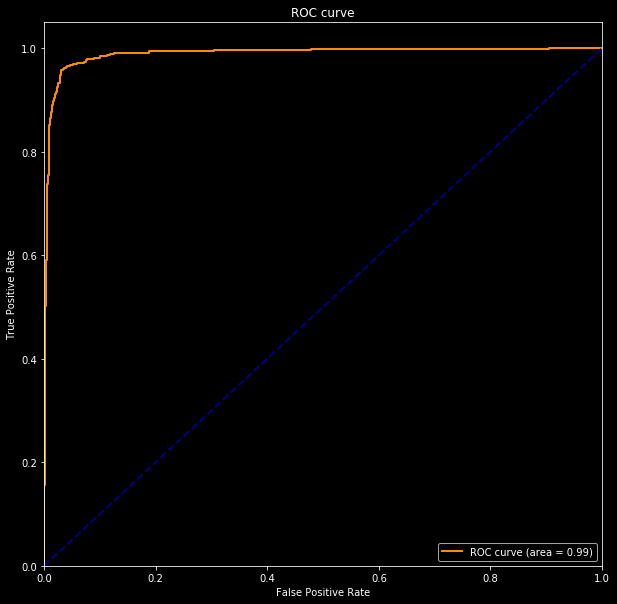

In [95]:
 tpr, fpr, threshold, roc_auc_ = make_roc_curves_array(true_vals=test_y, scores_vals=bayes_preds_proba[:,1])

In [96]:
df_test = pd.DataFrame(test_X)

In [97]:
df_test['y_true'] = test_y

In [98]:
df_test['xgb_bayes_proba_0'] = bayes_preds_proba[:,0]
df_test['xgb_bayes_proba_1'] = bayes_preds_proba[:,1]

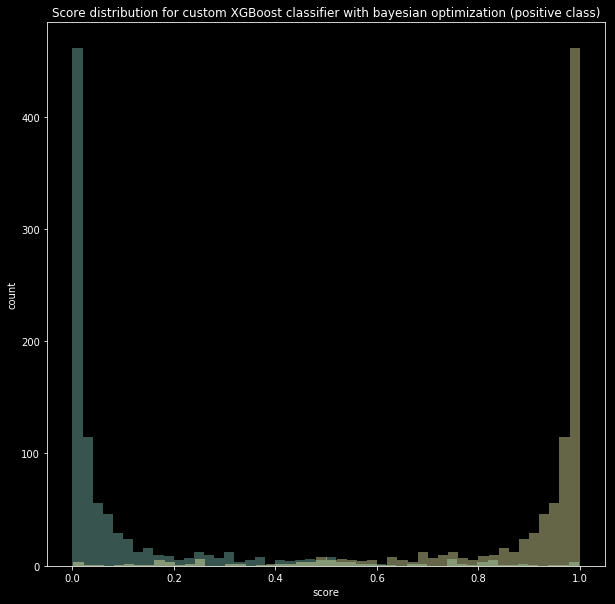

In [99]:
make_score_distribution(df=df_test, 
                        proba_cols=['xgb_bayes_proba_0', 'xgb_bayes_proba_1'], 
                        true_col='y_true', 
                        true_label=1, 
                        title='Score distribution for custom XGBoost classifier with bayesian optimization (positive class)')

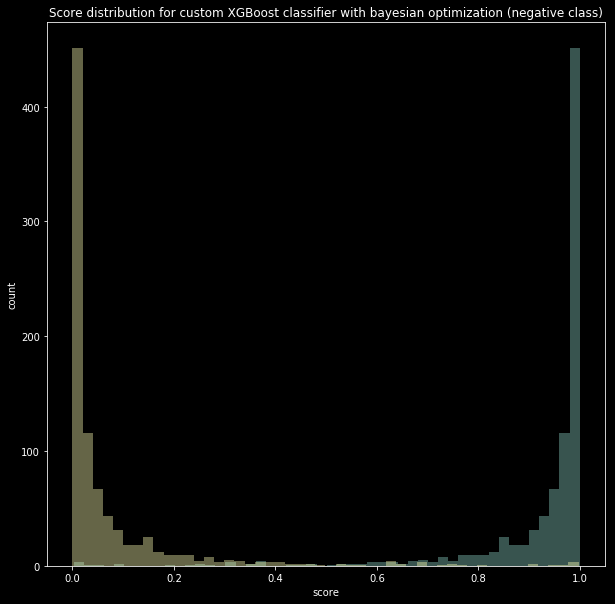

In [100]:
make_score_distribution(df=df_test, 
                        proba_cols=['xgb_bayes_proba_0', 'xgb_bayes_proba_1'], 
                        true_col='y_true', 
                        true_label=0, 
                        title='Score distribution for custom XGBoost classifier with bayesian optimization (negative class)')

In [101]:
# Try this out against a randomized search CV.
params_feature_select_xgb = EarlyStoppingClassifier(classifier=XGBClassifier(objective='binary:logistic', booster='gbtree', silent=True),
                                                    feature_selector=SelectKBest(score_func=mutual_info_classif),
                                                    evaluation_metric='logloss',
                                                    num_rounds=5)

In [102]:
# Probably better to sample learning rate from log-uniform domain.
param_grid = {'feature_selector__k': sp_randint(20, 45),
              'classifier__max_depth': sp_randint(3, 15),
              'classifier__min_child_weight': sp_randint(1, 5),
              'classifier__learning_rate': np.random.uniform(low=0.01, high=0.2, size=(100,)),
              'classifier__n_estimators': [1000],
              'classifier__colsample_bytree': np.random.uniform(low=0.7, high=1, size=(100,)),
              'classifier__subsample': np.random.uniform(low=0.7, high=1, size=(100,)),
              'classifier__seed': [0]}

In [103]:
# A random gridsearch.
model_gen_random = RandomizedSearchCV(estimator=params_feature_select_xgb, 
                                      param_distributions=param_grid, 
                                      cv=cv, 
                                      scoring='recall', 
                                      verbose=10, 
                                      iid=True, 
                                      refit=False, 
                                      n_iter=15)

In [104]:
model_gen_random.fit(train_X, train_y)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] classifier__colsample_bytree=0.763076465355132, classifier__subsample=0.8197048946026756, classifier__learning_rate=0.1862047587878104, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=24, classifier__min_child_weight=4, classifier__max_depth=5 
[0]	validation_0-logloss:0.635835
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.598154
[2]	validation_0-logloss:0.565821
[3]	validation_0-logloss:0.536595
[4]	validation_0-logloss:0.513526
[5]	validation_0-logloss:0.492955
[6]	validation_0-logloss:0.475574
[7]	validation_0-logloss:0.456829
[8]	validation_0-logloss:0.445167
[9]	validation_0-logloss:0.429634
[10]	validation_0-logloss:0.413321
[11]	validation_0-logloss:0.402637
[12]	validation_0-logloss:0.395903
[13]	validation_0-logloss:0.386922
[14]	validation_0-logloss:0.377062
[15]	validation_0-logloss:0.368737
[16]	validation_0-logloss:0.361704
[17]	validatio

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.0s remaining:    0.0s


[0]	validation_0-logloss:0.649527
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.609576
[2]	validation_0-logloss:0.571771
[3]	validation_0-logloss:0.545258
[4]	validation_0-logloss:0.520721
[5]	validation_0-logloss:0.497278
[6]	validation_0-logloss:0.477228
[7]	validation_0-logloss:0.469188
[8]	validation_0-logloss:0.457944
[9]	validation_0-logloss:0.443331
[10]	validation_0-logloss:0.431451
[11]	validation_0-logloss:0.420977
[12]	validation_0-logloss:0.412908
[13]	validation_0-logloss:0.405798
[14]	validation_0-logloss:0.398633
[15]	validation_0-logloss:0.392608
[16]	validation_0-logloss:0.387783
[17]	validation_0-logloss:0.382763
[18]	validation_0-logloss:0.378341
[19]	validation_0-logloss:0.375416
[20]	validation_0-logloss:0.370047
[21]	validation_0-logloss:0.36746
[22]	validation_0-logloss:0.36159
[23]	validation_0-logloss:0.357654
[24]	validation_0-logloss:0.355486
[25]	validation_0-logloss:0.353126
[26]	validation_0-logloss:0.348989


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.7s remaining:    0.0s


[0]	validation_0-logloss:0.634866
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.597359
[2]	validation_0-logloss:0.556925
[3]	validation_0-logloss:0.52811
[4]	validation_0-logloss:0.510152
[5]	validation_0-logloss:0.486745
[6]	validation_0-logloss:0.468657
[7]	validation_0-logloss:0.451144
[8]	validation_0-logloss:0.436118
[9]	validation_0-logloss:0.424083
[10]	validation_0-logloss:0.41027
[11]	validation_0-logloss:0.400847
[12]	validation_0-logloss:0.394985
[13]	validation_0-logloss:0.385587
[14]	validation_0-logloss:0.380838
[15]	validation_0-logloss:0.371028
[16]	validation_0-logloss:0.36125
[17]	validation_0-logloss:0.356297
[18]	validation_0-logloss:0.347097
[19]	validation_0-logloss:0.343037
[20]	validation_0-logloss:0.340054
[21]	validation_0-logloss:0.335778
[22]	validation_0-logloss:0.331185
[23]	validation_0-logloss:0.32902
[24]	validation_0-logloss:0.323697
[25]	validation_0-logloss:0.319606
[26]	validation_0-logloss:0.31524
[27

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.9s remaining:    0.0s


[0]	validation_0-logloss:0.645246
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.598233
[2]	validation_0-logloss:0.569538
[3]	validation_0-logloss:0.539719
[4]	validation_0-logloss:0.507993
[5]	validation_0-logloss:0.488244
[6]	validation_0-logloss:0.471413
[7]	validation_0-logloss:0.460474
[8]	validation_0-logloss:0.446729
[9]	validation_0-logloss:0.434563
[10]	validation_0-logloss:0.428724
[11]	validation_0-logloss:0.418077
[12]	validation_0-logloss:0.412055
[13]	validation_0-logloss:0.407726
[14]	validation_0-logloss:0.398915
[15]	validation_0-logloss:0.389442
[16]	validation_0-logloss:0.379555
[17]	validation_0-logloss:0.375187
[18]	validation_0-logloss:0.371859
[19]	validation_0-logloss:0.363673
[20]	validation_0-logloss:0.361739
[21]	validation_0-logloss:0.351994
[22]	validation_0-logloss:0.349051
[23]	validation_0-logloss:0.345515
[24]	validation_0-logloss:0.344814
[25]	validation_0-logloss:0.342244
[26]	validation_0-logloss:0.33584

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   15.6s remaining:    0.0s


[0]	validation_0-logloss:0.638907
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.595651
[2]	validation_0-logloss:0.565575
[3]	validation_0-logloss:0.534677
[4]	validation_0-logloss:0.515329
[5]	validation_0-logloss:0.493213
[6]	validation_0-logloss:0.474549
[7]	validation_0-logloss:0.460949
[8]	validation_0-logloss:0.4473
[9]	validation_0-logloss:0.437181
[10]	validation_0-logloss:0.425184
[11]	validation_0-logloss:0.416016
[12]	validation_0-logloss:0.409548
[13]	validation_0-logloss:0.400282
[14]	validation_0-logloss:0.395973
[15]	validation_0-logloss:0.391214
[16]	validation_0-logloss:0.385432
[17]	validation_0-logloss:0.382418
[18]	validation_0-logloss:0.374744
[19]	validation_0-logloss:0.366602
[20]	validation_0-logloss:0.361751
[21]	validation_0-logloss:0.358365
[22]	validation_0-logloss:0.354364
[23]	validation_0-logloss:0.350549
[24]	validation_0-logloss:0.348549
[25]	validation_0-logloss:0.344371
[26]	validation_0-logloss:0.342453


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.4s remaining:    0.0s


[0]	validation_0-logloss:0.623918
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.572877
[2]	validation_0-logloss:0.525602
[3]	validation_0-logloss:0.489264
[4]	validation_0-logloss:0.454161
[5]	validation_0-logloss:0.425272
[6]	validation_0-logloss:0.400998
[7]	validation_0-logloss:0.381057
[8]	validation_0-logloss:0.361751
[9]	validation_0-logloss:0.347868
[10]	validation_0-logloss:0.333614
[11]	validation_0-logloss:0.326032
[12]	validation_0-logloss:0.315061
[13]	validation_0-logloss:0.307801
[14]	validation_0-logloss:0.296601
[15]	validation_0-logloss:0.289496
[16]	validation_0-logloss:0.279871
[17]	validation_0-logloss:0.272999
[18]	validation_0-logloss:0.266843
[19]	validation_0-logloss:0.26084
[20]	validation_0-logloss:0.257829
[21]	validation_0-logloss:0.25159
[22]	validation_0-logloss:0.247307
[23]	validation_0-logloss:0.242374
[24]	validation_0-logloss:0.238358
[25]	validation_0-logloss:0.235503
[26]	validation_0-logloss:0.230764


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   25.6s remaining:    0.0s


[0]	validation_0-logloss:0.622345
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.567212
[2]	validation_0-logloss:0.525585
[3]	validation_0-logloss:0.493058
[4]	validation_0-logloss:0.465591
[5]	validation_0-logloss:0.444157
[6]	validation_0-logloss:0.416354
[7]	validation_0-logloss:0.401909
[8]	validation_0-logloss:0.3841
[9]	validation_0-logloss:0.369751
[10]	validation_0-logloss:0.354928
[11]	validation_0-logloss:0.343818
[12]	validation_0-logloss:0.333134
[13]	validation_0-logloss:0.319243
[14]	validation_0-logloss:0.309767
[15]	validation_0-logloss:0.304249
[16]	validation_0-logloss:0.29483
[17]	validation_0-logloss:0.290367
[18]	validation_0-logloss:0.285541
[19]	validation_0-logloss:0.27988
[20]	validation_0-logloss:0.274131
[21]	validation_0-logloss:0.27098
[22]	validation_0-logloss:0.267238
[23]	validation_0-logloss:0.264904
[24]	validation_0-logloss:0.262552
[25]	validation_0-logloss:0.260397
[26]	validation_0-logloss:0.254432
[27

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   31.0s remaining:    0.0s


[0]	validation_0-logloss:0.616253
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.562972
[2]	validation_0-logloss:0.523597
[3]	validation_0-logloss:0.489406
[4]	validation_0-logloss:0.457827
[5]	validation_0-logloss:0.431896
[6]	validation_0-logloss:0.414221
[7]	validation_0-logloss:0.394043
[8]	validation_0-logloss:0.376633
[9]	validation_0-logloss:0.362122
[10]	validation_0-logloss:0.345747
[11]	validation_0-logloss:0.331216
[12]	validation_0-logloss:0.320247
[13]	validation_0-logloss:0.313098
[14]	validation_0-logloss:0.305755
[15]	validation_0-logloss:0.295127
[16]	validation_0-logloss:0.287052
[17]	validation_0-logloss:0.277812
[18]	validation_0-logloss:0.271282
[19]	validation_0-logloss:0.265723
[20]	validation_0-logloss:0.262468
[21]	validation_0-logloss:0.257062
[22]	validation_0-logloss:0.252829
[23]	validation_0-logloss:0.249826
[24]	validation_0-logloss:0.247623
[25]	validation_0-logloss:0.243472
[26]	validation_0-logloss:0.23918

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   37.1s remaining:    0.0s


[0]	validation_0-logloss:0.625688
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.575115
[2]	validation_0-logloss:0.533959
[3]	validation_0-logloss:0.500157
[4]	validation_0-logloss:0.470018
[5]	validation_0-logloss:0.445071
[6]	validation_0-logloss:0.427752
[7]	validation_0-logloss:0.410245
[8]	validation_0-logloss:0.394673
[9]	validation_0-logloss:0.383037
[10]	validation_0-logloss:0.372299
[11]	validation_0-logloss:0.358821
[12]	validation_0-logloss:0.345554
[13]	validation_0-logloss:0.334226
[14]	validation_0-logloss:0.325698
[15]	validation_0-logloss:0.320212
[16]	validation_0-logloss:0.314529
[17]	validation_0-logloss:0.310073
[18]	validation_0-logloss:0.305104
[19]	validation_0-logloss:0.300715
[20]	validation_0-logloss:0.298005
[21]	validation_0-logloss:0.292998
[22]	validation_0-logloss:0.28768
[23]	validation_0-logloss:0.283042
[24]	validation_0-logloss:0.278731
[25]	validation_0-logloss:0.277581
[26]	validation_0-logloss:0.274887

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   42.5s remaining:    0.0s


[0]	validation_0-logloss:0.619091
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.562216
[2]	validation_0-logloss:0.512882
[3]	validation_0-logloss:0.481287
[4]	validation_0-logloss:0.447281
[5]	validation_0-logloss:0.420128
[6]	validation_0-logloss:0.401361
[7]	validation_0-logloss:0.383103
[8]	validation_0-logloss:0.369707
[9]	validation_0-logloss:0.353037
[10]	validation_0-logloss:0.340163
[11]	validation_0-logloss:0.32382
[12]	validation_0-logloss:0.313204
[13]	validation_0-logloss:0.303959
[14]	validation_0-logloss:0.29406
[15]	validation_0-logloss:0.287291
[16]	validation_0-logloss:0.279836
[17]	validation_0-logloss:0.273668
[18]	validation_0-logloss:0.266485
[19]	validation_0-logloss:0.262367
[20]	validation_0-logloss:0.256792
[21]	validation_0-logloss:0.252429
[22]	validation_0-logloss:0.250823
[23]	validation_0-logloss:0.2481
[24]	validation_0-logloss:0.244692
[25]	validation_0-logloss:0.241907
[26]	validation_0-logloss:0.238729
[2

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.657342
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.627628
[2]	validation_0-logloss:0.605241
[3]	validation_0-logloss:0.584343
[4]	validation_0-logloss:0.569472
[5]	validation_0-logloss:0.553802
[6]	validation_0-logloss:0.538198
[7]	validation_0-logloss:0.525759
[8]	validation_0-logloss:0.511413
[9]	validation_0-logloss:0.499784
[10]	validation_0-logloss:0.488096
[11]	validation_0-logloss:0.478813
[12]	validation_0-logloss:0.468988
[13]	validation_0-logloss:0.460378
[14]	validation_0-logloss:0.452022
[15]	validation_0-logloss:0.448263
[16]	validation_0-logloss:0.442474
[17]	validation_0-logloss:0.434593
[18]	validation_0-logloss:0.428982
[19]	validation_0-logloss:0.424181
[20]	validation_0-logloss:0.422048
[21]	validation_0-logloss:0.416345
[22]	validation_0-logloss:0.411466
[23]	validation_0-logloss:0.408382
[24]	validation_0-logloss:0.404593
[25]	validation_0-logloss:0.401526
[26]	validation_0-logloss:0.39796

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.655739
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.625629
[2]	validation_0-logloss:0.60067
[3]	validation_0-logloss:0.580592
[4]	validation_0-logloss:0.561533
[5]	validation_0-logloss:0.550402
[6]	validation_0-logloss:0.536806
[7]	validation_0-logloss:0.524087
[8]	validation_0-logloss:0.514681
[9]	validation_0-logloss:0.503016
[10]	validation_0-logloss:0.488925
[11]	validation_0-logloss:0.481132
[12]	validation_0-logloss:0.471526
[13]	validation_0-logloss:0.463276
[14]	validation_0-logloss:0.454678
[15]	validation_0-logloss:0.446639
[16]	validation_0-logloss:0.439082
[17]	validation_0-logloss:0.43455
[18]	validation_0-logloss:0.427362
[19]	validation_0-logloss:0.421294
[20]	validation_0-logloss:0.414226
[21]	validation_0-logloss:0.407908
[22]	validation_0-logloss:0.402268
[23]	validation_0-logloss:0.395624
[24]	validation_0-logloss:0.392752
[25]	validation_0-logloss:0.385884
[26]	validation_0-logloss:0.382211


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.649834
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.62448
[2]	validation_0-logloss:0.600899
[3]	validation_0-logloss:0.585313
[4]	validation_0-logloss:0.565869
[5]	validation_0-logloss:0.5499
[6]	validation_0-logloss:0.533081
[7]	validation_0-logloss:0.520339
[8]	validation_0-logloss:0.508244
[9]	validation_0-logloss:0.492037
[10]	validation_0-logloss:0.480647
[11]	validation_0-logloss:0.469531
[12]	validation_0-logloss:0.45639
[13]	validation_0-logloss:0.447305
[14]	validation_0-logloss:0.438978
[15]	validation_0-logloss:0.430837
[16]	validation_0-logloss:0.423657
[17]	validation_0-logloss:0.416605
[18]	validation_0-logloss:0.409834
[19]	validation_0-logloss:0.405881
[20]	validation_0-logloss:0.399454
[21]	validation_0-logloss:0.393364
[22]	validation_0-logloss:0.387802
[23]	validation_0-logloss:0.38578
[24]	validation_0-logloss:0.381178
[25]	validation_0-logloss:0.376739
[26]	validation_0-logloss:0.371751
[27

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.658764
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.633525
[2]	validation_0-logloss:0.603141
[3]	validation_0-logloss:0.585682
[4]	validation_0-logloss:0.567653
[5]	validation_0-logloss:0.548233
[6]	validation_0-logloss:0.532482
[7]	validation_0-logloss:0.517767
[8]	validation_0-logloss:0.501298
[9]	validation_0-logloss:0.492409
[10]	validation_0-logloss:0.482786
[11]	validation_0-logloss:0.473382
[12]	validation_0-logloss:0.465021
[13]	validation_0-logloss:0.456437
[14]	validation_0-logloss:0.447763
[15]	validation_0-logloss:0.439436
[16]	validation_0-logloss:0.430328
[17]	validation_0-logloss:0.425408
[18]	validation_0-logloss:0.420448
[19]	validation_0-logloss:0.413924
[20]	validation_0-logloss:0.406517
[21]	validation_0-logloss:0.399593
[22]	validation_0-logloss:0.394738
[23]	validation_0-logloss:0.392812
[24]	validation_0-logloss:0.388075
[25]	validation_0-logloss:0.381698
[26]	validation_0-logloss:0.37767

Stopping. Best iteration:
[224]	validation_0-logloss:0.213858

[CV]  classifier__colsample_bytree=0.8133058042731366, classifier__subsample=0.8672216794603732, classifier__learning_rate=0.14327620989757517, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=28, classifier__min_child_weight=1, classifier__max_depth=4, score=0.897902097902, total=   5.2s
[CV] classifier__colsample_bytree=0.8133058042731366, classifier__subsample=0.8672216794603732, classifier__learning_rate=0.14327620989757517, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=28, classifier__min_child_weight=1, classifier__max_depth=4 


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.652279
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.624303
[2]	validation_0-logloss:0.598078
[3]	validation_0-logloss:0.576009
[4]	validation_0-logloss:0.559444
[5]	validation_0-logloss:0.540936
[6]	validation_0-logloss:0.523935
[7]	validation_0-logloss:0.512493
[8]	validation_0-logloss:0.500048
[9]	validation_0-logloss:0.486172
[10]	validation_0-logloss:0.476096
[11]	validation_0-logloss:0.464179
[12]	validation_0-logloss:0.4582
[13]	validation_0-logloss:0.449361
[14]	validation_0-logloss:0.440672
[15]	validation_0-logloss:0.433207
[16]	validation_0-logloss:0.427054
[17]	validation_0-logloss:0.419865
[18]	validation_0-logloss:0.412081
[19]	validation_0-logloss:0.404696
[20]	validation_0-logloss:0.396894
[21]	validation_0-logloss:0.390933
[22]	validation_0-logloss:0.38618
[23]	validation_0-logloss:0.381095
[24]	validation_0-logloss:0.375189
[25]	validation_0-logloss:0.371073
[26]	validation_0-logloss:0.367718
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.681891
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.672221
[2]	validation_0-logloss:0.661186
[3]	validation_0-logloss:0.651523
[4]	validation_0-logloss:0.642429
[5]	validation_0-logloss:0.632521
[6]	validation_0-logloss:0.62259
[7]	validation_0-logloss:0.614051
[8]	validation_0-logloss:0.605799
[9]	validation_0-logloss:0.598085
[10]	validation_0-logloss:0.590319
[11]	validation_0-logloss:0.583047
[12]	validation_0-logloss:0.576106
[13]	validation_0-logloss:0.569191
[14]	validation_0-logloss:0.561938
[15]	validation_0-logloss:0.554682
[16]	validation_0-logloss:0.547743
[17]	validation_0-logloss:0.541079
[18]	validation_0-logloss:0.534915
[19]	validation_0-logloss:0.528573
[20]	validation_0-logloss:0.522777
[21]	validation_0-logloss:0.517332
[22]	validation_0-logloss:0.511604
[23]	validation_0-logloss:0.50601
[24]	validation_0-logloss:0.500773
[25]	validation_0-logloss:0.494894
[26]	validation_0-logloss:0.490449


[230]	validation_0-logloss:0.226231
[231]	validation_0-logloss:0.226131
[232]	validation_0-logloss:0.225867
[233]	validation_0-logloss:0.225616
[234]	validation_0-logloss:0.225531
[235]	validation_0-logloss:0.22543
[236]	validation_0-logloss:0.225215
[237]	validation_0-logloss:0.225092
[238]	validation_0-logloss:0.224901
[239]	validation_0-logloss:0.224548
[240]	validation_0-logloss:0.224381
[241]	validation_0-logloss:0.224148
[242]	validation_0-logloss:0.223708
[243]	validation_0-logloss:0.223672
[244]	validation_0-logloss:0.223428
[245]	validation_0-logloss:0.223119
[246]	validation_0-logloss:0.222749
[247]	validation_0-logloss:0.222586
[248]	validation_0-logloss:0.222385
[249]	validation_0-logloss:0.222009
[250]	validation_0-logloss:0.221671
[251]	validation_0-logloss:0.221424
[252]	validation_0-logloss:0.221256
[253]	validation_0-logloss:0.221226
[254]	validation_0-logloss:0.221121
[255]	validation_0-logloss:0.220893
[256]	validation_0-logloss:0.220553
[257]	validation_0-logloss:0.

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  classifier__colsample_bytree=0.8469806051466461, classifier__subsample=0.9723301844696816, classifier__learning_rate=0.024904210026907, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=23, classifier__min_child_weight=2, classifier__max_depth=13, score=0.918994413408, total=  14.5s
[CV] classifier__colsample_bytree=0.8469806051466461, classifier__subsample=0.9723301844696816, classifier__learning_rate=0.024904210026907, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=23, classifier__min_child_weight=2, classifier__max_depth=13 
[0]	validation_0-logloss:0.683595
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.673954
[2]	validation_0-logloss:0.663537
[3]	validation_0-logloss:0.655292
[4]	validation_0-logloss:0.645823
[5]	validation_0-logloss:0.637177
[6]	validation_0-logloss:0.629114
[7]	validation_0-logloss:0.621651
[8]	validation_0-logloss:0.614222
[9]	validation_0-logloss:0.606905
[10]	val

[214]	validation_0-logloss:0.252199
[215]	validation_0-logloss:0.251878
[216]	validation_0-logloss:0.251554
[217]	validation_0-logloss:0.251238
[218]	validation_0-logloss:0.250685
[219]	validation_0-logloss:0.250457
[220]	validation_0-logloss:0.250175
[221]	validation_0-logloss:0.249889
[222]	validation_0-logloss:0.249391
[223]	validation_0-logloss:0.248928
[224]	validation_0-logloss:0.248677
[225]	validation_0-logloss:0.248555
[226]	validation_0-logloss:0.248059
[227]	validation_0-logloss:0.247846
[228]	validation_0-logloss:0.247403
[229]	validation_0-logloss:0.247326
[230]	validation_0-logloss:0.246917
[231]	validation_0-logloss:0.246489
[232]	validation_0-logloss:0.246294
[233]	validation_0-logloss:0.245867
[234]	validation_0-logloss:0.245658
[235]	validation_0-logloss:0.245568
[236]	validation_0-logloss:0.245367
[237]	validation_0-logloss:0.24508
[238]	validation_0-logloss:0.244885
[239]	validation_0-logloss:0.24467
[240]	validation_0-logloss:0.244359
[241]	validation_0-logloss:0.2

[443]	validation_0-logloss:0.211315
[444]	validation_0-logloss:0.211222
[445]	validation_0-logloss:0.211177
[446]	validation_0-logloss:0.211209
[447]	validation_0-logloss:0.21117
[448]	validation_0-logloss:0.211075
[449]	validation_0-logloss:0.210925
[450]	validation_0-logloss:0.210934
[451]	validation_0-logloss:0.210815
[452]	validation_0-logloss:0.210742
[453]	validation_0-logloss:0.210783
[454]	validation_0-logloss:0.210621
[455]	validation_0-logloss:0.210689
[456]	validation_0-logloss:0.210546
[457]	validation_0-logloss:0.210469
[458]	validation_0-logloss:0.210406
[459]	validation_0-logloss:0.21034
[460]	validation_0-logloss:0.21024
[461]	validation_0-logloss:0.210239
[462]	validation_0-logloss:0.210126
[463]	validation_0-logloss:0.21005
[464]	validation_0-logloss:0.21001
[465]	validation_0-logloss:0.209887
[466]	validation_0-logloss:0.209657
[467]	validation_0-logloss:0.209627
[468]	validation_0-logloss:0.209531
[469]	validation_0-logloss:0.209459
[470]	validation_0-logloss:0.2094

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  classifier__colsample_bytree=0.8469806051466461, classifier__subsample=0.9723301844696816, classifier__learning_rate=0.024904210026907, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=23, classifier__min_child_weight=2, classifier__max_depth=13, score=0.914804469274, total=  15.8s
[CV] classifier__colsample_bytree=0.8469806051466461, classifier__subsample=0.9723301844696816, classifier__learning_rate=0.024904210026907, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=23, classifier__min_child_weight=2, classifier__max_depth=13 
[0]	validation_0-logloss:0.682845
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.67314
[2]	validation_0-logloss:0.664524
[3]	validation_0-logloss:0.656414
[4]	validation_0-logloss:0.647799
[5]	validation_0-logloss:0.639373
[6]	validation_0-logloss:0.631213
[7]	validation_0-logloss:0.623557
[8]	validation_0-logloss:0.616466
[9]	validation_0-logloss:0.609147
[10]	vali

[214]	validation_0-logloss:0.269795
[215]	validation_0-logloss:0.269627
[216]	validation_0-logloss:0.269223
[217]	validation_0-logloss:0.268845
[218]	validation_0-logloss:0.268606
[219]	validation_0-logloss:0.26814
[220]	validation_0-logloss:0.267777
[221]	validation_0-logloss:0.267686
[222]	validation_0-logloss:0.267435
[223]	validation_0-logloss:0.267098
[224]	validation_0-logloss:0.266544
[225]	validation_0-logloss:0.266091
[226]	validation_0-logloss:0.265864
[227]	validation_0-logloss:0.265651
[228]	validation_0-logloss:0.265197
[229]	validation_0-logloss:0.264784
[230]	validation_0-logloss:0.264484
[231]	validation_0-logloss:0.263999
[232]	validation_0-logloss:0.263569
[233]	validation_0-logloss:0.263207
[234]	validation_0-logloss:0.262737
[235]	validation_0-logloss:0.262309
[236]	validation_0-logloss:0.261769
[237]	validation_0-logloss:0.26129
[238]	validation_0-logloss:0.260943
[239]	validation_0-logloss:0.260737
[240]	validation_0-logloss:0.26034
[241]	validation_0-logloss:0.25

[443]	validation_0-logloss:0.228385
[444]	validation_0-logloss:0.228153
[445]	validation_0-logloss:0.228046
[446]	validation_0-logloss:0.22792
[447]	validation_0-logloss:0.227846
[448]	validation_0-logloss:0.227762
[449]	validation_0-logloss:0.227595
[450]	validation_0-logloss:0.227358
[451]	validation_0-logloss:0.227064
[452]	validation_0-logloss:0.226854
[453]	validation_0-logloss:0.226694
[454]	validation_0-logloss:0.226643
[455]	validation_0-logloss:0.226605
[456]	validation_0-logloss:0.226549
[457]	validation_0-logloss:0.226548
[458]	validation_0-logloss:0.226496
[459]	validation_0-logloss:0.2266
[460]	validation_0-logloss:0.226589
[461]	validation_0-logloss:0.226694
[462]	validation_0-logloss:0.226662
[463]	validation_0-logloss:0.226588
Stopping. Best iteration:
[458]	validation_0-logloss:0.226496



/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  classifier__colsample_bytree=0.8469806051466461, classifier__subsample=0.9723301844696816, classifier__learning_rate=0.024904210026907, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=23, classifier__min_child_weight=2, classifier__max_depth=13, score=0.900837988827, total=  15.5s
[CV] classifier__colsample_bytree=0.8469806051466461, classifier__subsample=0.9723301844696816, classifier__learning_rate=0.024904210026907, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=23, classifier__min_child_weight=2, classifier__max_depth=13 
[0]	validation_0-logloss:0.681666
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.67053
[2]	validation_0-logloss:0.660002
[3]	validation_0-logloss:0.651158
[4]	validation_0-logloss:0.640847
[5]	validation_0-logloss:0.632327
[6]	validation_0-logloss:0.624084
[7]	validation_0-logloss:0.61591
[8]	validation_0-logloss:0.607609
[9]	validation_0-logloss:0.598549
[10]	valid

[214]	validation_0-logloss:0.255464
[215]	validation_0-logloss:0.255107
[216]	validation_0-logloss:0.254927
[217]	validation_0-logloss:0.254461
[218]	validation_0-logloss:0.254239
[219]	validation_0-logloss:0.253966
[220]	validation_0-logloss:0.25382
[221]	validation_0-logloss:0.25387
[222]	validation_0-logloss:0.253683
[223]	validation_0-logloss:0.25359
[224]	validation_0-logloss:0.253021
[225]	validation_0-logloss:0.252644
[226]	validation_0-logloss:0.252243
[227]	validation_0-logloss:0.251906
[228]	validation_0-logloss:0.251734
[229]	validation_0-logloss:0.251539
[230]	validation_0-logloss:0.251317
[231]	validation_0-logloss:0.250883
[232]	validation_0-logloss:0.250314
[233]	validation_0-logloss:0.249893
[234]	validation_0-logloss:0.249625
[235]	validation_0-logloss:0.249318
[236]	validation_0-logloss:0.249247
[237]	validation_0-logloss:0.249055
[238]	validation_0-logloss:0.248907
[239]	validation_0-logloss:0.248589
[240]	validation_0-logloss:0.248606
[241]	validation_0-logloss:0.24

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  classifier__colsample_bytree=0.8469806051466461, classifier__subsample=0.9723301844696816, classifier__learning_rate=0.024904210026907, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=23, classifier__min_child_weight=2, classifier__max_depth=13, score=0.907692307692, total=  13.9s
[CV] classifier__colsample_bytree=0.8469806051466461, classifier__subsample=0.9723301844696816, classifier__learning_rate=0.024904210026907, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=23, classifier__min_child_weight=2, classifier__max_depth=13 
[0]	validation_0-logloss:0.684958
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.676911
[2]	validation_0-logloss:0.667737
[3]	validation_0-logloss:0.658922
[4]	validation_0-logloss:0.649967
[5]	validation_0-logloss:0.641093
[6]	validation_0-logloss:0.632692
[7]	validation_0-logloss:0.624063
[8]	validation_0-logloss:0.617739
[9]	validation_0-logloss:0.609884
[10]	val

[214]	validation_0-logloss:0.266586
[215]	validation_0-logloss:0.2663
[216]	validation_0-logloss:0.265852
[217]	validation_0-logloss:0.265277
[218]	validation_0-logloss:0.264731
[219]	validation_0-logloss:0.264099
[220]	validation_0-logloss:0.263657
[221]	validation_0-logloss:0.2631
[222]	validation_0-logloss:0.262877
[223]	validation_0-logloss:0.262472
[224]	validation_0-logloss:0.262174
[225]	validation_0-logloss:0.26171
[226]	validation_0-logloss:0.261281
[227]	validation_0-logloss:0.260846
[228]	validation_0-logloss:0.260671
[229]	validation_0-logloss:0.260346
[230]	validation_0-logloss:0.260434
[231]	validation_0-logloss:0.260038
[232]	validation_0-logloss:0.259884
[233]	validation_0-logloss:0.259605
[234]	validation_0-logloss:0.259323
[235]	validation_0-logloss:0.259086
[236]	validation_0-logloss:0.258871
[237]	validation_0-logloss:0.258678
[238]	validation_0-logloss:0.258428
[239]	validation_0-logloss:0.258212
[240]	validation_0-logloss:0.257698
[241]	validation_0-logloss:0.2574

[443]	validation_0-logloss:0.223671
[444]	validation_0-logloss:0.223546
[445]	validation_0-logloss:0.22337
[446]	validation_0-logloss:0.223407
[447]	validation_0-logloss:0.2233
[448]	validation_0-logloss:0.223356
[449]	validation_0-logloss:0.223198
[450]	validation_0-logloss:0.223214
[451]	validation_0-logloss:0.223073
[452]	validation_0-logloss:0.222993
[453]	validation_0-logloss:0.222973
[454]	validation_0-logloss:0.222993
[455]	validation_0-logloss:0.222896
[456]	validation_0-logloss:0.222775
[457]	validation_0-logloss:0.22267
[458]	validation_0-logloss:0.222733
[459]	validation_0-logloss:0.222712
[460]	validation_0-logloss:0.222514
[461]	validation_0-logloss:0.222322
[462]	validation_0-logloss:0.222159
[463]	validation_0-logloss:0.222189
[464]	validation_0-logloss:0.22221
[465]	validation_0-logloss:0.222169
[466]	validation_0-logloss:0.222046
[467]	validation_0-logloss:0.221853
[468]	validation_0-logloss:0.221681
[469]	validation_0-logloss:0.221574
[470]	validation_0-logloss:0.2213

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  classifier__colsample_bytree=0.8469806051466461, classifier__subsample=0.9723301844696816, classifier__learning_rate=0.024904210026907, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=23, classifier__min_child_weight=2, classifier__max_depth=13, score=0.91048951049, total=  16.8s
[CV] classifier__colsample_bytree=0.9481959032130445, classifier__subsample=0.9380303202603271, classifier__learning_rate=0.12915731617337997, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=28, classifier__min_child_weight=2, classifier__max_depth=8 
[0]	validation_0-logloss:0.633028
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.58522
[2]	validation_0-logloss:0.547508
[3]	validation_0-logloss:0.51231
[4]	validation_0-logloss:0.487077
[5]	validation_0-logloss:0.46504
[6]	validation_0-logloss:0.445076
[7]	validation_0-logloss:0.42433
[8]	validation_0-logloss:0.408157
[9]	validation_0-logloss:0.394435
[10]	validat

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.639545
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.597074
[2]	validation_0-logloss:0.561766
[3]	validation_0-logloss:0.527745
[4]	validation_0-logloss:0.50071
[5]	validation_0-logloss:0.482131
[6]	validation_0-logloss:0.459389
[7]	validation_0-logloss:0.441036
[8]	validation_0-logloss:0.423151
[9]	validation_0-logloss:0.4057
[10]	validation_0-logloss:0.389504
[11]	validation_0-logloss:0.372913
[12]	validation_0-logloss:0.358156
[13]	validation_0-logloss:0.347261
[14]	validation_0-logloss:0.335784
[15]	validation_0-logloss:0.325037
[16]	validation_0-logloss:0.317047
[17]	validation_0-logloss:0.307711
[18]	validation_0-logloss:0.299102
[19]	validation_0-logloss:0.293369
[20]	validation_0-logloss:0.287327
[21]	validation_0-logloss:0.282854
[22]	validation_0-logloss:0.278062
[23]	validation_0-logloss:0.27427
[24]	validation_0-logloss:0.271349
[25]	validation_0-logloss:0.267391
[26]	validation_0-logloss:0.2646
[27]

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.635142
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.592366
[2]	validation_0-logloss:0.558713
[3]	validation_0-logloss:0.528786
[4]	validation_0-logloss:0.500758
[5]	validation_0-logloss:0.477641
[6]	validation_0-logloss:0.457
[7]	validation_0-logloss:0.440187
[8]	validation_0-logloss:0.425198
[9]	validation_0-logloss:0.411655
[10]	validation_0-logloss:0.398192
[11]	validation_0-logloss:0.387165
[12]	validation_0-logloss:0.377969
[13]	validation_0-logloss:0.368899
[14]	validation_0-logloss:0.359058
[15]	validation_0-logloss:0.352496
[16]	validation_0-logloss:0.345155
[17]	validation_0-logloss:0.336877
[18]	validation_0-logloss:0.330279
[19]	validation_0-logloss:0.324933
[20]	validation_0-logloss:0.318733
[21]	validation_0-logloss:0.31331
[22]	validation_0-logloss:0.308424
[23]	validation_0-logloss:0.303666
[24]	validation_0-logloss:0.299685
[25]	validation_0-logloss:0.295625
[26]	validation_0-logloss:0.290892
[2

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.645122
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.602897
[2]	validation_0-logloss:0.568173
[3]	validation_0-logloss:0.540158
[4]	validation_0-logloss:0.514434
[5]	validation_0-logloss:0.491162
[6]	validation_0-logloss:0.474905
[7]	validation_0-logloss:0.455821
[8]	validation_0-logloss:0.440911
[9]	validation_0-logloss:0.426739
[10]	validation_0-logloss:0.414763
[11]	validation_0-logloss:0.405654
[12]	validation_0-logloss:0.394717
[13]	validation_0-logloss:0.384796
[14]	validation_0-logloss:0.374744
[15]	validation_0-logloss:0.364654
[16]	validation_0-logloss:0.35696
[17]	validation_0-logloss:0.351494
[18]	validation_0-logloss:0.345903
[19]	validation_0-logloss:0.337282
[20]	validation_0-logloss:0.332654
[21]	validation_0-logloss:0.330212
[22]	validation_0-logloss:0.324271
[23]	validation_0-logloss:0.318329
[24]	validation_0-logloss:0.314323
[25]	validation_0-logloss:0.308337
[26]	validation_0-logloss:0.304576

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.635727
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.590322
[2]	validation_0-logloss:0.555122
[3]	validation_0-logloss:0.518579
[4]	validation_0-logloss:0.492374
[5]	validation_0-logloss:0.470213
[6]	validation_0-logloss:0.449094
[7]	validation_0-logloss:0.427241
[8]	validation_0-logloss:0.412296
[9]	validation_0-logloss:0.397282
[10]	validation_0-logloss:0.385485
[11]	validation_0-logloss:0.375902
[12]	validation_0-logloss:0.3662
[13]	validation_0-logloss:0.355265
[14]	validation_0-logloss:0.343651
[15]	validation_0-logloss:0.335566
[16]	validation_0-logloss:0.326948
[17]	validation_0-logloss:0.319772
[18]	validation_0-logloss:0.311651
[19]	validation_0-logloss:0.30582
[20]	validation_0-logloss:0.298773
[21]	validation_0-logloss:0.292706
[22]	validation_0-logloss:0.287352
[23]	validation_0-logloss:0.28318
[24]	validation_0-logloss:0.277892
[25]	validation_0-logloss:0.273914
[26]	validation_0-logloss:0.270143
[2

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.640568
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.594062
[2]	validation_0-logloss:0.562652
[3]	validation_0-logloss:0.528707
[4]	validation_0-logloss:0.500675
[5]	validation_0-logloss:0.477158
[6]	validation_0-logloss:0.45499
[7]	validation_0-logloss:0.43455
[8]	validation_0-logloss:0.417161
[9]	validation_0-logloss:0.401348
[10]	validation_0-logloss:0.387996
[11]	validation_0-logloss:0.374204
[12]	validation_0-logloss:0.360474
[13]	validation_0-logloss:0.351157
[14]	validation_0-logloss:0.338511
[15]	validation_0-logloss:0.328403
[16]	validation_0-logloss:0.318819
[17]	validation_0-logloss:0.31033
[18]	validation_0-logloss:0.30283
[19]	validation_0-logloss:0.297549
[20]	validation_0-logloss:0.291722
[21]	validation_0-logloss:0.284915
[22]	validation_0-logloss:0.279785
[23]	validation_0-logloss:0.274788
[24]	validation_0-logloss:0.268763
[25]	validation_0-logloss:0.265309
[26]	validation_0-logloss:0.262119
[2

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.638931
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.59795
[2]	validation_0-logloss:0.565561
[3]	validation_0-logloss:0.53596
[4]	validation_0-logloss:0.508724
[5]	validation_0-logloss:0.482455
[6]	validation_0-logloss:0.46175
[7]	validation_0-logloss:0.443105
[8]	validation_0-logloss:0.426127
[9]	validation_0-logloss:0.411838
[10]	validation_0-logloss:0.397149
[11]	validation_0-logloss:0.383231
[12]	validation_0-logloss:0.370859
[13]	validation_0-logloss:0.361498
[14]	validation_0-logloss:0.350593
[15]	validation_0-logloss:0.342704
[16]	validation_0-logloss:0.332937
[17]	validation_0-logloss:0.324491
[18]	validation_0-logloss:0.315548
[19]	validation_0-logloss:0.306319
[20]	validation_0-logloss:0.298265
[21]	validation_0-logloss:0.28991
[22]	validation_0-logloss:0.28391
[23]	validation_0-logloss:0.27771
[24]	validation_0-logloss:0.270071
[25]	validation_0-logloss:0.266311
[26]	validation_0-logloss:0.260731
[27]

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.648096
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.5989
[2]	validation_0-logloss:0.556958
[3]	validation_0-logloss:0.528647
[4]	validation_0-logloss:0.501766
[5]	validation_0-logloss:0.47752
[6]	validation_0-logloss:0.453778
[7]	validation_0-logloss:0.432385
[8]	validation_0-logloss:0.41448
[9]	validation_0-logloss:0.399169
[10]	validation_0-logloss:0.38517
[11]	validation_0-logloss:0.372433
[12]	validation_0-logloss:0.36034
[13]	validation_0-logloss:0.347691
[14]	validation_0-logloss:0.33685
[15]	validation_0-logloss:0.327862
[16]	validation_0-logloss:0.319143
[17]	validation_0-logloss:0.309918
[18]	validation_0-logloss:0.30235
[19]	validation_0-logloss:0.294936
[20]	validation_0-logloss:0.288221
[21]	validation_0-logloss:0.28202
[22]	validation_0-logloss:0.277477
[23]	validation_0-logloss:0.270465
[24]	validation_0-logloss:0.264933
[25]	validation_0-logloss:0.261389
[26]	validation_0-logloss:0.256655
[27]	va

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.64584
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.603858
[2]	validation_0-logloss:0.563842
[3]	validation_0-logloss:0.532568
[4]	validation_0-logloss:0.502821
[5]	validation_0-logloss:0.479066
[6]	validation_0-logloss:0.458249
[7]	validation_0-logloss:0.435654
[8]	validation_0-logloss:0.41895
[9]	validation_0-logloss:0.400871
[10]	validation_0-logloss:0.384427
[11]	validation_0-logloss:0.373046
[12]	validation_0-logloss:0.360503
[13]	validation_0-logloss:0.351279
[14]	validation_0-logloss:0.34198
[15]	validation_0-logloss:0.330263
[16]	validation_0-logloss:0.322839
[17]	validation_0-logloss:0.3145
[18]	validation_0-logloss:0.307506
[19]	validation_0-logloss:0.300149
[20]	validation_0-logloss:0.293772
[21]	validation_0-logloss:0.28986
[22]	validation_0-logloss:0.283976
[23]	validation_0-logloss:0.277917
[24]	validation_0-logloss:0.271935
[25]	validation_0-logloss:0.26637
[26]	validation_0-logloss:0.260361
[27]	

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.642301
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.598069
[2]	validation_0-logloss:0.557802
[3]	validation_0-logloss:0.523694
[4]	validation_0-logloss:0.499504
[5]	validation_0-logloss:0.475891
[6]	validation_0-logloss:0.457407
[7]	validation_0-logloss:0.437175
[8]	validation_0-logloss:0.419334
[9]	validation_0-logloss:0.401567
[10]	validation_0-logloss:0.382284
[11]	validation_0-logloss:0.369453
[12]	validation_0-logloss:0.35751
[13]	validation_0-logloss:0.347339
[14]	validation_0-logloss:0.336432
[15]	validation_0-logloss:0.327464
[16]	validation_0-logloss:0.318324
[17]	validation_0-logloss:0.309584
[18]	validation_0-logloss:0.303739
[19]	validation_0-logloss:0.296178
[20]	validation_0-logloss:0.29024
[21]	validation_0-logloss:0.282476
[22]	validation_0-logloss:0.276168
[23]	validation_0-logloss:0.270299
[24]	validation_0-logloss:0.265612
[25]	validation_0-logloss:0.260646
[26]	validation_0-logloss:0.255063


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.670441
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.649888
[2]	validation_0-logloss:0.626708
[3]	validation_0-logloss:0.609351
[4]	validation_0-logloss:0.592785
[5]	validation_0-logloss:0.577114
[6]	validation_0-logloss:0.561599
[7]	validation_0-logloss:0.548239
[8]	validation_0-logloss:0.53426
[9]	validation_0-logloss:0.522186
[10]	validation_0-logloss:0.511765
[11]	validation_0-logloss:0.500964
[12]	validation_0-logloss:0.490204
[13]	validation_0-logloss:0.479814
[14]	validation_0-logloss:0.470648
[15]	validation_0-logloss:0.462657
[16]	validation_0-logloss:0.453741
[17]	validation_0-logloss:0.446705
[18]	validation_0-logloss:0.438218
[19]	validation_0-logloss:0.431891
[20]	validation_0-logloss:0.424774
[21]	validation_0-logloss:0.418587
[22]	validation_0-logloss:0.413014
[23]	validation_0-logloss:0.408605
[24]	validation_0-logloss:0.40346
[25]	validation_0-logloss:0.397674
[26]	validation_0-logloss:0.391387


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.671969
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.650455
[2]	validation_0-logloss:0.630977
[3]	validation_0-logloss:0.612743
[4]	validation_0-logloss:0.595939
[5]	validation_0-logloss:0.579232
[6]	validation_0-logloss:0.566303
[7]	validation_0-logloss:0.552302
[8]	validation_0-logloss:0.539029
[9]	validation_0-logloss:0.526536
[10]	validation_0-logloss:0.51607
[11]	validation_0-logloss:0.505773
[12]	validation_0-logloss:0.497085
[13]	validation_0-logloss:0.488623
[14]	validation_0-logloss:0.480079
[15]	validation_0-logloss:0.469944
[16]	validation_0-logloss:0.461535
[17]	validation_0-logloss:0.452633
[18]	validation_0-logloss:0.443232
[19]	validation_0-logloss:0.436674
[20]	validation_0-logloss:0.430389
[21]	validation_0-logloss:0.423535
[22]	validation_0-logloss:0.416631
[23]	validation_0-logloss:0.40871
[24]	validation_0-logloss:0.402834
[25]	validation_0-logloss:0.397527
[26]	validation_0-logloss:0.392608


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.668213
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.647834
[2]	validation_0-logloss:0.626854
[3]	validation_0-logloss:0.610319
[4]	validation_0-logloss:0.594557
[5]	validation_0-logloss:0.580257
[6]	validation_0-logloss:0.565657
[7]	validation_0-logloss:0.552977
[8]	validation_0-logloss:0.540128
[9]	validation_0-logloss:0.527843
[10]	validation_0-logloss:0.518427
[11]	validation_0-logloss:0.508446
[12]	validation_0-logloss:0.499969
[13]	validation_0-logloss:0.491147
[14]	validation_0-logloss:0.48196
[15]	validation_0-logloss:0.473534
[16]	validation_0-logloss:0.467422
[17]	validation_0-logloss:0.461564
[18]	validation_0-logloss:0.454004
[19]	validation_0-logloss:0.446961
[20]	validation_0-logloss:0.441692
[21]	validation_0-logloss:0.434994
[22]	validation_0-logloss:0.429363
[23]	validation_0-logloss:0.423655
[24]	validation_0-logloss:0.417523
[25]	validation_0-logloss:0.412365
[26]	validation_0-logloss:0.40848


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.666184
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.643019
[2]	validation_0-logloss:0.620243
[3]	validation_0-logloss:0.601359
[4]	validation_0-logloss:0.58604
[5]	validation_0-logloss:0.570135
[6]	validation_0-logloss:0.554436
[7]	validation_0-logloss:0.53995
[8]	validation_0-logloss:0.525899
[9]	validation_0-logloss:0.511345
[10]	validation_0-logloss:0.500627
[11]	validation_0-logloss:0.489532
[12]	validation_0-logloss:0.478171
[13]	validation_0-logloss:0.466524
[14]	validation_0-logloss:0.457672
[15]	validation_0-logloss:0.447168
[16]	validation_0-logloss:0.438984
[17]	validation_0-logloss:0.432367
[18]	validation_0-logloss:0.425296
[19]	validation_0-logloss:0.41717
[20]	validation_0-logloss:0.41039
[21]	validation_0-logloss:0.404626
[22]	validation_0-logloss:0.398361
[23]	validation_0-logloss:0.392845
[24]	validation_0-logloss:0.386365
[25]	validation_0-logloss:0.381085
[26]	validation_0-logloss:0.375193
[2

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.671674
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.652967
[2]	validation_0-logloss:0.632315
[3]	validation_0-logloss:0.614178
[4]	validation_0-logloss:0.5964
[5]	validation_0-logloss:0.580863
[6]	validation_0-logloss:0.565448
[7]	validation_0-logloss:0.551335
[8]	validation_0-logloss:0.538249
[9]	validation_0-logloss:0.52682
[10]	validation_0-logloss:0.514784
[11]	validation_0-logloss:0.503929
[12]	validation_0-logloss:0.493637
[13]	validation_0-logloss:0.483837
[14]	validation_0-logloss:0.474705
[15]	validation_0-logloss:0.466311
[16]	validation_0-logloss:0.457558
[17]	validation_0-logloss:0.449967
[18]	validation_0-logloss:0.44221
[19]	validation_0-logloss:0.435569
[20]	validation_0-logloss:0.428465
[21]	validation_0-logloss:0.421406
[22]	validation_0-logloss:0.415064
[23]	validation_0-logloss:0.40961
[24]	validation_0-logloss:0.404627
[25]	validation_0-logloss:0.399517
[26]	validation_0-logloss:0.393809
[27

[230]	validation_0-logloss:0.204719
[231]	validation_0-logloss:0.204608
[232]	validation_0-logloss:0.204683
[233]	validation_0-logloss:0.204734
[234]	validation_0-logloss:0.204907
Stopping. Best iteration:
[229]	validation_0-logloss:0.204606

[CV]  classifier__colsample_bytree=0.9953877687330117, classifier__subsample=0.7247881292947208, classifier__learning_rate=0.05505671763086899, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=29, classifier__min_child_weight=2, classifier__max_depth=10, score=0.923076923077, total=   9.1s
[CV] classifier__colsample_bytree=0.848647595860856, classifier__subsample=0.9960569810099118, classifier__learning_rate=0.15799661597488768, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=33, classifier__min_child_weight=1, classifier__max_depth=10 


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.629455
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.576893
[2]	validation_0-logloss:0.533477
[3]	validation_0-logloss:0.501232
[4]	validation_0-logloss:0.473299
[5]	validation_0-logloss:0.448356
[6]	validation_0-logloss:0.426662
[7]	validation_0-logloss:0.408386
[8]	validation_0-logloss:0.390728
[9]	validation_0-logloss:0.376145
[10]	validation_0-logloss:0.363513
[11]	validation_0-logloss:0.350638
[12]	validation_0-logloss:0.339083
[13]	validation_0-logloss:0.330386
[14]	validation_0-logloss:0.321406
[15]	validation_0-logloss:0.312754
[16]	validation_0-logloss:0.304695
[17]	validation_0-logloss:0.299121
[18]	validation_0-logloss:0.292654
[19]	validation_0-logloss:0.286019
[20]	validation_0-logloss:0.280495
[21]	validation_0-logloss:0.273681
[22]	validation_0-logloss:0.270505
[23]	validation_0-logloss:0.266154
[24]	validation_0-logloss:0.262373
[25]	validation_0-logloss:0.257298
[26]	validation_0-logloss:0.25142

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.635647
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.581738
[2]	validation_0-logloss:0.540346
[3]	validation_0-logloss:0.504477
[4]	validation_0-logloss:0.475832
[5]	validation_0-logloss:0.449529
[6]	validation_0-logloss:0.425619
[7]	validation_0-logloss:0.405087
[8]	validation_0-logloss:0.38805
[9]	validation_0-logloss:0.374566
[10]	validation_0-logloss:0.363303
[11]	validation_0-logloss:0.351415
[12]	validation_0-logloss:0.3394
[13]	validation_0-logloss:0.331828
[14]	validation_0-logloss:0.325318
[15]	validation_0-logloss:0.314495
[16]	validation_0-logloss:0.3053
[17]	validation_0-logloss:0.300258
[18]	validation_0-logloss:0.295943
[19]	validation_0-logloss:0.291058
[20]	validation_0-logloss:0.286574
[21]	validation_0-logloss:0.278903
[22]	validation_0-logloss:0.275714
[23]	validation_0-logloss:0.271891
[24]	validation_0-logloss:0.267614
[25]	validation_0-logloss:0.264148
[26]	validation_0-logloss:0.258424
[27

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.628847
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.57567
[2]	validation_0-logloss:0.537762
[3]	validation_0-logloss:0.511736
[4]	validation_0-logloss:0.485042
[5]	validation_0-logloss:0.459768
[6]	validation_0-logloss:0.433165
[7]	validation_0-logloss:0.411619
[8]	validation_0-logloss:0.401473
[9]	validation_0-logloss:0.38658
[10]	validation_0-logloss:0.372914
[11]	validation_0-logloss:0.361648
[12]	validation_0-logloss:0.347794
[13]	validation_0-logloss:0.336887
[14]	validation_0-logloss:0.328544
[15]	validation_0-logloss:0.32064
[16]	validation_0-logloss:0.311938
[17]	validation_0-logloss:0.302075
[18]	validation_0-logloss:0.296489
[19]	validation_0-logloss:0.289197
[20]	validation_0-logloss:0.283965
[21]	validation_0-logloss:0.277057
[22]	validation_0-logloss:0.271595
[23]	validation_0-logloss:0.267849
[24]	validation_0-logloss:0.263305
[25]	validation_0-logloss:0.260934
[26]	validation_0-logloss:0.257193
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.62706
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.572048
[2]	validation_0-logloss:0.528122
[3]	validation_0-logloss:0.493479
[4]	validation_0-logloss:0.459763
[5]	validation_0-logloss:0.432347
[6]	validation_0-logloss:0.411806
[7]	validation_0-logloss:0.393206
[8]	validation_0-logloss:0.374431
[9]	validation_0-logloss:0.356351
[10]	validation_0-logloss:0.339433
[11]	validation_0-logloss:0.328068
[12]	validation_0-logloss:0.317684
[13]	validation_0-logloss:0.309449
[14]	validation_0-logloss:0.300726
[15]	validation_0-logloss:0.295553
[16]	validation_0-logloss:0.289079
[17]	validation_0-logloss:0.280879
[18]	validation_0-logloss:0.274399
[19]	validation_0-logloss:0.269858
[20]	validation_0-logloss:0.265176
[21]	validation_0-logloss:0.260659
[22]	validation_0-logloss:0.25708
[23]	validation_0-logloss:0.252714
[24]	validation_0-logloss:0.249525
[25]	validation_0-logloss:0.245769
[26]	validation_0-logloss:0.242379


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.631045
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.582708
[2]	validation_0-logloss:0.546955
[3]	validation_0-logloss:0.508595
[4]	validation_0-logloss:0.475862
[5]	validation_0-logloss:0.449065
[6]	validation_0-logloss:0.426096
[7]	validation_0-logloss:0.410662
[8]	validation_0-logloss:0.394378
[9]	validation_0-logloss:0.378159
[10]	validation_0-logloss:0.364948
[11]	validation_0-logloss:0.355957
[12]	validation_0-logloss:0.346155
[13]	validation_0-logloss:0.338173
[14]	validation_0-logloss:0.333289
[15]	validation_0-logloss:0.327051
[16]	validation_0-logloss:0.32031
[17]	validation_0-logloss:0.312837
[18]	validation_0-logloss:0.306296
[19]	validation_0-logloss:0.30151
[20]	validation_0-logloss:0.292716
[21]	validation_0-logloss:0.287391
[22]	validation_0-logloss:0.284946
[23]	validation_0-logloss:0.28201
[24]	validation_0-logloss:0.279387
[25]	validation_0-logloss:0.275734
[26]	validation_0-logloss:0.271375
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.644771
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.605985
[2]	validation_0-logloss:0.573078
[3]	validation_0-logloss:0.546053
[4]	validation_0-logloss:0.516967
[5]	validation_0-logloss:0.495294
[6]	validation_0-logloss:0.480162
[7]	validation_0-logloss:0.46462
[8]	validation_0-logloss:0.445967
[9]	validation_0-logloss:0.433771
[10]	validation_0-logloss:0.422734
[11]	validation_0-logloss:0.411735
[12]	validation_0-logloss:0.396881
[13]	validation_0-logloss:0.388357
[14]	validation_0-logloss:0.376676
[15]	validation_0-logloss:0.373335
[16]	validation_0-logloss:0.365637
[17]	validation_0-logloss:0.360297
[18]	validation_0-logloss:0.356891
[19]	validation_0-logloss:0.348301
[20]	validation_0-logloss:0.341327
[21]	validation_0-logloss:0.338788
[22]	validation_0-logloss:0.333715
[23]	validation_0-logloss:0.329426
[24]	validation_0-logloss:0.323583
[25]	validation_0-logloss:0.319281
[26]	validation_0-logloss:0.315731

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.637118
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.595845
[2]	validation_0-logloss:0.561394
[3]	validation_0-logloss:0.533249
[4]	validation_0-logloss:0.510582
[5]	validation_0-logloss:0.491184
[6]	validation_0-logloss:0.472479
[7]	validation_0-logloss:0.453562
[8]	validation_0-logloss:0.440883
[9]	validation_0-logloss:0.428825
[10]	validation_0-logloss:0.42157
[11]	validation_0-logloss:0.410491
[12]	validation_0-logloss:0.402129
[13]	validation_0-logloss:0.394726
[14]	validation_0-logloss:0.387096
[15]	validation_0-logloss:0.378681
[16]	validation_0-logloss:0.370668
[17]	validation_0-logloss:0.362629
[18]	validation_0-logloss:0.354786
[19]	validation_0-logloss:0.350573
[20]	validation_0-logloss:0.342029
[21]	validation_0-logloss:0.33883
[22]	validation_0-logloss:0.333689
[23]	validation_0-logloss:0.327755
[24]	validation_0-logloss:0.324714
[25]	validation_0-logloss:0.319636
[26]	validation_0-logloss:0.318144


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.638247
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.596517
[2]	validation_0-logloss:0.564845
[3]	validation_0-logloss:0.537822
[4]	validation_0-logloss:0.514984
[5]	validation_0-logloss:0.49595
[6]	validation_0-logloss:0.478053
[7]	validation_0-logloss:0.460899
[8]	validation_0-logloss:0.445024
[9]	validation_0-logloss:0.432008
[10]	validation_0-logloss:0.417351
[11]	validation_0-logloss:0.408794
[12]	validation_0-logloss:0.400761
[13]	validation_0-logloss:0.396278
[14]	validation_0-logloss:0.391135
[15]	validation_0-logloss:0.383751
[16]	validation_0-logloss:0.379995
[17]	validation_0-logloss:0.373175
[18]	validation_0-logloss:0.364304
[19]	validation_0-logloss:0.359253
[20]	validation_0-logloss:0.353938
[21]	validation_0-logloss:0.348228
[22]	validation_0-logloss:0.345581
[23]	validation_0-logloss:0.344577
[24]	validation_0-logloss:0.342603
[25]	validation_0-logloss:0.338537
[26]	validation_0-logloss:0.336339

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.630264
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.597881
[2]	validation_0-logloss:0.563285
[3]	validation_0-logloss:0.534524
[4]	validation_0-logloss:0.516457
[5]	validation_0-logloss:0.50319
[6]	validation_0-logloss:0.486824
[7]	validation_0-logloss:0.472241
[8]	validation_0-logloss:0.458251
[9]	validation_0-logloss:0.44188
[10]	validation_0-logloss:0.433799
[11]	validation_0-logloss:0.422232
[12]	validation_0-logloss:0.415302
[13]	validation_0-logloss:0.409336
[14]	validation_0-logloss:0.401441
[15]	validation_0-logloss:0.395938
[16]	validation_0-logloss:0.387334
[17]	validation_0-logloss:0.38359
[18]	validation_0-logloss:0.37412
[19]	validation_0-logloss:0.369789
[20]	validation_0-logloss:0.367689
[21]	validation_0-logloss:0.363807
[22]	validation_0-logloss:0.361535
[23]	validation_0-logloss:0.359062
[24]	validation_0-logloss:0.357056
[25]	validation_0-logloss:0.352167
[26]	validation_0-logloss:0.34692
[27

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.633979
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.590815
[2]	validation_0-logloss:0.551458
[3]	validation_0-logloss:0.525753
[4]	validation_0-logloss:0.501181
[5]	validation_0-logloss:0.478345
[6]	validation_0-logloss:0.461612
[7]	validation_0-logloss:0.449041
[8]	validation_0-logloss:0.433427
[9]	validation_0-logloss:0.420831
[10]	validation_0-logloss:0.410503
[11]	validation_0-logloss:0.396952
[12]	validation_0-logloss:0.389916
[13]	validation_0-logloss:0.380277
[14]	validation_0-logloss:0.3702
[15]	validation_0-logloss:0.360945
[16]	validation_0-logloss:0.346299
[17]	validation_0-logloss:0.339832
[18]	validation_0-logloss:0.33242
[19]	validation_0-logloss:0.327179
[20]	validation_0-logloss:0.323503
[21]	validation_0-logloss:0.320755
[22]	validation_0-logloss:0.317245
[23]	validation_0-logloss:0.311531
[24]	validation_0-logloss:0.307267
[25]	validation_0-logloss:0.306578
[26]	validation_0-logloss:0.30305
[2

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.669866
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.649632
[2]	validation_0-logloss:0.630822
[3]	validation_0-logloss:0.613223
[4]	validation_0-logloss:0.596044
[5]	validation_0-logloss:0.579904
[6]	validation_0-logloss:0.564706
[7]	validation_0-logloss:0.553359
[8]	validation_0-logloss:0.54011
[9]	validation_0-logloss:0.528165
[10]	validation_0-logloss:0.517419
[11]	validation_0-logloss:0.505384
[12]	validation_0-logloss:0.496862
[13]	validation_0-logloss:0.487687
[14]	validation_0-logloss:0.477208
[15]	validation_0-logloss:0.469903
[16]	validation_0-logloss:0.460737
[17]	validation_0-logloss:0.452947
[18]	validation_0-logloss:0.445037
[19]	validation_0-logloss:0.438133
[20]	validation_0-logloss:0.432186
[21]	validation_0-logloss:0.425077
[22]	validation_0-logloss:0.417974
[23]	validation_0-logloss:0.411082
[24]	validation_0-logloss:0.404621
[25]	validation_0-logloss:0.398641
[26]	validation_0-logloss:0.39301


[230]	validation_0-logloss:0.184756
[231]	validation_0-logloss:0.184913
[232]	validation_0-logloss:0.184606
[233]	validation_0-logloss:0.184331
[234]	validation_0-logloss:0.184082
[235]	validation_0-logloss:0.183712
[236]	validation_0-logloss:0.183298
[237]	validation_0-logloss:0.183078
[238]	validation_0-logloss:0.182778
[239]	validation_0-logloss:0.182828
[240]	validation_0-logloss:0.182813
[241]	validation_0-logloss:0.18285
[242]	validation_0-logloss:0.182752
[243]	validation_0-logloss:0.182748
[244]	validation_0-logloss:0.182748
[245]	validation_0-logloss:0.182715
[246]	validation_0-logloss:0.182698
[247]	validation_0-logloss:0.182391
[248]	validation_0-logloss:0.182351
[249]	validation_0-logloss:0.182112
[250]	validation_0-logloss:0.181903
[251]	validation_0-logloss:0.181648
[252]	validation_0-logloss:0.181464
[253]	validation_0-logloss:0.181419
[254]	validation_0-logloss:0.181418
[255]	validation_0-logloss:0.181493
[256]	validation_0-logloss:0.1814
[257]	validation_0-logloss:0.18

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  classifier__colsample_bytree=0.9213498034602303, classifier__subsample=0.8796759578280469, classifier__learning_rate=0.05305163604794381, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=35, classifier__min_child_weight=4, classifier__max_depth=9, score=0.938547486034, total=  11.3s
[CV] classifier__colsample_bytree=0.9213498034602303, classifier__subsample=0.8796759578280469, classifier__learning_rate=0.05305163604794381, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=35, classifier__min_child_weight=4, classifier__max_depth=9 
[0]	validation_0-logloss:0.671474
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.650105
[2]	validation_0-logloss:0.628377
[3]	validation_0-logloss:0.609349
[4]	validation_0-logloss:0.593182
[5]	validation_0-logloss:0.576506
[6]	validation_0-logloss:0.561825
[7]	validation_0-logloss:0.547861
[8]	validation_0-logloss:0.534439
[9]	validation_0-logloss:0.520381
[10]	v

[214]	validation_0-logloss:0.144504
[215]	validation_0-logloss:0.144398
[216]	validation_0-logloss:0.14433
[217]	validation_0-logloss:0.144098
[218]	validation_0-logloss:0.144025
[219]	validation_0-logloss:0.143788
[220]	validation_0-logloss:0.143669
[221]	validation_0-logloss:0.143327
[222]	validation_0-logloss:0.14324
[223]	validation_0-logloss:0.142809
[224]	validation_0-logloss:0.142552
[225]	validation_0-logloss:0.14228
[226]	validation_0-logloss:0.142137
[227]	validation_0-logloss:0.141489
[228]	validation_0-logloss:0.14131
[229]	validation_0-logloss:0.141366
[230]	validation_0-logloss:0.141029
[231]	validation_0-logloss:0.140603
[232]	validation_0-logloss:0.140459
[233]	validation_0-logloss:0.140134
[234]	validation_0-logloss:0.139868
[235]	validation_0-logloss:0.139782
[236]	validation_0-logloss:0.13986
[237]	validation_0-logloss:0.139641
[238]	validation_0-logloss:0.139758
[239]	validation_0-logloss:0.139597
[240]	validation_0-logloss:0.139432
[241]	validation_0-logloss:0.1393

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  classifier__colsample_bytree=0.9213498034602303, classifier__subsample=0.8796759578280469, classifier__learning_rate=0.05305163604794381, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=35, classifier__min_child_weight=4, classifier__max_depth=9, score=0.953910614525, total=  14.6s
[CV] classifier__colsample_bytree=0.9213498034602303, classifier__subsample=0.8796759578280469, classifier__learning_rate=0.05305163604794381, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=35, classifier__min_child_weight=4, classifier__max_depth=9 
[0]	validation_0-logloss:0.670653
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.651013
[2]	validation_0-logloss:0.634171
[3]	validation_0-logloss:0.617113
[4]	validation_0-logloss:0.600649
[5]	validation_0-logloss:0.586663
[6]	validation_0-logloss:0.573505
[7]	validation_0-logloss:0.560332
[8]	validation_0-logloss:0.547946
[9]	validation_0-logloss:0.535233
[10]	v

[214]	validation_0-logloss:0.176594
[215]	validation_0-logloss:0.176105
[216]	validation_0-logloss:0.176009
[217]	validation_0-logloss:0.175299
[218]	validation_0-logloss:0.174846
[219]	validation_0-logloss:0.174419
[220]	validation_0-logloss:0.174385
[221]	validation_0-logloss:0.174192
[222]	validation_0-logloss:0.174031
[223]	validation_0-logloss:0.173946
[224]	validation_0-logloss:0.174102
[225]	validation_0-logloss:0.174399
[226]	validation_0-logloss:0.17424
[227]	validation_0-logloss:0.174062
[228]	validation_0-logloss:0.173797
[229]	validation_0-logloss:0.173524
[230]	validation_0-logloss:0.172973
[231]	validation_0-logloss:0.172751
[232]	validation_0-logloss:0.17221
[233]	validation_0-logloss:0.172016
[234]	validation_0-logloss:0.171802
[235]	validation_0-logloss:0.17143
[236]	validation_0-logloss:0.170882
[237]	validation_0-logloss:0.170898
[238]	validation_0-logloss:0.170391
[239]	validation_0-logloss:0.1701
[240]	validation_0-logloss:0.170097
[241]	validation_0-logloss:0.1697

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  classifier__colsample_bytree=0.9213498034602303, classifier__subsample=0.8796759578280469, classifier__learning_rate=0.05305163604794381, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=35, classifier__min_child_weight=4, classifier__max_depth=9, score=0.937150837989, total=  12.4s
[CV] classifier__colsample_bytree=0.9213498034602303, classifier__subsample=0.8796759578280469, classifier__learning_rate=0.05305163604794381, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=35, classifier__min_child_weight=4, classifier__max_depth=9 
[0]	validation_0-logloss:0.669797
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.64713
[2]	validation_0-logloss:0.629672
[3]	validation_0-logloss:0.611949
[4]	validation_0-logloss:0.595239
[5]	validation_0-logloss:0.580403
[6]	validation_0-logloss:0.566229
[7]	validation_0-logloss:0.552014
[8]	validation_0-logloss:0.537794
[9]	validation_0-logloss:0.525844
[10]	va

[214]	validation_0-logloss:0.205369
[215]	validation_0-logloss:0.205263
[216]	validation_0-logloss:0.205438
[217]	validation_0-logloss:0.205153
[218]	validation_0-logloss:0.204814
[219]	validation_0-logloss:0.20472
[220]	validation_0-logloss:0.204501
[221]	validation_0-logloss:0.20391
[222]	validation_0-logloss:0.203961
[223]	validation_0-logloss:0.20331
[224]	validation_0-logloss:0.203103
[225]	validation_0-logloss:0.203045
[226]	validation_0-logloss:0.202937
[227]	validation_0-logloss:0.202846
[228]	validation_0-logloss:0.202738
[229]	validation_0-logloss:0.202286
[230]	validation_0-logloss:0.202205
[231]	validation_0-logloss:0.202012
[232]	validation_0-logloss:0.201837
[233]	validation_0-logloss:0.20181
[234]	validation_0-logloss:0.201716
[235]	validation_0-logloss:0.201659
[236]	validation_0-logloss:0.201721
[237]	validation_0-logloss:0.201386
[238]	validation_0-logloss:0.201444
[239]	validation_0-logloss:0.20113
[240]	validation_0-logloss:0.20103
[241]	validation_0-logloss:0.20098

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  classifier__colsample_bytree=0.9213498034602303, classifier__subsample=0.8796759578280469, classifier__learning_rate=0.05305163604794381, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=35, classifier__min_child_weight=4, classifier__max_depth=9, score=0.914685314685, total=  11.4s
[CV] classifier__colsample_bytree=0.9213498034602303, classifier__subsample=0.8796759578280469, classifier__learning_rate=0.05305163604794381, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=35, classifier__min_child_weight=4, classifier__max_depth=9 
[0]	validation_0-logloss:0.672449
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.651508
[2]	validation_0-logloss:0.633811
[3]	validation_0-logloss:0.617564
[4]	validation_0-logloss:0.602363
[5]	validation_0-logloss:0.587248
[6]	validation_0-logloss:0.571508
[7]	validation_0-logloss:0.559856
[8]	validation_0-logloss:0.548043
[9]	validation_0-logloss:0.536585
[10]	v

[214]	validation_0-logloss:0.178725
[215]	validation_0-logloss:0.178824
[216]	validation_0-logloss:0.178701
[217]	validation_0-logloss:0.178418
[218]	validation_0-logloss:0.178744
[219]	validation_0-logloss:0.17844
[220]	validation_0-logloss:0.178748
[221]	validation_0-logloss:0.178387
[222]	validation_0-logloss:0.178317
[223]	validation_0-logloss:0.178359
[224]	validation_0-logloss:0.177922
[225]	validation_0-logloss:0.17786
[226]	validation_0-logloss:0.177279
[227]	validation_0-logloss:0.177146
[228]	validation_0-logloss:0.177186
[229]	validation_0-logloss:0.176763
[230]	validation_0-logloss:0.176374
[231]	validation_0-logloss:0.176265
[232]	validation_0-logloss:0.176069
[233]	validation_0-logloss:0.176111
[234]	validation_0-logloss:0.175865
[235]	validation_0-logloss:0.175515
[236]	validation_0-logloss:0.175169
[237]	validation_0-logloss:0.175185
[238]	validation_0-logloss:0.175103
[239]	validation_0-logloss:0.174996
[240]	validation_0-logloss:0.174806
[241]	validation_0-logloss:0.1

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.652849
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.62129
[2]	validation_0-logloss:0.588438
[3]	validation_0-logloss:0.563436
[4]	validation_0-logloss:0.542765
[5]	validation_0-logloss:0.524694
[6]	validation_0-logloss:0.504194
[7]	validation_0-logloss:0.485125
[8]	validation_0-logloss:0.470387
[9]	validation_0-logloss:0.45919
[10]	validation_0-logloss:0.447512
[11]	validation_0-logloss:0.439067
[12]	validation_0-logloss:0.429271
[13]	validation_0-logloss:0.418935
[14]	validation_0-logloss:0.410773
[15]	validation_0-logloss:0.401374
[16]	validation_0-logloss:0.392592
[17]	validation_0-logloss:0.388373
[18]	validation_0-logloss:0.38096
[19]	validation_0-logloss:0.374051
[20]	validation_0-logloss:0.368843
[21]	validation_0-logloss:0.361337
[22]	validation_0-logloss:0.355095
[23]	validation_0-logloss:0.34919
[24]	validation_0-logloss:0.346531
[25]	validation_0-logloss:0.342516
[26]	validation_0-logloss:0.339054
[2

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.659446
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.618228
[2]	validation_0-logloss:0.584111
[3]	validation_0-logloss:0.554348
[4]	validation_0-logloss:0.527232
[5]	validation_0-logloss:0.507497
[6]	validation_0-logloss:0.488618
[7]	validation_0-logloss:0.470895
[8]	validation_0-logloss:0.454565
[9]	validation_0-logloss:0.439881
[10]	validation_0-logloss:0.428731
[11]	validation_0-logloss:0.417065
[12]	validation_0-logloss:0.405589
[13]	validation_0-logloss:0.394241
[14]	validation_0-logloss:0.384321
[15]	validation_0-logloss:0.373216
[16]	validation_0-logloss:0.367458
[17]	validation_0-logloss:0.359997
[18]	validation_0-logloss:0.352538
[19]	validation_0-logloss:0.346585
[20]	validation_0-logloss:0.33888
[21]	validation_0-logloss:0.332673
[22]	validation_0-logloss:0.323761
[23]	validation_0-logloss:0.317416
[24]	validation_0-logloss:0.312966
[25]	validation_0-logloss:0.307422
[26]	validation_0-logloss:0.302488

[230]	validation_0-logloss:0.14136
[231]	validation_0-logloss:0.141248
Stopping. Best iteration:
[226]	validation_0-logloss:0.141162

[CV]  classifier__colsample_bytree=0.8777326721977882, classifier__subsample=0.7336804735492188, classifier__learning_rate=0.11709506102593735, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=33, classifier__min_child_weight=4, classifier__max_depth=6, score=0.941340782123, total=   6.8s
[CV] classifier__colsample_bytree=0.8777326721977882, classifier__subsample=0.7336804735492188, classifier__learning_rate=0.11709506102593735, classifier__seed=0, classifier__n_estimators=1000, feature_selector__k=33, classifier__min_child_weight=4, classifier__max_depth=6 


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.655211
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.620421
[2]	validation_0-logloss:0.590545
[3]	validation_0-logloss:0.567849
[4]	validation_0-logloss:0.544059
[5]	validation_0-logloss:0.524958
[6]	validation_0-logloss:0.506758
[7]	validation_0-logloss:0.488737
[8]	validation_0-logloss:0.472357
[9]	validation_0-logloss:0.457404
[10]	validation_0-logloss:0.446666
[11]	validation_0-logloss:0.437524
[12]	validation_0-logloss:0.425919
[13]	validation_0-logloss:0.418498
[14]	validation_0-logloss:0.409893
[15]	validation_0-logloss:0.401226
[16]	validation_0-logloss:0.390065
[17]	validation_0-logloss:0.383387
[18]	validation_0-logloss:0.374925
[19]	validation_0-logloss:0.369394
[20]	validation_0-logloss:0.362308
[21]	validation_0-logloss:0.355879
[22]	validation_0-logloss:0.348671
[23]	validation_0-logloss:0.345267
[24]	validation_0-logloss:0.339525
[25]	validation_0-logloss:0.335799
[26]	validation_0-logloss:0.33082

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.647947
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.609504
[2]	validation_0-logloss:0.577033
[3]	validation_0-logloss:0.550619
[4]	validation_0-logloss:0.526277
[5]	validation_0-logloss:0.505694
[6]	validation_0-logloss:0.488151
[7]	validation_0-logloss:0.468572
[8]	validation_0-logloss:0.453887
[9]	validation_0-logloss:0.439642
[10]	validation_0-logloss:0.428035
[11]	validation_0-logloss:0.415024
[12]	validation_0-logloss:0.405961
[13]	validation_0-logloss:0.395415
[14]	validation_0-logloss:0.385551
[15]	validation_0-logloss:0.3763
[16]	validation_0-logloss:0.36594
[17]	validation_0-logloss:0.358631
[18]	validation_0-logloss:0.352459
[19]	validation_0-logloss:0.346676
[20]	validation_0-logloss:0.337979
[21]	validation_0-logloss:0.331376
[22]	validation_0-logloss:0.325519
[23]	validation_0-logloss:0.320967
[24]	validation_0-logloss:0.315606
[25]	validation_0-logloss:0.310688
[26]	validation_0-logloss:0.307261
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.656918
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.621099
[2]	validation_0-logloss:0.595845
[3]	validation_0-logloss:0.566311
[4]	validation_0-logloss:0.542403
[5]	validation_0-logloss:0.522621
[6]	validation_0-logloss:0.504827
[7]	validation_0-logloss:0.487928
[8]	validation_0-logloss:0.476111
[9]	validation_0-logloss:0.462243
[10]	validation_0-logloss:0.449808
[11]	validation_0-logloss:0.436478
[12]	validation_0-logloss:0.424537
[13]	validation_0-logloss:0.413441
[14]	validation_0-logloss:0.402622
[15]	validation_0-logloss:0.395964
[16]	validation_0-logloss:0.388325
[17]	validation_0-logloss:0.382317
[18]	validation_0-logloss:0.375909
[19]	validation_0-logloss:0.368356
[20]	validation_0-logloss:0.363307
[21]	validation_0-logloss:0.356757
[22]	validation_0-logloss:0.353439
[23]	validation_0-logloss:0.350208
[24]	validation_0-logloss:0.345816
[25]	validation_0-logloss:0.342382
[26]	validation_0-logloss:0.33818

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.627771
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.569923
[2]	validation_0-logloss:0.526117
[3]	validation_0-logloss:0.487323
[4]	validation_0-logloss:0.458296
[5]	validation_0-logloss:0.426125
[6]	validation_0-logloss:0.401302
[7]	validation_0-logloss:0.380623
[8]	validation_0-logloss:0.363254
[9]	validation_0-logloss:0.347999
[10]	validation_0-logloss:0.333719
[11]	validation_0-logloss:0.323149
[12]	validation_0-logloss:0.31347
[13]	validation_0-logloss:0.304578
[14]	validation_0-logloss:0.298305
[15]	validation_0-logloss:0.287301
[16]	validation_0-logloss:0.280117
[17]	validation_0-logloss:0.273782
[18]	validation_0-logloss:0.267485
[19]	validation_0-logloss:0.260152
[20]	validation_0-logloss:0.255131
[21]	validation_0-logloss:0.249093
[22]	validation_0-logloss:0.245034
[23]	validation_0-logloss:0.241081
[24]	validation_0-logloss:0.23613
[25]	validation_0-logloss:0.234069
[26]	validation_0-logloss:0.230677


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.620014
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.571709
[2]	validation_0-logloss:0.533518
[3]	validation_0-logloss:0.497158
[4]	validation_0-logloss:0.468773
[5]	validation_0-logloss:0.441536
[6]	validation_0-logloss:0.422964
[7]	validation_0-logloss:0.40159
[8]	validation_0-logloss:0.386825
[9]	validation_0-logloss:0.370102
[10]	validation_0-logloss:0.357127
[11]	validation_0-logloss:0.34387
[12]	validation_0-logloss:0.335192
[13]	validation_0-logloss:0.328418
[14]	validation_0-logloss:0.322835
[15]	validation_0-logloss:0.313953
[16]	validation_0-logloss:0.308881
[17]	validation_0-logloss:0.304655
[18]	validation_0-logloss:0.301406
[19]	validation_0-logloss:0.295116
[20]	validation_0-logloss:0.292814
[21]	validation_0-logloss:0.286207
[22]	validation_0-logloss:0.283317
[23]	validation_0-logloss:0.278084
[24]	validation_0-logloss:0.276789
[25]	validation_0-logloss:0.274292
[26]	validation_0-logloss:0.269711


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.631306
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.579883
[2]	validation_0-logloss:0.535989
[3]	validation_0-logloss:0.495546
[4]	validation_0-logloss:0.466138
[5]	validation_0-logloss:0.442312
[6]	validation_0-logloss:0.422741
[7]	validation_0-logloss:0.405183
[8]	validation_0-logloss:0.389224
[9]	validation_0-logloss:0.372136
[10]	validation_0-logloss:0.356593
[11]	validation_0-logloss:0.347229
[12]	validation_0-logloss:0.337387
[13]	validation_0-logloss:0.32771
[14]	validation_0-logloss:0.319384
[15]	validation_0-logloss:0.31081
[16]	validation_0-logloss:0.303723
[17]	validation_0-logloss:0.296815
[18]	validation_0-logloss:0.290649
[19]	validation_0-logloss:0.284609
[20]	validation_0-logloss:0.282007
[21]	validation_0-logloss:0.276538
[22]	validation_0-logloss:0.273051
[23]	validation_0-logloss:0.267587
[24]	validation_0-logloss:0.2663
[25]	validation_0-logloss:0.261477
[26]	validation_0-logloss:0.257542
[2

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.620409
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.566419
[2]	validation_0-logloss:0.517145
[3]	validation_0-logloss:0.486078
[4]	validation_0-logloss:0.457927
[5]	validation_0-logloss:0.426473
[6]	validation_0-logloss:0.407442
[7]	validation_0-logloss:0.387542
[8]	validation_0-logloss:0.371464
[9]	validation_0-logloss:0.355877
[10]	validation_0-logloss:0.343597
[11]	validation_0-logloss:0.331602
[12]	validation_0-logloss:0.322671
[13]	validation_0-logloss:0.312404
[14]	validation_0-logloss:0.301273
[15]	validation_0-logloss:0.29164
[16]	validation_0-logloss:0.282412
[17]	validation_0-logloss:0.274237
[18]	validation_0-logloss:0.268538
[19]	validation_0-logloss:0.259897
[20]	validation_0-logloss:0.255104
[21]	validation_0-logloss:0.247793
[22]	validation_0-logloss:0.242465
[23]	validation_0-logloss:0.239187
[24]	validation_0-logloss:0.233651
[25]	validation_0-logloss:0.226706
[26]	validation_0-logloss:0.222946

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.617689
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.562409
[2]	validation_0-logloss:0.518557
[3]	validation_0-logloss:0.481007
[4]	validation_0-logloss:0.450415
[5]	validation_0-logloss:0.426702
[6]	validation_0-logloss:0.399267
[7]	validation_0-logloss:0.383106
[8]	validation_0-logloss:0.362606
[9]	validation_0-logloss:0.356284
[10]	validation_0-logloss:0.345818
[11]	validation_0-logloss:0.335067
[12]	validation_0-logloss:0.32209
[13]	validation_0-logloss:0.315005
[14]	validation_0-logloss:0.302654
[15]	validation_0-logloss:0.29525
[16]	validation_0-logloss:0.287901
[17]	validation_0-logloss:0.283053
[18]	validation_0-logloss:0.273491
[19]	validation_0-logloss:0.269333
[20]	validation_0-logloss:0.26624
[21]	validation_0-logloss:0.260975
[22]	validation_0-logloss:0.256634
[23]	validation_0-logloss:0.254258
[24]	validation_0-logloss:0.252597
[25]	validation_0-logloss:0.248944
[26]	validation_0-logloss:0.246345
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.61237
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.556153
[2]	validation_0-logloss:0.514739
[3]	validation_0-logloss:0.479502
[4]	validation_0-logloss:0.44682
[5]	validation_0-logloss:0.425551
[6]	validation_0-logloss:0.403112
[7]	validation_0-logloss:0.387022
[8]	validation_0-logloss:0.370681
[9]	validation_0-logloss:0.356805
[10]	validation_0-logloss:0.344024
[11]	validation_0-logloss:0.330386
[12]	validation_0-logloss:0.320814
[13]	validation_0-logloss:0.312814
[14]	validation_0-logloss:0.302943
[15]	validation_0-logloss:0.294571
[16]	validation_0-logloss:0.287999
[17]	validation_0-logloss:0.28173
[18]	validation_0-logloss:0.27746
[19]	validation_0-logloss:0.273535
[20]	validation_0-logloss:0.265674
[21]	validation_0-logloss:0.262208
[22]	validation_0-logloss:0.257732
[23]	validation_0-logloss:0.255923
[24]	validation_0-logloss:0.254778
[25]	validation_0-logloss:0.251206
[26]	validation_0-logloss:0.24757
[27

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.622879
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.575042
[2]	validation_0-logloss:0.535634
[3]	validation_0-logloss:0.499432
[4]	validation_0-logloss:0.470609
[5]	validation_0-logloss:0.453307
[6]	validation_0-logloss:0.437954
[7]	validation_0-logloss:0.418363
[8]	validation_0-logloss:0.402382
[9]	validation_0-logloss:0.388083
[10]	validation_0-logloss:0.376352
[11]	validation_0-logloss:0.366387
[12]	validation_0-logloss:0.356284
[13]	validation_0-logloss:0.346414
[14]	validation_0-logloss:0.33641
[15]	validation_0-logloss:0.328865
[16]	validation_0-logloss:0.322676
[17]	validation_0-logloss:0.316595
[18]	validation_0-logloss:0.313805
[19]	validation_0-logloss:0.308715
[20]	validation_0-logloss:0.304838
[21]	validation_0-logloss:0.304033
[22]	validation_0-logloss:0.297695
[23]	validation_0-logloss:0.290152
[24]	validation_0-logloss:0.288093
[25]	validation_0-logloss:0.284841
[26]	validation_0-logloss:0.284638

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.618723
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.568795
[2]	validation_0-logloss:0.520431
[3]	validation_0-logloss:0.48389
[4]	validation_0-logloss:0.457566
[5]	validation_0-logloss:0.432558
[6]	validation_0-logloss:0.412071
[7]	validation_0-logloss:0.399157
[8]	validation_0-logloss:0.382922
[9]	validation_0-logloss:0.373045
[10]	validation_0-logloss:0.360332
[11]	validation_0-logloss:0.346916
[12]	validation_0-logloss:0.336302
[13]	validation_0-logloss:0.3264
[14]	validation_0-logloss:0.319933
[15]	validation_0-logloss:0.312069
[16]	validation_0-logloss:0.306126
[17]	validation_0-logloss:0.300351
[18]	validation_0-logloss:0.294901
[19]	validation_0-logloss:0.287317
[20]	validation_0-logloss:0.282668
[21]	validation_0-logloss:0.279174
[22]	validation_0-logloss:0.273649
[23]	validation_0-logloss:0.270923
[24]	validation_0-logloss:0.266714
[25]	validation_0-logloss:0.261802
[26]	validation_0-logloss:0.257269
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.621033
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.568614
[2]	validation_0-logloss:0.526225
[3]	validation_0-logloss:0.496295
[4]	validation_0-logloss:0.466073
[5]	validation_0-logloss:0.442257
[6]	validation_0-logloss:0.418087
[7]	validation_0-logloss:0.396305
[8]	validation_0-logloss:0.380468
[9]	validation_0-logloss:0.368014
[10]	validation_0-logloss:0.357152
[11]	validation_0-logloss:0.348364
[12]	validation_0-logloss:0.342026
[13]	validation_0-logloss:0.337266
[14]	validation_0-logloss:0.32959
[15]	validation_0-logloss:0.319523
[16]	validation_0-logloss:0.314231
[17]	validation_0-logloss:0.309011
[18]	validation_0-logloss:0.305693
[19]	validation_0-logloss:0.30056
[20]	validation_0-logloss:0.29959
[21]	validation_0-logloss:0.294923
[22]	validation_0-logloss:0.292445
[23]	validation_0-logloss:0.285966
[24]	validation_0-logloss:0.28297
[25]	validation_0-logloss:0.280973
[26]	validation_0-logloss:0.278659
[2

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.613872
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.555945
[2]	validation_0-logloss:0.510926
[3]	validation_0-logloss:0.475593
[4]	validation_0-logloss:0.448584
[5]	validation_0-logloss:0.423593
[6]	validation_0-logloss:0.404162
[7]	validation_0-logloss:0.387
[8]	validation_0-logloss:0.368586
[9]	validation_0-logloss:0.354823
[10]	validation_0-logloss:0.336925
[11]	validation_0-logloss:0.326111
[12]	validation_0-logloss:0.314462
[13]	validation_0-logloss:0.306479
[14]	validation_0-logloss:0.297085
[15]	validation_0-logloss:0.290283
[16]	validation_0-logloss:0.283506
[17]	validation_0-logloss:0.280593
[18]	validation_0-logloss:0.275693
[19]	validation_0-logloss:0.268715
[20]	validation_0-logloss:0.264612
[21]	validation_0-logloss:0.258465
[22]	validation_0-logloss:0.252939
[23]	validation_0-logloss:0.247868
[24]	validation_0-logloss:0.244932
[25]	validation_0-logloss:0.242472
[26]	validation_0-logloss:0.239061
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.663706
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.637387
[2]	validation_0-logloss:0.615188
[3]	validation_0-logloss:0.594721
[4]	validation_0-logloss:0.575135
[5]	validation_0-logloss:0.557367
[6]	validation_0-logloss:0.542627
[7]	validation_0-logloss:0.527251
[8]	validation_0-logloss:0.512223
[9]	validation_0-logloss:0.500118
[10]	validation_0-logloss:0.487163
[11]	validation_0-logloss:0.475545
[12]	validation_0-logloss:0.465791
[13]	validation_0-logloss:0.455692
[14]	validation_0-logloss:0.448393
[15]	validation_0-logloss:0.440895
[16]	validation_0-logloss:0.433362
[17]	validation_0-logloss:0.424795
[18]	validation_0-logloss:0.416746
[19]	validation_0-logloss:0.409403
[20]	validation_0-logloss:0.403331
[21]	validation_0-logloss:0.39815
[22]	validation_0-logloss:0.390832
[23]	validation_0-logloss:0.387089
[24]	validation_0-logloss:0.381692
[25]	validation_0-logloss:0.37847
[26]	validation_0-logloss:0.375334


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.663571
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.635944
[2]	validation_0-logloss:0.608419
[3]	validation_0-logloss:0.583328
[4]	validation_0-logloss:0.559658
[5]	validation_0-logloss:0.54036
[6]	validation_0-logloss:0.525188
[7]	validation_0-logloss:0.510929
[8]	validation_0-logloss:0.494414
[9]	validation_0-logloss:0.476769
[10]	validation_0-logloss:0.464268
[11]	validation_0-logloss:0.451026
[12]	validation_0-logloss:0.43907
[13]	validation_0-logloss:0.429266
[14]	validation_0-logloss:0.419526
[15]	validation_0-logloss:0.40919
[16]	validation_0-logloss:0.399868
[17]	validation_0-logloss:0.391341
[18]	validation_0-logloss:0.383819
[19]	validation_0-logloss:0.375246
[20]	validation_0-logloss:0.368924
[21]	validation_0-logloss:0.361702
[22]	validation_0-logloss:0.355367
[23]	validation_0-logloss:0.34914
[24]	validation_0-logloss:0.341887
[25]	validation_0-logloss:0.337063
[26]	validation_0-logloss:0.330682
[2

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.664812
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.637412
[2]	validation_0-logloss:0.615578
[3]	validation_0-logloss:0.595057
[4]	validation_0-logloss:0.573615
[5]	validation_0-logloss:0.555067
[6]	validation_0-logloss:0.541475
[7]	validation_0-logloss:0.528639
[8]	validation_0-logloss:0.516756
[9]	validation_0-logloss:0.503312
[10]	validation_0-logloss:0.492444
[11]	validation_0-logloss:0.479838
[12]	validation_0-logloss:0.471211
[13]	validation_0-logloss:0.460938
[14]	validation_0-logloss:0.450163
[15]	validation_0-logloss:0.440889
[16]	validation_0-logloss:0.430708
[17]	validation_0-logloss:0.424363
[18]	validation_0-logloss:0.417917
[19]	validation_0-logloss:0.409879
[20]	validation_0-logloss:0.403315
[21]	validation_0-logloss:0.397009
[22]	validation_0-logloss:0.389583
[23]	validation_0-logloss:0.384369
[24]	validation_0-logloss:0.377882
[25]	validation_0-logloss:0.372779
[26]	validation_0-logloss:0.3668


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.664027
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.635183
[2]	validation_0-logloss:0.609396
[3]	validation_0-logloss:0.586014
[4]	validation_0-logloss:0.563686
[5]	validation_0-logloss:0.542706
[6]	validation_0-logloss:0.529471
[7]	validation_0-logloss:0.512025
[8]	validation_0-logloss:0.499443
[9]	validation_0-logloss:0.486893
[10]	validation_0-logloss:0.474179
[11]	validation_0-logloss:0.461158
[12]	validation_0-logloss:0.452335
[13]	validation_0-logloss:0.443155
[14]	validation_0-logloss:0.432184
[15]	validation_0-logloss:0.423752
[16]	validation_0-logloss:0.415597
[17]	validation_0-logloss:0.407324
[18]	validation_0-logloss:0.399908
[19]	validation_0-logloss:0.391784
[20]	validation_0-logloss:0.385475
[21]	validation_0-logloss:0.37998
[22]	validation_0-logloss:0.373994
[23]	validation_0-logloss:0.367327
[24]	validation_0-logloss:0.361672
[25]	validation_0-logloss:0.356983
[26]	validation_0-logloss:0.351281

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.665758
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.635386
[2]	validation_0-logloss:0.613623
[3]	validation_0-logloss:0.595567
[4]	validation_0-logloss:0.573364
[5]	validation_0-logloss:0.554257
[6]	validation_0-logloss:0.538994
[7]	validation_0-logloss:0.52123
[8]	validation_0-logloss:0.511929
[9]	validation_0-logloss:0.49966
[10]	validation_0-logloss:0.488129
[11]	validation_0-logloss:0.474017
[12]	validation_0-logloss:0.462509
[13]	validation_0-logloss:0.452214
[14]	validation_0-logloss:0.442567
[15]	validation_0-logloss:0.433047
[16]	validation_0-logloss:0.423987
[17]	validation_0-logloss:0.415207
[18]	validation_0-logloss:0.407457
[19]	validation_0-logloss:0.400803
[20]	validation_0-logloss:0.394702
[21]	validation_0-logloss:0.386116
[22]	validation_0-logloss:0.377574
[23]	validation_0-logloss:0.372539
[24]	validation_0-logloss:0.366957
[25]	validation_0-logloss:0.362293
[26]	validation_0-logloss:0.356636


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.615363
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.563733
[2]	validation_0-logloss:0.518672
[3]	validation_0-logloss:0.485541
[4]	validation_0-logloss:0.454994
[5]	validation_0-logloss:0.425126
[6]	validation_0-logloss:0.403481
[7]	validation_0-logloss:0.381526
[8]	validation_0-logloss:0.366041
[9]	validation_0-logloss:0.349218
[10]	validation_0-logloss:0.335759
[11]	validation_0-logloss:0.326296
[12]	validation_0-logloss:0.315761
[13]	validation_0-logloss:0.30774
[14]	validation_0-logloss:0.299334
[15]	validation_0-logloss:0.291435
[16]	validation_0-logloss:0.286857
[17]	validation_0-logloss:0.28039
[18]	validation_0-logloss:0.27443
[19]	validation_0-logloss:0.268602
[20]	validation_0-logloss:0.262268
[21]	validation_0-logloss:0.258153
[22]	validation_0-logloss:0.254863
[23]	validation_0-logloss:0.250503
[24]	validation_0-logloss:0.247884
[25]	validation_0-logloss:0.244653
[26]	validation_0-logloss:0.241833
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.626694
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.581
[2]	validation_0-logloss:0.536094
[3]	validation_0-logloss:0.503269
[4]	validation_0-logloss:0.472169
[5]	validation_0-logloss:0.449505
[6]	validation_0-logloss:0.426419
[7]	validation_0-logloss:0.407232
[8]	validation_0-logloss:0.391989
[9]	validation_0-logloss:0.379137
[10]	validation_0-logloss:0.366317
[11]	validation_0-logloss:0.356022
[12]	validation_0-logloss:0.348102
[13]	validation_0-logloss:0.340515
[14]	validation_0-logloss:0.330317
[15]	validation_0-logloss:0.323112
[16]	validation_0-logloss:0.315303
[17]	validation_0-logloss:0.307683
[18]	validation_0-logloss:0.303542
[19]	validation_0-logloss:0.299578
[20]	validation_0-logloss:0.295455
[21]	validation_0-logloss:0.292068
[22]	validation_0-logloss:0.287931
[23]	validation_0-logloss:0.284065
[24]	validation_0-logloss:0.280398
[25]	validation_0-logloss:0.278098
[26]	validation_0-logloss:0.275813
[

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.624827
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.579802
[2]	validation_0-logloss:0.534378
[3]	validation_0-logloss:0.498859
[4]	validation_0-logloss:0.471876
[5]	validation_0-logloss:0.4508
[6]	validation_0-logloss:0.431276
[7]	validation_0-logloss:0.410702
[8]	validation_0-logloss:0.39387
[9]	validation_0-logloss:0.379141
[10]	validation_0-logloss:0.367114
[11]	validation_0-logloss:0.357008
[12]	validation_0-logloss:0.345383
[13]	validation_0-logloss:0.334328
[14]	validation_0-logloss:0.326736
[15]	validation_0-logloss:0.321622
[16]	validation_0-logloss:0.315013
[17]	validation_0-logloss:0.307772
[18]	validation_0-logloss:0.30236
[19]	validation_0-logloss:0.296602
[20]	validation_0-logloss:0.289338
[21]	validation_0-logloss:0.284897
[22]	validation_0-logloss:0.280126
[23]	validation_0-logloss:0.279156
[24]	validation_0-logloss:0.275647
[25]	validation_0-logloss:0.274683
[26]	validation_0-logloss:0.270894
[2

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.614135
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.560291
[2]	validation_0-logloss:0.519603
[3]	validation_0-logloss:0.480894
[4]	validation_0-logloss:0.456128
[5]	validation_0-logloss:0.432259
[6]	validation_0-logloss:0.414438
[7]	validation_0-logloss:0.396465
[8]	validation_0-logloss:0.38137
[9]	validation_0-logloss:0.36525
[10]	validation_0-logloss:0.355117
[11]	validation_0-logloss:0.341594
[12]	validation_0-logloss:0.330521
[13]	validation_0-logloss:0.321899
[14]	validation_0-logloss:0.313332
[15]	validation_0-logloss:0.309376
[16]	validation_0-logloss:0.302886
[17]	validation_0-logloss:0.299382
[18]	validation_0-logloss:0.293865
[19]	validation_0-logloss:0.289629
[20]	validation_0-logloss:0.282256
[21]	validation_0-logloss:0.278239
[22]	validation_0-logloss:0.275295
[23]	validation_0-logloss:0.271562
[24]	validation_0-logloss:0.264299
[25]	validation_0-logloss:0.257998
[26]	validation_0-logloss:0.255302


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[0]	validation_0-logloss:0.623876
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.573696
[2]	validation_0-logloss:0.532148
[3]	validation_0-logloss:0.495742
[4]	validation_0-logloss:0.466736
[5]	validation_0-logloss:0.446199
[6]	validation_0-logloss:0.426329
[7]	validation_0-logloss:0.407759
[8]	validation_0-logloss:0.391277
[9]	validation_0-logloss:0.372057
[10]	validation_0-logloss:0.358666
[11]	validation_0-logloss:0.346482
[12]	validation_0-logloss:0.336753
[13]	validation_0-logloss:0.328537
[14]	validation_0-logloss:0.318522
[15]	validation_0-logloss:0.308696
[16]	validation_0-logloss:0.302868
[17]	validation_0-logloss:0.296106
[18]	validation_0-logloss:0.290314
[19]	validation_0-logloss:0.286791
[20]	validation_0-logloss:0.282498
[21]	validation_0-logloss:0.2783
[22]	validation_0-logloss:0.273535
[23]	validation_0-logloss:0.269032
[24]	validation_0-logloss:0.264949
[25]	validation_0-logloss:0.258505
[26]	validation_0-logloss:0.255939


/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  8.5min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=EarlyStoppingClassifier(classifier=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective=...func=<function mutual_info_classif at 0x11cb2d230>),
            num_rounds=5, validation_size=None),
          fit_params=None, iid=True, n_iter=15, n_jobs=1,
          param_distributions={'feature_selector__k': <scipy.stats._distn_infrastructure.rv_frozen object at 0x121865f90>, 'classifier__colsample_bytree': array([0.99199, 0.76101, ..., 0.87773, 0.9589 ]), 'classifier__subsample': array([0.99615, 0.71289, ..., 0.95166, 0.76095]), 'classifier__min_child_weight'...1000], 'classifier__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x12180db50>},
          pre_dispatch='2*n_jobs', random_state=None, refit=False,

In [105]:
model_gen_random.best_score_

0.9407481581500436

In [106]:
model_gen_random.best_params_

{'classifier__colsample_bytree': 0.8715993428370878,
 'classifier__learning_rate': 0.11801374044200975,
 'classifier__max_depth': 14,
 'classifier__min_child_weight': 1,
 'classifier__n_estimators': 1000,
 'classifier__seed': 0,
 'classifier__subsample': 0.9663928391382494,
 'feature_selector__k': 43}

In [107]:
best_params_random = model_gen_random.best_params_

In [108]:
final_model_ran = EarlyStoppingClassifier(classifier=XGBClassifier(objective='binary:logistic', booster='gbtree', silent=True),
                                          feature_selector=SelectKBest(score_func=mutual_info_classif),
                                          evaluation_metric='logloss',
                                          num_rounds=5)

In [109]:
final_model_ran.set_params(**best_params_random)

EarlyStoppingClassifier(classifier=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8715993428370878, gamma=0,
       learning_rate=0.11801374044200975, max_delta_step=0, max_depth=14,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9663928391382494),
            evaluation_metric='logloss',
            feature_selector=SelectKBest(k=43, score_func=<function mutual_info_classif at 0x11cb2d230>),
            num_rounds=5, validation_size=None)

In [110]:
final_model_ran.fit(train_X, train_y)

[0]	validation_0-logloss:0.643696
Will train until validation_0-logloss hasn't improved in 5 rounds.
[1]	validation_0-logloss:0.6013
[2]	validation_0-logloss:0.566524
[3]	validation_0-logloss:0.536684
[4]	validation_0-logloss:0.507408
[5]	validation_0-logloss:0.480595
[6]	validation_0-logloss:0.460345
[7]	validation_0-logloss:0.440297
[8]	validation_0-logloss:0.423134
[9]	validation_0-logloss:0.407987
[10]	validation_0-logloss:0.39365
[11]	validation_0-logloss:0.378504
[12]	validation_0-logloss:0.36651
[13]	validation_0-logloss:0.354267
[14]	validation_0-logloss:0.343814
[15]	validation_0-logloss:0.335277
[16]	validation_0-logloss:0.327112
[17]	validation_0-logloss:0.319022
[18]	validation_0-logloss:0.312313
[19]	validation_0-logloss:0.302516
[20]	validation_0-logloss:0.295788
[21]	validation_0-logloss:0.289381
[22]	validation_0-logloss:0.284776
[23]	validation_0-logloss:0.279233
[24]	validation_0-logloss:0.275516
[25]	validation_0-logloss:0.26829
[26]	validation_0-logloss:0.264462
[27

EarlyStoppingClassifier(classifier=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8715993428370878, gamma=0,
       learning_rate=0.11801374044200975, max_delta_step=0, max_depth=14,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.9663928391382494),
            evaluation_metric='logloss',
            feature_selector=SelectKBest(k=43, score_func=<function mutual_info_classif at 0x11cb2d230>),
            num_rounds=5, validation_size=None)

In [111]:
final_model_ran.classifier.best_ntree_limit

164

In [112]:
ran_preds = final_model_ran.predict(test_X)

/Users/danielokeeffe/miniconda2/envs/basic_ml/lib/python2.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [113]:
ran_preds_proba = final_model_ran.predict_proba(test_X)

In [114]:
accuracy_score(y_true=test_y, y_pred=ran_preds)

0.9416666666666667

In [115]:
recall_score(y_true=test_y, y_pred=ran_preds)

0.9275675675675675

In [116]:
precision_score(y_true=test_y, y_pred=ran_preds)

0.9575892857142857

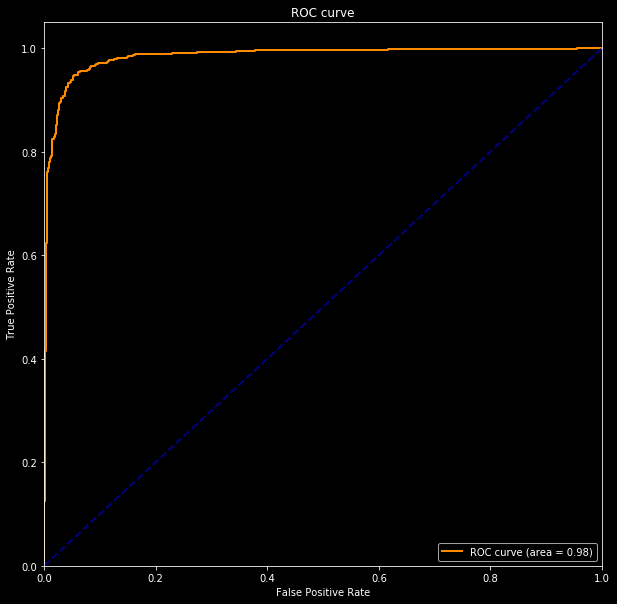

In [117]:
 tpr, fpr, threshold, roc_auc_ = make_roc_curves_array(true_vals=test_y, scores_vals=ran_preds_proba[:,1])

In [118]:
df_test['xgb_ran_proba_0'] = ran_preds_proba[:,0]
df_test['xgb_ran_proba_1'] = ran_preds_proba[:,1]

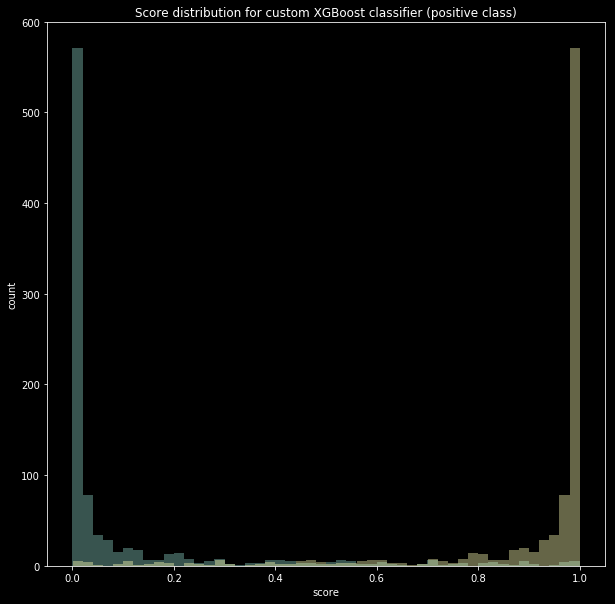

In [119]:
make_score_distribution(df=df_test, 
                        proba_cols=['xgb_ran_proba_0', 'xgb_ran_proba_1'], 
                        true_col='y_true', 
                        true_label=1, 
                        title='Score distribution for custom XGBoost classifier (positive class)')

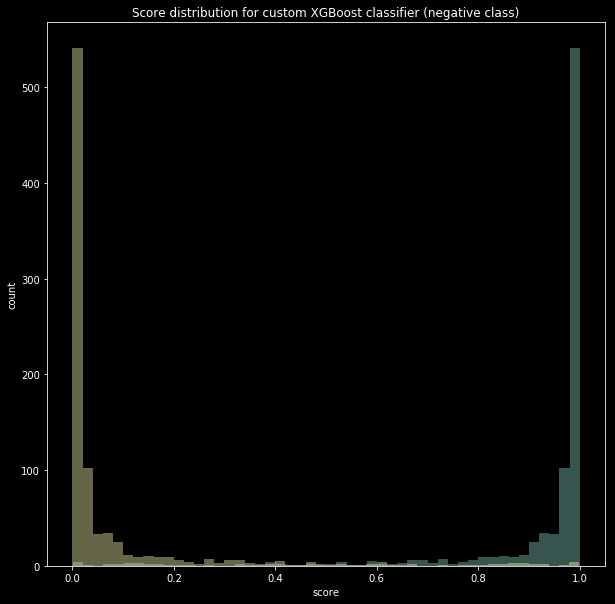

In [120]:
make_score_distribution(df=df_test, 
                        proba_cols=['xgb_ran_proba_0', 'xgb_ran_proba_1'], 
                        true_col='y_true', 
                        true_label=0, 
                        title='Score distribution for custom XGBoost classifier (negative class)')

## The results:
* For this made up problem, Bayesian hyperparameter optimization outperformed randomized search, although with this made up data, it's a marginal improvement.
* Bayesian optimization was also faster (TODO: Actually time this).

In [121]:
# Try out the explainer function.  
explainer_shap, df_test_transformed = final_model_bayes.explain_shap(df_test.drop(['y_true', 'xgb_bayes_proba_0', 'xgb_bayes_proba_1'], axis=1))

In [122]:
df_test_transformed.head(3)

,0,1,3,5,6,7,8,10,12,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,6.787927,-2.398810,3.763140,-0.306776,3.603276,-3.503878,0.568905,-4.378714,-5.083916,-3.493774,3.982439,-1.103532,5.820233,3.487376,0.069515,5.846524,-0.060551,1.725923,0.512832,3.405663,7.826829,0.502229,2.560930,9.756586,0.241706,2.776952,4.159488,0.771904,-15.221590,2.277749,10.191736,-13.098191,4.201982,-3.558343,6.549896,0.960430,5.713052,-0.132465,1.431475,4.275302,-2.397218,-12.830612,1.666448,5.485449
1,1.303005,0.360018,7.705366,-0.789274,0.284205,-3.286107,0.649963,-1.408807,-3.665927,2.871988,-2.242547,1.920038,-5.221792,-0.613659,5.734061,2.960237,1.747379,1.259893,-9.558937,3.016887,9.766829,-1.093390,1.057528,1.637256,4.857211,0.241120,-2.692056,0.169040,-15.092115,1.591324,-7.662906,0.224989,2.464369,0.432456,-5.135134,-2.008802,-1.620994,-0.220435,-4.129170,0.260641,-3.405662,9.608543,1.370971,2.218570
2,-4.617352,1.602548,1.853272,-2.325783,1.688796,-0.903120,0.687121,-0.571636,-3.780014,2.590466,2.289560,0.663586,1.570797,1.075096,-2.163301,-1.395527,-1.091706,-1.721619,-6.468404,-2.835082,-9.305145,-0.119042,-0.003651,-0.081479,-0.297223,0.467937,1.668702,1.313867,0.912227,1.563945,7.911137,2.188437,-1.323813,0.384242,-0.288449,1.063535,-13.076067,1.138047,-3.136407,0.993171,-4.266819,-11.032983,-0.339897,1.022271


In [123]:
df_test_transformed.shape

(1800, 44)

In [124]:
# Yep, that did work...

In [125]:
shap_values = explainer_shap.shap_values(df_test_transformed.values)

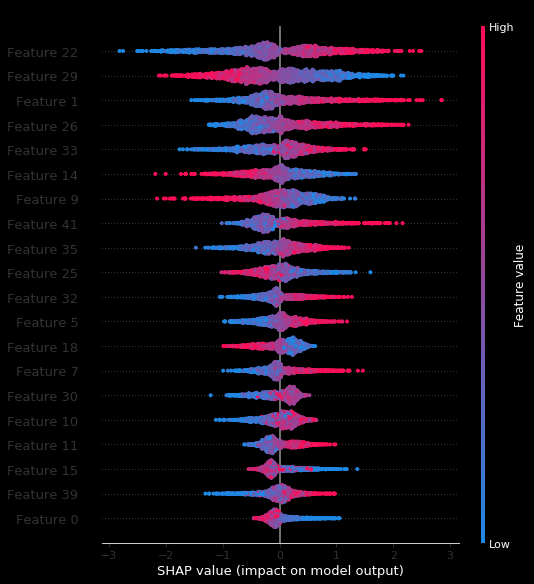

In [126]:
shap.summary_plot(shap_values, df_test_transformed.values)

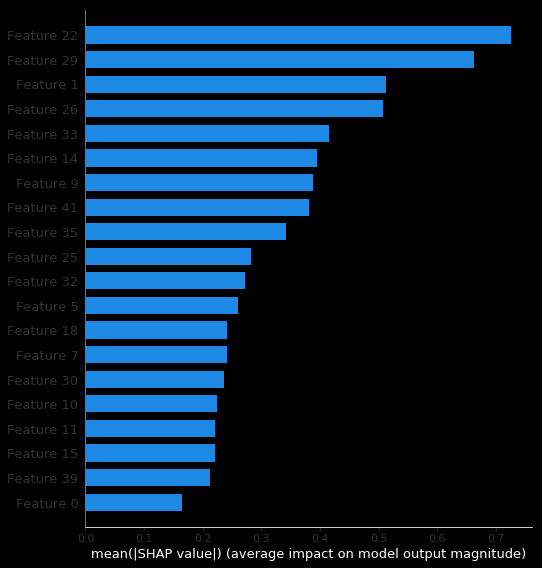

In [127]:
shap.summary_plot(shap_values, df_test_transformed.values, plot_type="bar")

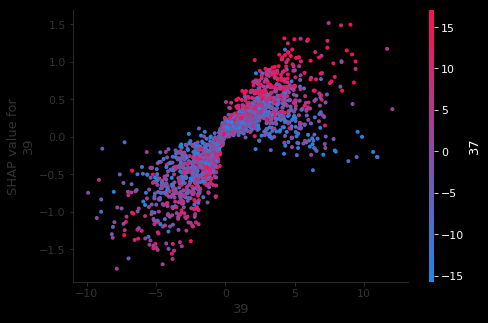

In [128]:
shap.dependence_plot(33, shap_values, df_test_transformed)

In [129]:
# Nice so this works!  Let's give it a go!  